In [2]:
# increase nbr of symols to 16
# 50k observations (500k if possible)

import pandas as pd
import numpy as np
from numpy import save
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift

from scipy.linalg import dft
import scipy.constants as scipy_cst
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

import time

In [3]:
from google.colab import drive
from numpy import load
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
t1 = time.time()
bits_64 = load('gdrive/My Drive/DL_913/data/20K_bits_64.npz')
d2= load('gdrive/My Drive/DL_913/data/data_5_100K_P2.6e-2.npz')
X = d2['X'] # distorted source
y = d2['y'] # original source

t2 = time.time()
print("Toral time to unpack X and y is : ", t2-t1, " seconds.")

Toral time to unpack X and y is :  86.91494250297546  seconds.


In [6]:
X = X[:50000,:]
y = y[:50000,:]

In [7]:
X.shape

(50000, 1024)

In [5]:
!nvidia-smi -L

GPU 0: Tesla P4 (UUID: GPU-8558756e-2a07-7c13-7649-c17841c4bcec)


# **Modeling everything**

In [8]:
class Parameters :
    
    
    def __init__(self, bandwidth = 1, nsymbols=256, M = 16, Nt= 2**10, nLayers=100, timeMesh=200):
        
        # distance variables are converted in km
        #--------------------------------- variables ------------------------------------------------------#

        # distance
        self.L = 1#1000e3
        # bandwidth - 1 GHz
        self.B = bandwidth #1.2

        #---------------------------------- physical constants --------------------------------------------#

        # power loss in dB
        self.a_dB = 0.2 
        # loss coefficient
        self.alpha = (1e-4)*np.log2(10)*self.a_dB
        # speed of light m/s
        self.c = 3e8
        # dispersion ps/(nm-m)
        self.D = 17*1e-6
        #non-linearity coefficient - W^-1 m^-1
        self.gama = 1.27*1e-3
        # a constant factor
        self.nsp = 1
        # Planck constant - J.s
        self.h = scipy_cst.Planck
        # center wavelength - m
        self.lambda0 = 1.55e-6 #1.55e-9
        # center frequency
        self.f0 = self.c/self.lambda0    
        # dispersion coefficient
        self.beta2 = -(self.D*(self.lambda0**2))/(2*np.pi*self.c)

        #---------------------------------- scale factors ------------------------------------------------#

        self.L0 = self.L
        self.T0 = np.sqrt(np.abs(self.beta2*self.L)/2)
        self.P0 = 2/(self.gama*self.L)

        #----------------------------------- noise PSD ---------------------------------------------------#

        # physical noise 
        self.sigma02 = self.nsp*self.h*self.alpha*self.f0
        # normalized
        self.sigma2 = self.sigma02*self.L/(self.P0*self.T0) 

        #-------------------------------------------------------------------------------------------------#

        self.power = 6e-2
        self.l = 1#5
        self.nz = nLayers # 500
        self.z = 1#self.l/self.L #1

        #------------------------------------ time mesh --------------------------------------------------#

        # you have to choose this
        self.T = timeMesh #( (1/bandwidth)*self.nb ) + (10*2/ self.nb) #timeMesh # 200#20 # (1/B)*Ns + 10*2/B
        # you have to choose this
        self.N = Nt #2*10**2 #2**10
        self.dt = self.T/self.N
        self.t = np.linspace(-self.T/2, self.T/2, num=self.N, endpoint=True)

        #------------------------------------ frequency mesh ---------------------------------------------#

        self.F = 1/self.dt
        self.df = 1/self.T
        self.f = np.linspace(-self.F/2, self.F/2, num=self.N, endpoint=True) #np.fft.fftfreq(self.N, self.dt)
        self.omega = 2*np.pi*self.f
        self.w = np.fft.fftshift(self.omega)

        #------------------------------------ bits to signal ---------------------------------------------#

        # size of the constellation
        self.M = M
        # number of symbols (or sinc functions); test with s=1
        self.n = nsymbols
        # number of bits
        self.nb = int(self.n * np.log2(self.M))
        # probability of zero
        self.p = 1/2
        
        #------------------------------------ Generative nnet ---------------------------------------------#
        
        # Number of the Layers of the Generative nnet 
        self.nbrLayers = nLayers
        # epsilon
        self.eps = self.z / self.nz
        
        # Amplitude for AWGN
        self.A = 2
        self.s = 2
    
    def setN(self,n):
        self.N = n
        self.__init__(N=n)
    
    def setNbrLayers(self,N):
        self.nbrLayers = N
        self.__init__(nbrLayers=N)

In [9]:
class NNetGenerator :

    #-------------------------------------------------------------------------------------------------#

    def __init__(self, parameters):
        self.params = parameters

    #-------------------------------------------------------------------------------------------------#

    def H(self, f, z):
        """ Compute the channel transfer function.
        @param f : frequency vector.
        @param z : scalar.
        """

        omega = 2*np.pi*f
        return np.exp(1j*z*omega**2)
       
    #-------------------------------------------------------------------------------------------------#

    def nnet_gen_old2(self,  X):
        """ Simulate a NNet by computing the V matrix (V is Y in the implementation).
            @param X : data.
        """
        # reshaping the input
        
        #print("[INFO] starting {nnet_gen}...")
        #print("X : ",X)
        X = X.reshape((-1, 1))
        dz = self.params.z/self.params.nz

        #np.set_printoptions(precision=2, suppress=True)  # for compact output

       # D = dft(X.size, scale='sqrtn')

       # R = self.H(self.params.f,dz)

       # W = np.dot(D.conj().T , np.dot(np.diag(R),D))

        # Deep Neural Network
        #print("[INFO] {nnet_gen} started generating the data...")
        #print("Before X.shape : ", X.shape)
        for j in range(self.params.nz):

            # Linear transformation     
           # X = np.dot(W, X)
            w = fftshift(2*np.pi*f)
            Y = ifft(fft(X)*np.exp(1j*w**2))
            
            w = np.fft.fftshift(2*np.pi*self.params.f)
            w = np.reshape(-1,1)
            if j  == 0:
              print("w.shape : ", w.shape)

            X = np.fft.ifft(np.exp(1j*dz*(w**2))*np.fft.fft(X))
            """ker = np.exp(1j*dz*(w**2))
            ker = np.reshape(-1,1)
            Xf = np.fft.fft(X)
            X = np.fft.ifft( ker*Xf )"""
            if j  == 0:
              print("After X.shape : ", X.shape)
            """
            if j  == 0:
              print("After Xf.shape : ", Xf.shape)
              print("After ker.shape : ", ker.shape)
              print("After X.shape : ", X.shape)
            """
            # Non-Linear transformation
            X = self.activation(X, dz)
            # Gaussian Noise 
            #Z = self.addNoise(len(X), self.params.sigma2 , self.params.B, dz)
            Z = self.noise(len(X), self.params.sigma2 , self.params.B, dz)
            X = X + Z
            
        # Output
        Y = np.squeeze(X + Z)
        
        return Y

    #-------------------------------------------------------------------------------------------------#

    def nnet_gen(self,  X):

      """ Simulate a NNet by computing the V matrix (V is Y in the implementation).
          @param X : data.
      """
      #X = X.reshape((-1, 1))
      X =  np.asarray(X)
      dz = self.params.z/self.params.nz


      for j in range(self.params.nz):

          # Linear transformation    

          
          #w = np.fft.fftshift(2*np.pi*self.params.f)
          
          #X = np.fft.ifft(np.exp(1j*dz*(w**2))*np.fft.fft(X))

          X = np.fft.ifft(np.fft.fft(X)*np.exp(1j*dz*(self.params.w**2)))
          # Non-Linear transformation
          X = self.activation(X, dz)

          # Complex Gaussian Noise 
          #Z = self.addNoise(len(X), self.params.sigma2 , self.params.B, dz)
          Z = self.noise(len(X), self.params.sigma2 , self.params.B, dz)
        
          Y = X + Z
          X = Y
          
      # Output
      Y = np.squeeze(X)
      
      return Y

    #-------------------------------------------------------------------------------------------------#

    def SpectrumAnalysis(self, x, Fs):
        L = int(np.power(2, np.ceil(np.log2(len(x)))))
        f = np.fft.fftshift(np.linspace(-Fs/2, Fs/2, L))
        x_fft = np.fft.fft(x, L)
        return np.abs(x_fft), f
    
    #-------------------------------------------------------------------------------------------------#

    def linearEffect(self, x, epsilon, Fs):

        L = int(np.power(2, np.ceil(np.log2(len(x)))))
        x_fft = np.fft.fft(x, L)
        f = np.fft.fftshift(np.linspace(-Fs/2, Fs/2, L))
        lamda = np.exp(1j * epsilon * ((2*f*np.pi)**2))
        x_ifft = np.fft.ifft(x_fft * lamda)
        x_ifft = np.delete(x_ifft, range(x.shape[0], L))

        return x_ifft 
    
    #-------------------------------------------------------------------------------------------------#

    def nonlinearEffect(self, x, epsilon):
        return x * np.exp(1j * 2 * epsilon * (np.abs(x)**2))
    
    #-------------------------------------------------------------------------------------------------#

    def add_noise(self, x, sigma02, B, epsilon):
        return np.random.normal(0, sigma02**2 * B * epsilon, x.shape)

    #-------------------------------------------------------------------------------------------------#

    def noise(self, n, sigma2, B, dz):
      Pn = sigma2 * B * dz

     # Z = np.fft.fftshift(np.fft.ifft(np.random.normal(loc=0, scale=np.sqrt(Pn), size=(n, 1))))
      Z = np.sqrt(Pn/2)*(np.random.randn(n) + 1j*np.random.randn(n)) # check if (n,1) or (1,n)

      return Z
    
    #-------------------------------------------------------------------------------------------------#

    def nnet_gen_old(self, X):
        
        epsilon = self.params.z / self.params.nz
        
        for i in range(self.params.nbrLayers):
            
            V = self.linearEffect(X, epsilon, self.params.F)
            U = self.nonlinearEffect(V, epsilon)
            Y = U + self.add_noise(U, self.params.sigma02, self.params.B, epsilon)
            X = Y
            
        return X

    #-------------------------------------------------------------------------------------------------#


    def activation(self, x, dz):
        """ Computes the activation of a neuron.
            @param X : data.
        """
        return x*np.exp(2j*dz*(np.abs(x)**2))

    #-------------------------------------------------------------------------------------------------#


    def addNoise(self, n, sigma2, B, dz):
        """ Generate Gaussian noise. """
        Pn = sigma2 * B * dz

        Z = np.fft.fftshift(np.fft.ifft(np.random.normal(loc=0, scale=np.sqrt(Pn), size=(n, 1))))
        return Z
        
    #-------------------------------------------------------------------------------------------------#

In [10]:
class Channel :

    #-------------------------------------------------------------------------------------------------#

    def __init__(self):
        super()

    #-------------------------------------------------------------------------------------------------#

    def channel(self, t, q0t, z, sigma2, B) :
        # total noise power in B Hz and distance [0, z]
        a = sigma2*B*z 
        # get the f vector from t vector
        f = np.fft.fftfreq(t.size, 2*t[-1]/t.size)
        omega = 2*np.pi*f
        omega2 = omega**2
        # input in frequency
        q0f = np.fft.fft(q0t)
        #output in frequency
        hwz = np.exp(1j*z*omega2)
        # element-wise multiplication
        qzf = np.multiply(q0f,hwz) 
        #add Guassian noise in frequency, with correct variance
        N = len(f)
        qzf = qzf + np.random.normal(0, np.sqrt(a), qzf.shape)
        # back to time
        qzt = np.fft.ifft(qzf) 

        print("[channel] qzt :",qzt)
        print("[channel] qzf :",qzf)
        
        return qzt, qzf

In [11]:
class Transmitor :

    def __init__(self):
        super()


    #-------------------------------------------------------------------------------------------------#
    
    def source(self, N, p):
        """ Generates an N-bit sequence drawn from a Bernoulli stochastic process.
            @param N : Length of the bit sequence
            @param p : probability of 0
        """
        n=1
        return np.random.binomial(n, p, size=N)
    
    def source__(self, N, p):
        b = np.zeros((N, 1), dtype=np.int32)
        for i in range(N):
            x = np.random.choice([0, 1], p=[p, 1-p])
            b[i] = x
        return b


    #-------------------------------------------------------------------------------------------------#

    def build_constellations(self, M):
    
        """ Builds a M-QAM constellation.
            @param M : Number of symbols.
        """
        
        # Sequential address from 0 to M-1 (1xM dimension)
        n = np.arange(0,M)
        #convert linear addresses to Gray code
        a = np.asarray([x^(x>>1) for x in n])
        #Dimension of K-Map - N x N matrix
        D = np.sqrt(M).astype(int) 
        # NxN gray coded matrix
        a = np.reshape(a,(D,D))
        # identify alternate rows
        oddRows=np.arange(start = 1, stop = D ,step=2) 
        
        # reshape to 1xM - Gray code walk on KMap
        nGray=np.reshape(a,(M)) 
        
        #element-wise quotient and remainder
        (x,y)=np.divmod(nGray,D) 
        # PAM Amplitudes 2d+1-D - real axis
        Ax=2*x+1-D 
        # PAM Amplitudes 2d+1-D - imag axis
        Ay=2*y+1-D 
        constellation = Ax+1j*Ay
        
        self.constellation = constellation

        return constellation


    #-------------------------------------------------------------------------------------------------#

    def bit_to_symb_(self, b, cnt):
        """ Creates a mapping between bits sequences and symbols.
            @param b : N-bit sequence
            @param cnt : constellation
        """
        
        M = len(cnt)
        N = len(b)
        n = int(N/np.log2(M))
        pas = int(np.log2(M))
        """
        print("[bit_to_symb] M :",M)
        print("[bit_to_symb] N :",N)
        print("[bit_to_symb] n :",n)
        print("[bit_to_symb] pas :",pas)
        print("[bit_to_symb] b :",b)
        """

        #dictionary of mapping
        #mapping_dict = {}
        #mapping_list = []        
        mapping_list_symbols_only = []

        for i in range(n):
            # bit sequence
            s = b[pas*i:(pas*i)+pas]   
            s_str = ''.join(map(str, s)) # converts the bit array to string
            
            # avoids adding a 0 len string to the mapping
            if s_str != '' :
                symbol = cnt[i%M]
                #mapping_dict[s_str] = symbol
                #mapping_list.append((s_str,symbol))
                mapping_list_symbols_only.append(symbol)


        #self.b2sMapping_dict = mapping_dict
        #self.b2sMapping_list = mapping_list

        """
        print("[bit_to_symb] mapping_dict :",mapping_dict)
        print("[bit_to_symb] mapping_dict len :",len(mapping_dict))
        print("[bit_to_symb] mapping_list len :",len(mapping_list))
        print("[bit_to_symb] mapping_list[0] :",mapping_list[0])
        print("mapping_list[0][0] : ", type(mapping_list[0][1]))
        """
        return mapping_list_symbols_only
    
    #-------------------------------------------------------------------------------------------------#

    def bit_to_symb(self, b, M):
        k = int(np.log2(M))
        
        if b.size % k != 0:
            b = np.vstack((b, np.zeros((6-b.size % k, 1), dtype=np.uint8)))
            
        bits = b.reshape((-1, k))
        
        symboles = []
        for bi in bits:
            biDec = np.packbits(np.hstack((np.zeros(8-k, dtype=np.uint8), bi)))[0]
            bin, code = self.grayCoding(biDec, M)
            symboles.append(code)

        return np.array(symboles)
    
    #-------------------------------------------------------------------------------------------------#

    def grayCoding(self, n, M):
        k = int(np.log2(M))

        reAxis = np.hstack((np.arange(-(np.sqrt(M)//2), 0, step=1),
                            np.arange(1, np.sqrt(M)/2+1, step=1)))
        imAxis = np.copy(reAxis)

        bin = np.unpackbits(np.array([n], dtype=np.uint8))[8-k:]

        rePart = bin[:k//2]
        imPart = bin[k//2:]

        aReBin = np.hstack((np.zeros(8-k//2, dtype=np.uint8), rePart))
        aImBin = np.hstack((np.zeros(8-k//2, dtype=np.uint8), imPart))

        aReDec = np.packbits(aReBin)
        aImDec = np.packbits(aImBin)

        reIndex = np.bitwise_xor(aReDec, aReDec//2)[0]
        imIndex = np.bitwise_xor(aImDec, aImDec//2)[0]

        return  bin, complex(reAxis[reIndex], imAxis[imIndex])
    
    #-------------------------------------------------------------------------------------------------#

In [12]:
class Modulator :

    #-------------------------------------------------------------------------------------------------#

    def __init__(self):
      super()

    #-------------------------------------------------------------------------------------------------#
    
    def mod_(self, t,S, B):
        """ Modulate symbols data.
            @param t : time.
            @param s : sequence of symbols.
            @param B : Bandwidth.
        """

        # number of symbols
        Ns = len(S)
        # init
        q0t = 0
             
        for i in range(Ns):
            q0t = q0t + np.sqrt(B)*S[i]*np.sinc(B*t-i) #np.sinc(B*t-i)
        
        norm = np.linalg.norm(q0t)
        q0t = q0t/norm
        
        return q0t
    
    def mod(self,t, s, B):
        Ns = len(s)  # Number of Symbols

        l1 = int(-(Ns/2))
        l2 = int((Ns/2) - 1)

        lRange = np.linspace(l1, l2, num=Ns, endpoint=True)

        q0t = 0# np.zeros((1, t.size), dtype=np.complex64)

        for sl, l in zip(s, lRange):
            q0t += sl * np.sinc(B*t - l)

        return np.sqrt(B)*q0t

    #-------------------------------------------------------------------------------------------------#


In [13]:
class Equalizer :

    #-------------------------------------------------------------------------------------------------#

    def __init__(self):
        super()

    #-------------------------------------------------------------------------------------------------#

    def equalize(self, t, qzt, z):
        
        # get the f vector from t vector
        f = np.fft.fftfreq(t.size, 2*t[-1]/t.size)
        # get the omega vector from f vector
        omega = 2*np.pi*f

        # compute omega² for h
        omega2 = omega**2

        # Channel transfer function
        hwz = np.exp(1j*z*omega2)
        hwz_1 = np.reciprocal(hwz)
        # input in frequency
        qzf = np.fft.fft(qzt)
        # output in frequency        
        qzfe = np.multiply(qzf,hwz_1)
        # back to time
        qzte = np.fft.ifft(qzfe)

        print("[Equalizer] qzte :",qzte)
        print("[Equalizer] qzfe :",qzfe)
        return qzte, qzfe

In [14]:
#-----------------------------------------------------------------------------------------#

# Generating the dataset
def generateDataset_old(nbrOfObservations, parameters):

    X = np.ndarray((parameters.N, nbrOfObservations), dtype=np.complex128)
    y = np.ndarray((parameters.N, nbrOfObservations), dtype=np.complex128)

    print("[INFO] Generating the dataset...")

    for i in tqdm(range(1,nbrOfObservations)):
        """
        #source
        source = transmitor.source(parameters.N , parameters.p)

        # Constellation
        constellation = transmitor.build_constellations(parameters.M)

        # Bits to Symboles 
        bitsToSymbols = transmitor.bit_to_symb(source, constellation)
        # Modulation
        q0t = modulator.mod(parameters.t, constellation, parameters.B)
        """
        q0t = parameters.A*np.exp(-parameters.t**2) 
        #q0f = np.fft.fft(q0t)
        X[i] = np.squeeze(q0t)

        # Neural Net Generator
        Y = nnetGen.nnet_gen(q0t)
        #Y = nnetGen.nnet_gen_old(q0t)

        y[i] = Y

    print("[INFO] The dataset is ready now !")
    return X, y
#-----------------------------------------------------------------------------------------#
# Generating the dataset
def generateDataset(nbrOfObservations, parameters, batch_size, index_start, isGaussian=False, testing=False):

    #X = np.ndarray((nbrOfObservations, parameters.N), dtype=np.complex128)
    #y = np.ndarray((nbrOfObservations, parameters.N), dtype=np.complex128)

    X = np.ndarray((batch_size, parameters.N), dtype=np.complex128)
    y = np.ndarray((batch_size, parameters.N), dtype=np.complex128)

    print("[INFO] Generating the dataset...")
    #X = cp.asarray(X)
    #y = cp.asarray(y)

    #changed range from 0... not 1
    for i in tqdm(range(0,nbrOfObservations+1)):
        
        # we save data per batch to avoid missing data due to colab timeout...
        if i % batch_size == 0 and i != 0:
          file_saved_name = "gdrive/My Drive/DL_913/data/data_"+str(index_start)+".npz"
          np.savez_compressed(file_saved_name, X=X, y=y)
          X = np.ndarray((batch_size, parameters.N), dtype=np.complex128)
          y = np.ndarray((batch_size, parameters.N), dtype=np.complex128)
          print("[INFO] Saved generated data index ", index_start)
          index_start = index_start + 1

        # Constellation
        constellation = transmitor.build_constellations(parameters.M)
        
        #source
        source = transmitor.source(parameters.nb , parameters.p) # USE IT FOR NEXT PART OF BITS
        
        # Bits to Symboles - symbol sequence
        #bitsToSymbols = transmitor.bit_to_symb(source, constellation)
        # symbol sequence
        #mapping_dict, mapping_list, mapping_list_symbols_only = transmitor.bit_to_symb(source, constellation)
        # we create a list of values of the complex symbols to use them in modulation
        val_s = transmitor.bit_to_symb(source, parameters.M)
        
        # we create a list of values of the complex symbols to use them in modulation
        #val_s = list(bitsToSymbols.values())
        
        # Modulation
        if testing:
            print("[INFO] Modulation...")  

        # channel - we take gaussian input
        if isGaussian:
            q0t = parameters.A*np.exp(-parameters.t**2) 
            #q0f = np.fft.fft(q0t)

        else :
            q0t = modulator.mod(parameters.t,val_s, parameters.B)  
            #q0f = np.fft.fft(q0t)

        # SOURCE IS THE SEQUENCE OF BITS TO BE LEARNED
        index = i % batch_size
        X[index] = np.squeeze(q0t)

        # Neural Net Generator
        Y = nnetGen.nnet_gen_old(q0t)
        #Y = nnetGen.nnet_gen(q0t)
        y[index] = Y
        
        """
        if i == 0 :
            print("[INFO] Y : ",Y)
            print("[INFO] shape Y : ", Y.shape)
            print("[INFO] q0t.shape : ",q0t.shape)        
            print("[INFO] Y.shape : ",Y.shape)
        """
            
    print("[INFO] The dataset is ready now !")
    return X, y

#-----------------------------------------------------------------------------------------#

def createDataFrame(X,y) :
    X_ = np.column_stack((X.real,X.imag))
    y_ = np.column_stack((y.real,y.imag))
    data = np.column_stack((X_,y_))

    df = pd.DataFrame(data)
    print("df.shape : ",df.shape)
    df.to_csv("generatedData.csv")
    
    return df

#-----------------------------------------------------------------------------------------#

def test_dataset(X, parameters, index):
  
    withPlot = True
    q0t = X[index] #fromRealToComplex(l)
    q0f = np.fft.fft(q0t)

    qzt, qzf = channel.channel(parameters.t, q0t, parameters.z, parameters.sigma02, parameters.B)

    # Equalization
    qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z)

    if withPlot :
        fig2, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, figsize = (15, 15))
        fig2.tight_layout(pad=7.0)

        ###
        ax1.plot(parameters.t, np.squeeze(q0t.real), 'b-')
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Re(q0t)")
        ax1.set_title("Modulation - Time plot - Re(q0t)")

        ###
        ax2.plot(parameters.f, np.squeeze(np.abs(q0f)), 'b-')
        ax2.set_xlabel("Freq")
        ax2.set_ylabel("Abs(q0f)")
        ax2.set_title("Modulation - Freq plot - |q0f|")

        ###        
        ax3.plot(parameters.t, np.squeeze(qzt.real), 'b-')
        ax3.set_xlabel("Time")
        ax3.set_ylabel("Re(qzt)")
        ax3.set_title("Channel - Time plot - Re(qzt)")

        ###
        ax4.plot(parameters.f, np.squeeze(np.abs(qzf)), 'b-')
        ax4.set_xlabel("Freq")
        ax4.set_ylabel("Abs(qzf)")
        ax4.set_title("Channel - Freq plot - |qzf|")

        ###
        ax5.plot(parameters.t, np.squeeze(qzte.real), 'b-')
        ax5.set_xlabel("Time")
        ax5.set_ylabel("Abs(qzf)")
        ax5.set_title("Equalization - Time plot - Re(qzte)")

        ###
        ax6.plot(parameters.f, np.squeeze(np.abs(qzfe)), 'b-')
        ax6.set_xlabel("Freq")
        ax6.set_ylabel("Abs(qzf)")
        ax6.set_title("Equalization - Freq plot - |qzfe|")

        plt.show()
        
#-----------------------------------------------------------------------------------------#

In [15]:
#-----------------------------------------------------------------------------------------#

def run(isGaussian=False, s=2):

    # builds the constellation 
    constellation = transmitor.build_constellations(parameters.M) # 16-QAM
    
    # Bernoulli source, random bits sequence
    b = transmitor.source(parameters.nb,parameters.p)
    print("b : ",b)

    # symbol sequence, we create a list of values of the complex symbols to use them in modulation
    #val_s = transmitor.bit_to_symb(b, constellation)
    val_s = transmitor.bit_to_symb(b, parameters.M)

    
    # modulation   

    # channel - we take gaussian input
    if isGaussian:
        print("isGaussian")
        q0t = parameters.A*np.exp(-parameters.t**2/s) 
        q0f = np.fft.fft(q0t)
        
    else :
        q0t = modulator.mod(parameters.t,val_s, parameters.B)  
        q0f = np.fft.fft(q0t)
    
        print("q0t : ",q0t)


    # Pass through the channel
    qzt, qzf = channel.channel(parameters.t, q0t, parameters.z, parameters.sigma02, parameters.B)

    # Equalization
    qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z)

    fig2, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, figsize = (25, 25))
    fig2.tight_layout(pad=10.0)

    ###
    ax1.plot(parameters.t, np.squeeze(q0t.real), 'b-')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Re(q0t)")
    ax1.set_title("Modulation - Time plot - Re(q0t)")

    ###
    ax2.plot(parameters.f, np.squeeze(np.abs(q0f)), 'b-')
    ax2.set_xlabel("Freq")
    ax2.set_ylabel("Abs(q0f)")
    ax2.set_title("Modulation - Freq plot - |q0f|")

    ###        
    ax3.plot(parameters.t, np.squeeze(qzt.real), 'b-')
    ax3.set_xlabel("Time")
    ax3.set_ylabel("Re(qzt)")
    ax3.set_title("Channel - Time plot - Re(qzt)")

    ###
    ax4.plot(parameters.f, np.squeeze(np.abs(qzf)), 'b-')
    ax4.set_xlabel("Freq")
    ax4.set_ylabel("Abs(qzf)")
    ax4.set_title("Channel - Freq plot - |qzf|")

    ###
    ax5.plot(parameters.t, np.squeeze(qzte.real), 'b-')
    ax5.set_xlabel("Time")
    ax5.set_ylabel("Abs(qzf)")
    ax5.set_title("Equalization - Time plot - Re(qzte)")

    ###
    ax6.plot(parameters.f, np.squeeze(np.abs(qzfe)), 'b-')
    ax6.set_xlabel("Freq")
    ax6.set_ylabel("Abs(qzf)")
    ax6.set_title("Equalization - Freq plot - |qzfe|")

    plt.show()

#-----------------------------------------------------------------------------------------#

def test(X, parameter):

    # Signal
    if X is None :
        X = parameter.A*np.exp(-parameter.t**2/parameter.s)

    # NNet generator
    Y1 = nnetGen.nnet_gen(X)

    # Channel
    Y2, _ = channel.channel(parameter.t, X, parameter.z, 0, 0)

    # Equalizer
    Y2e, _ = equalizer.equalize(parameter.t, Y2, parameter.z)
    Y1e, _ = equalizer.equalize(parameter.t, np.squeeze(Y1), parameter.z)

    # Fourier Transform
    Xf = fftshift(fft(X))
    Yf = fftshift(fft(Y1))
    
    #Plots
    
    fig = plt.figure(figsize=(25, 25))
    
    # Input signal
    ax = fig.add_subplot(711)
    fig.suptitle('X -- Y1 -- Y2')
    ax.set_xlabel('Time')
    ax.set_ylabel('X')
    ax.plot(parameter.t, X, 'g--')
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')

    # NNet generator
    ax = fig.add_subplot(712)
    ax.set_xlabel('Time')
    ax.set_ylabel('Y1')
    ax.plot(parameter.t, np.squeeze(np.absolute(Y1)), 'r--')
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')
    
    # Signal after channel
    ax = fig.add_subplot(713)
    ax.set_xlabel('Time')
    ax.set_ylabel('Y2')
    ax.plot(parameter.t, np.absolute(Y2), 'b--')
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')
    
    # NNet gen signal after equalization 
    ax = fig.add_subplot(714)
    ax.set_xlabel('Time')
    ax.set_ylabel('Y1 equalized')
    ax.plot(parameter.t, np.absolute(Y1e), 'b--')
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')
    
    # NNet gen signal after equalization
    ax = fig.add_subplot(715)
    ax.set_xlabel('Time')
    ax.set_ylabel('Y2 equalized')
    ax.plot(parameter.t, np.absolute(Y2e), 'b--')
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')
    
    # Input vs output
    
    # in time
    ax = fig.add_subplot(716)
    ax.set_xlabel('Time')
    ax.plot(parameter.t, X, 'b--', label='input')
    ax.plot(parameter.t, np.absolute(Y2), 'r--', label='output')
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')
    
    # in freq
    ax = fig.add_subplot(717)
    ax.set_xlabel('Frequency')
    ax.plot(parameter.f, np.absolute(Xf), 'b--', label='input')
    ax.plot(parameter.f, np.absolute(Yf), 'r--', label='output')
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')

    plt.show()
    
#-----------------------------------------------------------------------------------------#

def test_generated(X, y, index, parameter):

    # Signal : X
    X = np.squeeze(X[index])
    
    # NNet generator : y
    y_gen = np.squeeze(y[index])
    y = np.squeeze(y[index])

    w_ = np.fft.fftshift(2*np.pi*parameter.f)
    w_ = np.reshape(-1,1)
    y_vf = np.fft.ifft(np.exp(1j*parameter.z*(w_**2))*np.fft.fft(X))
    
    # Channel
    Y2, _ = channel.channel(parameter.t, X, parameter.z, parameter.sigma2, parameter.B )#0, 0)

    # Equalizer
    Y2e, _ = equalizer.equalize(parameter.t, Y2, parameter.z)
    Y1e, _ = equalizer.equalize(parameter.t, np.squeeze(y), parameter.z)

    # Fourier Transform
    Xf = fftshift(fft(X))
    Yf = fftshift(fft(y))
    
    #Plots
    
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, figsize = (25, 25))
    #fig = plt.figure(figsize=(25, 25))
    fig.tight_layout(pad=3.0)
    # Input signal
    #ax = fig.add_subplot(711)
    fig.suptitle('Testing the generated data')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('X')
    ax1.set_title("Input Signal")
    ax1.plot(parameter.t, np.abs(X), 'g--')
    ax1.axhline(y=0, color='black')
    ax1.axvline(x=0, color='black')

    # NNet generator
    #ax = fig.add_subplot(712)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('y')
    ax2.set_title("Output of the nnet gen")
    ax2.plot(parameter.t, np.abs(y_gen), 'r--')
    #ax2.plot(parameter.t, np.abs(y_vf), 'g--')
    ax2.axhline(y=0, color='black')
    ax2.axvline(x=0, color='black')
    
    # Signal after channel
    #ax = fig.add_subplot(713)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Y2')
    ax3.set_title("Output of X passing th channel function")
    ax3.plot(parameter.t, np.abs(Y2), 'b--')
    ax3.axhline(y=0, color='black')
    ax3.axvline(x=0, color='black')
    
    # NNet gen signal after equalization
    #ax = fig.add_subplot(714)
    ax4.set_xlabel('Time')
    ax4.set_ylabel('y equalized')
    ax4.set_title("Equalized output of the nnet gen")
    ax4.plot(parameter.t, np.abs(Y1e), 'b--')
    ax4.axhline(y=0, color='black')
    ax4.axvline(x=0, color='black')
    
    # NNet gen signal after equalization
    #ax = fig.add_subplot(715)
    ax5.set_xlabel('Time')
    ax5.set_ylabel('Y2 equalized')
    ax5.set_title("Equalized X passing th channel function")
    ax5.plot(parameter.t, np.abs(Y2e), 'b--')
    ax5.axhline(y=0, color='black')
    ax5.axvline(x=0, color='black')
    
    # Input vs output
    
    # in time
    #ax = fig.add_subplot(716)
    ax6.set_xlabel('Time')
    ax6.plot(parameter.t, np.abs(X), 'b--', label='input')
    ax6.plot(parameter.t, np.abs(Y2), 'r--', label='output')
    ax6.set_title("Input X vs X passing the channel function")
    ax6.axhline(y=0, color='black')
    ax6.axvline(x=0, color='black')
    ax6.legend()
    
    # in freq
    #ax = fig.add_subplot(717)
    ax7.set_xlabel('Frequency')
    ax7.plot(parameter.f, np.abs(Xf), 'b--', label='input')
    ax7.plot(parameter.f, np.abs(Yf), 'r--', label='output')
    ax7.set_title("Input X vs output of nnet gen (in Freq)")
    ax7.axhline(y=0, color='black')
    ax7.axvline(x=0, color='black')
    ax7.legend()

    plt.show()
    
#-----------------------------------------------------------------------------------------#

## **Helpers**

In [16]:
#----------------------------------------------------------------------------#

def fromComplexToReal(vect_im):
  
   # vect_real = []
    N = vect_im.shape[0]
    M = vect_im.shape[1]*2
    vect_real = np.zeros((N,M))

    print("\n [INFO] {fromComplexToReal} runing...")
    print("\n [INFO] vect_real.shape : " , vect_real.shape)

    for i in tqdm(range(len(vect_im))) :
        tmp = []
        for j in range(len(vect_im[i])) :
            z = vect_im[i][j]
            tmp.append(z.real)
            tmp.append(z.imag)
        vect_real[i] = tmp
        #vect_real.append(tmp)

    #vect_real = np.asarray(vect_real)
    print(" [INFO] {fromComplexToReal} vect_real.shape : ",vect_real.shape)

    return vect_real

#----------------------------------------------------------------------------#

def fromRealToComplex(vect_real):
  
    # init variables
    #vect_im = []
    N = vect_real.shape[0]
    M = vect_real.shape[1]//2
    
    vect_im = np.zeros((N,M), dtype=np.complex64)  

    print("\n [INFO] {fromRealToComplex} runing...")
    # iterate over the vector
    for i in tqdm(range(len(vect_real))) :
        tmp = []
        j = 0

        # we can't use for loop with range() we have no control over the index
        while j < len(vect_real[i]) :

          # y = a+j*b
          im = vect_real[i][j] + 1j*vect_real[i][j+1]
          # we already processed two elements 
          j = j + 2
          # append the new element to the output array
          tmp.append(im)

        # matrix i*j
        #vect_im.append(tmp)
        vect_im[i] = tmp
    # to numpy
    #vect_im = np.asarray(vect_im)
    print("[INFO] {fromRealToComplex} vect_im.shape : ",vect_im.shape)

    return vect_im

#----------------------------------------------------------------------------#

def fromRealToComplex2(vect_real):
  
    # init variables
    vect_im = []

    print("\n [INFO] {fromRealToComplex} runing...")
    # iterate over the vector
    for i in tqdm(range(len(vect_real))) :
        tmp = []
        j = 0

        # we can't use for loop with range() we have no control over the index
        while j < len(vect_real[i]) :

          # y = a+j*b
          im = vect_real[i][j] + 1j*vect_real[i][j+1]
          # we already processed two elements 
          j = j + 2
          # append the new element to the output array
          tmp.append(im)

        # matrix i*j
        vect_im.append(tmp)
    # to numpy
    vect_im = np.asarray(vect_im)
    print("[INFO] {fromRealToComplex} vect_im.shape : ",vect_im.shape)

    return vect_im

#----------------------------------------------------------------------------#

def prepareDataFrame(X, y, scaling) :

    X_real = fromComplexToReal(X)
    y_real = fromComplexToReal(y)

    data = np.column_stack((X_real,y_real))

    df_ = pd.DataFrame(data)

    if scaling :
      scaler = MinMaxScaler()
      df_ = scaler.fit_transform(df_)
      
    df_ = shuffle(df_)

    print("{prepareDataFrame} df_.shape : ",df_.shape)

    return df_

#----------------------------------------------------------------------------#

def prepareDataFrameBits(X, y) :


    data = np.column_stack((X,y))

    df_ = pd.DataFrame(data)
    df_ = shuffle(df_)

    print("{prepareDataFrameBits} df_.shape : ",df_.shape)

    return df_

#----------------------------------------------------------------------------#

def prepareTrainAndTestData(df, withReshape, ts):

  #df = df.set_index('Attribute',inplace=True)
  
    N_samples = df.shape[0]
    N_features = df.shape[1]//2
    N_cols = df.shape[1]

    if type(df) != np.ndarray :
        print("[INFO] - {prepareTrainAndTestData} converting from pandas to numpy...")
        df_np = df.to_numpy()
        y = df_np[:N_samples,0:N_features]
        X = df_np[:N_samples,N_features:N_cols]
    else :
        y = df[:N_samples,0:N_features]
        X = df[:N_samples,N_features:N_cols]

    N_features = len(X[0])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts)

    N_samples_train = len(X_train)
    N_samples_test = len(X_test)

    if withReshape :
        X_train = X_train.reshape(N_samples_train, N_features, 1)
        X_test = X_test.reshape(N_samples_test, N_features, 1)
        y_train = y_train.reshape(N_samples_train, N_features, 1)
        y_test = y_test.reshape(N_samples_test, N_features, 1)

    print(X.shape)
    print(y.shape)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)

    return X_train, X_test, y_train, y_test
  
#----------------------------------------------------------------------------#

def prepareTrainAndTestDataBits(df, withReshape, ts):

  #df = df.set_index('Attribute',inplace=True)
  
    N_samples = df.shape[0]
    N_features = df.shape[1]//2
    N_cols = df.shape[1]

    if type(df) != np.ndarray :
        print("[INFO] - {prepareTrainAndTestDataBits} converting from pandas to numpy...")
        df_np = df.to_numpy()
        X = df_np[:N_samples,0:N_features]
        y = df_np[:N_samples,N_features:N_cols]
    else :
        X = df[:N_samples,0:N_features]
        y = df[:N_samples,N_features:N_cols]

    N_features = len(X[0])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts)

    N_samples_train = len(X_train)
    N_samples_test = len(X_test)

    if withReshape :
        X_train = X_train.reshape(N_samples_train, N_features, 1)
        X_test = X_test.reshape(N_samples_test, N_features, 1)
        y_train = y_train.reshape(N_samples_train, N_features, 1)
        y_test = y_test.reshape(N_samples_test, N_features, 1)

    print(X.shape)
    print(y.shape)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)

    return X_train, X_test, y_train, y_test
  
#----------------------------------------------------------------------------#

## **Variables initialization**

In [17]:
bandwidth = 1#1e9                       # bandwidth
nsymbols = 16                    # Number of symbols
M = 16                                # size of the constellation
Nt = 2**10                           # Sample size
nLayers = 500                         # Number of Layers of the Generative network
nb = int(nsymbols * np.log2(M))       # Number of bits
timeMesh = int( (nb/bandwidth)+ (10*2/ nb) ) # 40 #70 # int( (nb/bandwidth)+ (10*2/ nb) )

In [18]:
int( (nb/bandwidth)+ (10*2/ nb) )

64

In [19]:
# Initialize parameters
parameters = Parameters(bandwidth, nsymbols, M, Nt, nLayers, timeMesh)
#params = Parameters(bandwidth, nsymbols, M, Nt, nLayers, timeMesh)
# Initialize the Transmitor
transmitor = Transmitor()
# Initialize the Transmitor
modulator = Modulator()
# Initialize the Channel
channel = Channel()
# Initialize the Equalizer
equalizer = Equalizer()
# Initialize the NNetGenerator
nnetGen = NNetGenerator(parameters)

[channel] qzt : [ 1.11022302e-16+5.55111512e-17j -1.11022302e-16+5.55111512e-17j
  0.00000000e+00+5.55111512e-17j ...  0.00000000e+00+5.55111512e-17j
  2.22044605e-16-1.11022302e-16j  0.00000000e+00+0.00000000e+00j]
[channel] qzf : [ 80.13377265+0.j         -79.74283823-1.01328674j
  78.52833912+3.51169614j ... -76.5083959 -5.94443197j
  78.56552   +2.5477682j  -79.7475545 -0.52397481j]
[Equalizer] qzte : [0.00000000e+00+8.03012552e-17j 2.22044605e-16-4.63986508e-17j
 1.11022302e-16-5.00871144e-17j ... 0.00000000e+00-2.30662679e-17j
 1.11022302e-16+3.91512635e-17j 1.11022302e-16+6.89312459e-17j]
[Equalizer] qzfe : [ 80.13377265+1.02695630e-15j -79.74890053-2.44667330e-01j
  78.60533964+4.82322376e-01j ... -76.7357288 +7.06286746e-01j
  78.60533964-4.82322376e-01j -79.74890053+2.44667330e-01j]
[Equalizer] qzte : [ 9.93514468e-08-8.92105868e-08j  3.55776064e-08-2.85433097e-07j
  7.25413833e-08+7.22036298e-08j ...  1.64024301e-07+8.47061877e-08j
 -3.14041352e-07-2.10083801e-07j -2.5460456

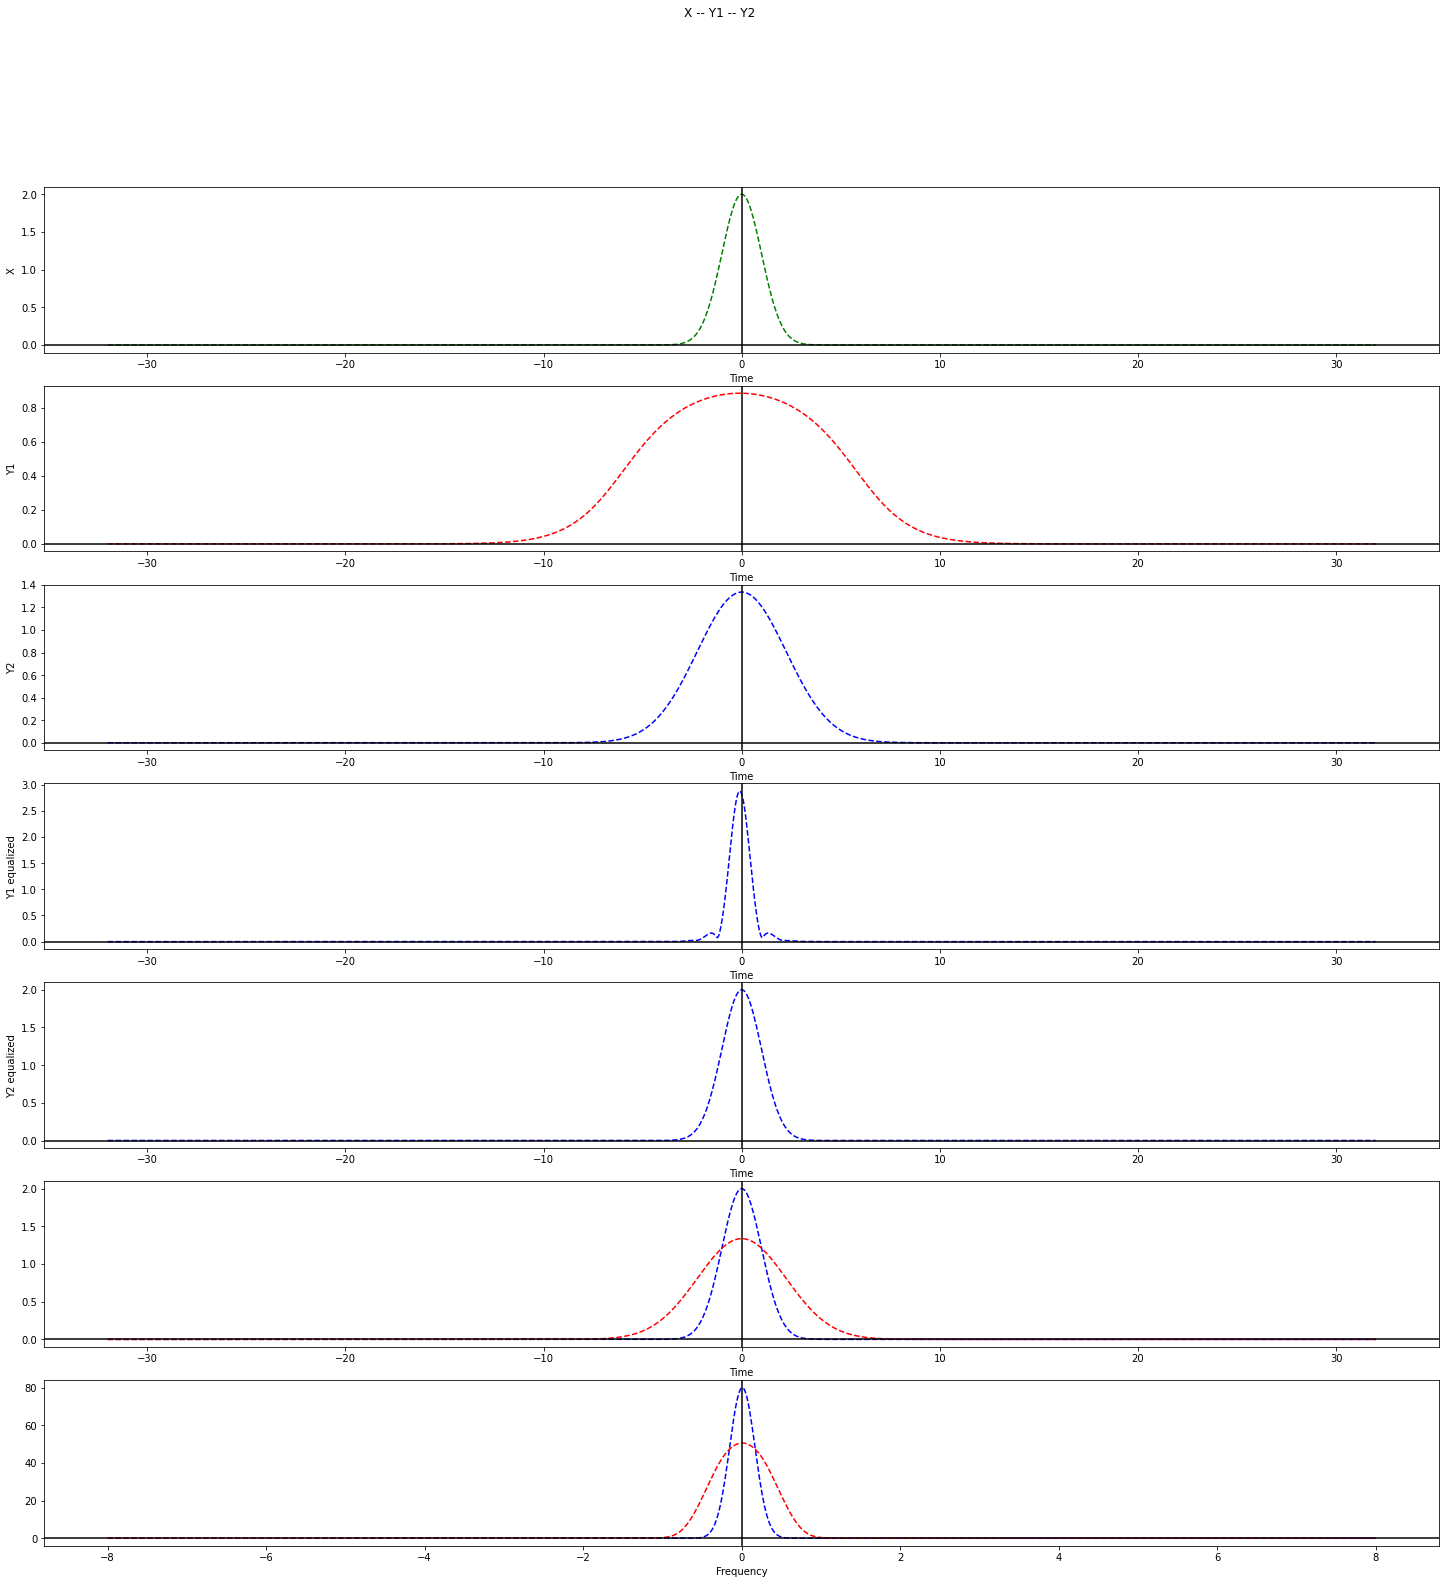

In [20]:
t=None
test(t, parameters)

## **Data generation**

In [ ]:
# CUDA : Nicolas boucher

In [ ]:
nbrOfObservations = 30000
batch_size_gen = 5000
index_start = 1000
#X, y = generateDataset(nbrOfObservations, parameters, isGaussian=0)
X, y = generateDataset(nbrOfObservations, parameters, batch_size_gen, index_start, isGaussian=False)

  0%|          | 1/30001 [00:00<1:01:26,  8.14it/s]

[INFO] Generating the dataset...


 17%|█▋        | 5001/30001 [10:04<16:41:40,  2.40s/it]

[INFO] Saved generated data index  1000


 33%|███▎      | 10001/30001 [20:04<13:01:01,  2.34s/it]

[INFO] Saved generated data index  1001


 50%|█████     | 15001/30001 [30:05<9:40:12,  2.32s/it]

[INFO] Saved generated data index  1002


 67%|██████▋   | 20001/30001 [40:03<6:27:30,  2.33s/it]

[INFO] Saved generated data index  1003


 83%|████████▎ | 25001/30001 [50:03<3:16:33,  2.36s/it]

[INFO] Saved generated data index  1004


 84%|████████▍ | 25269/30001 [50:36<09:15,  8.52it/s]

In [ ]:
index = 0

In [ ]:
X

array([[ 7.07802981e-16+4.45986157e-16j,  1.35400101e-02+1.09965064e-02j,
         2.66271906e-02+2.16276221e-02j, ...,
         1.21889076e-02+1.10403111e-02j,  6.20905046e-03+5.62112766e-03j,
        -2.94332104e-16-2.61679829e-16j]])

In [ ]:
y

array([[-0.07809775+0.03115892j, -0.07324626+0.02203205j,
        -0.06518009+0.01344971j, ..., -0.07080212+0.05662095j,
        -0.0759397 +0.04938694j, -0.07868082+0.04047913j]])

In [ ]:
# Signal : X
X_ = np.absolute(np.squeeze(X[index]))

# NNet generator : y
y_ = np.absolute(np.squeeze(y[index]))

print(X_)
print(y_)

[8.36593517e-16 1.74429076e-02 3.43039548e-02 ... 1.64456054e-02
 8.37552290e-03 3.93837174e-16]
[0.08408411 0.07648808 0.06655328 ... 0.090658   0.09058647 0.08848294]


In [ ]:
np.savez_compressed('gdrive/My Drive/DL_913/data/data_2.npz', X=X, y=y)

### **Generated Data Visualization**

In [ ]:
X.shape

(1, 1024)

[channel] qzt : [-0.07492096+0.04821525j -0.07615361+0.04113522j -0.07439759+0.03238756j
 ... -0.05472472+0.06071314j -0.06401376+0.0587019j
 -0.0708201 +0.05429713j]
[channel] qzf : [-15.47261423 -63.50699263j  29.04099519  -0.63976669j
 -25.77564873 +62.15538594j ... -69.26404753+129.41203819j
  50.070414  -133.16889053j -13.215128  +112.87295538j]
[Equalizer] qzte : [6.38463060e-10+6.34015263e-09j 1.35400037e-02+1.09965060e-02j
 2.66271888e-02+2.16276251e-02j ... 1.21888887e-02+1.10403053e-02j
 6.20904793e-03+5.62113336e-03j 4.74355477e-09+1.24854127e-09j]
[Equalizer] qzfe : [-15.47261423 -63.50699263j  29.03348014  -0.91963804j
 -23.36080349 +63.10268559j ... -57.79189947+134.92620303j
  44.90040023-134.99982897j -12.12662925+112.99508187j]
[Equalizer] qzte : [0.01946577+0.01395868j 0.02918615+0.02278483j 0.03947235+0.03467298j ...
 0.00717964+0.00242202j 0.01296972-0.00113592j 0.01552858+0.00429394j]
[Equalizer] qzfe : [ 171.89145914+67.01648754j -192.17371039-46.88502194j
  195.4

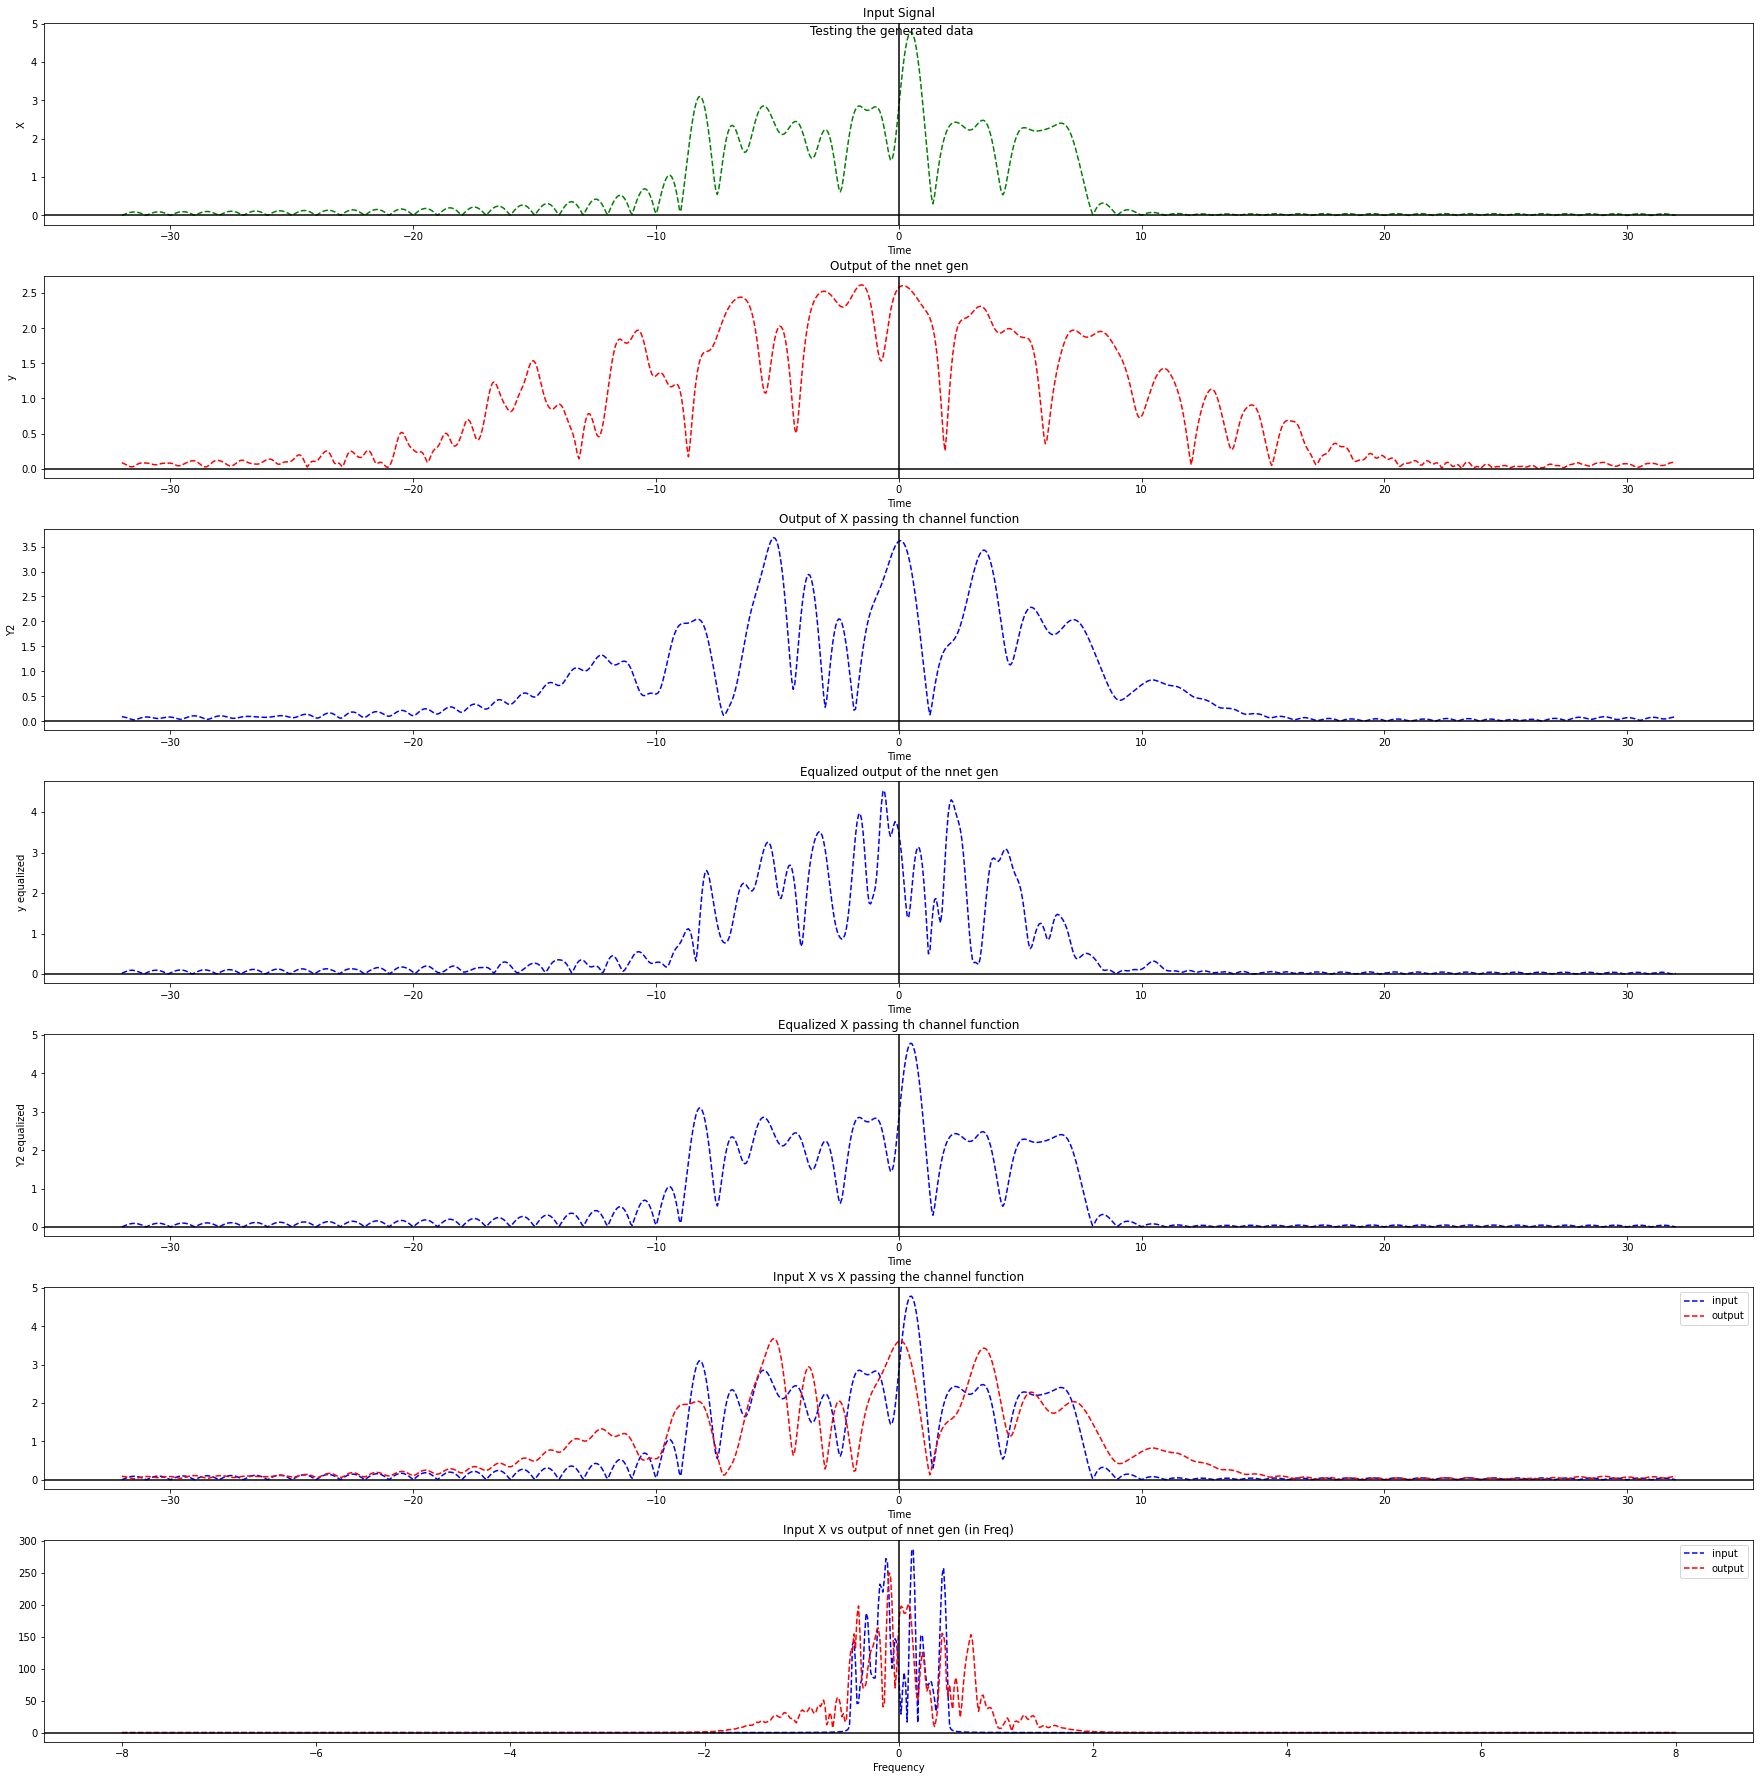

In [ ]:
test_generated(X, y, index, parameters)

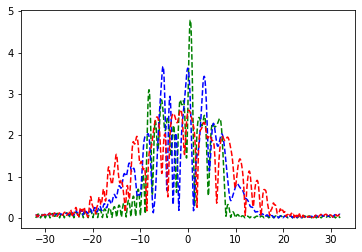

In [ ]:
from matplotlib.pyplot import plot
from numpy import abs
from numpy.fft import fft, ifft, fftshift 
t = parameters.t
#plot(t, np.squeeze(abs(X)))


f = parameters.f 
w = fftshift(2*np.pi*f)
Y1 = ifft(fft(X)*np.exp(1j*w**2))
Y2 = nnetGen.nnet_gen_old(X) 
plot(t, np.squeeze(abs(X)), 'g--')
plot(t, np.squeeze(abs(Y1)), 'b--')
plot(t, np.squeeze(abs(Y2)), 'r--')

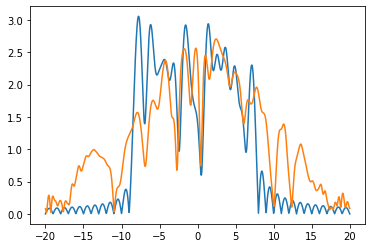

In [ ]:
plot(t, np.squeeze(abs(X)))
plot(t, np.squeeze(abs(y)))

In [ ]:
np.linalg.norm(X) - np.linalg.norm(Y1)

0.0

[]

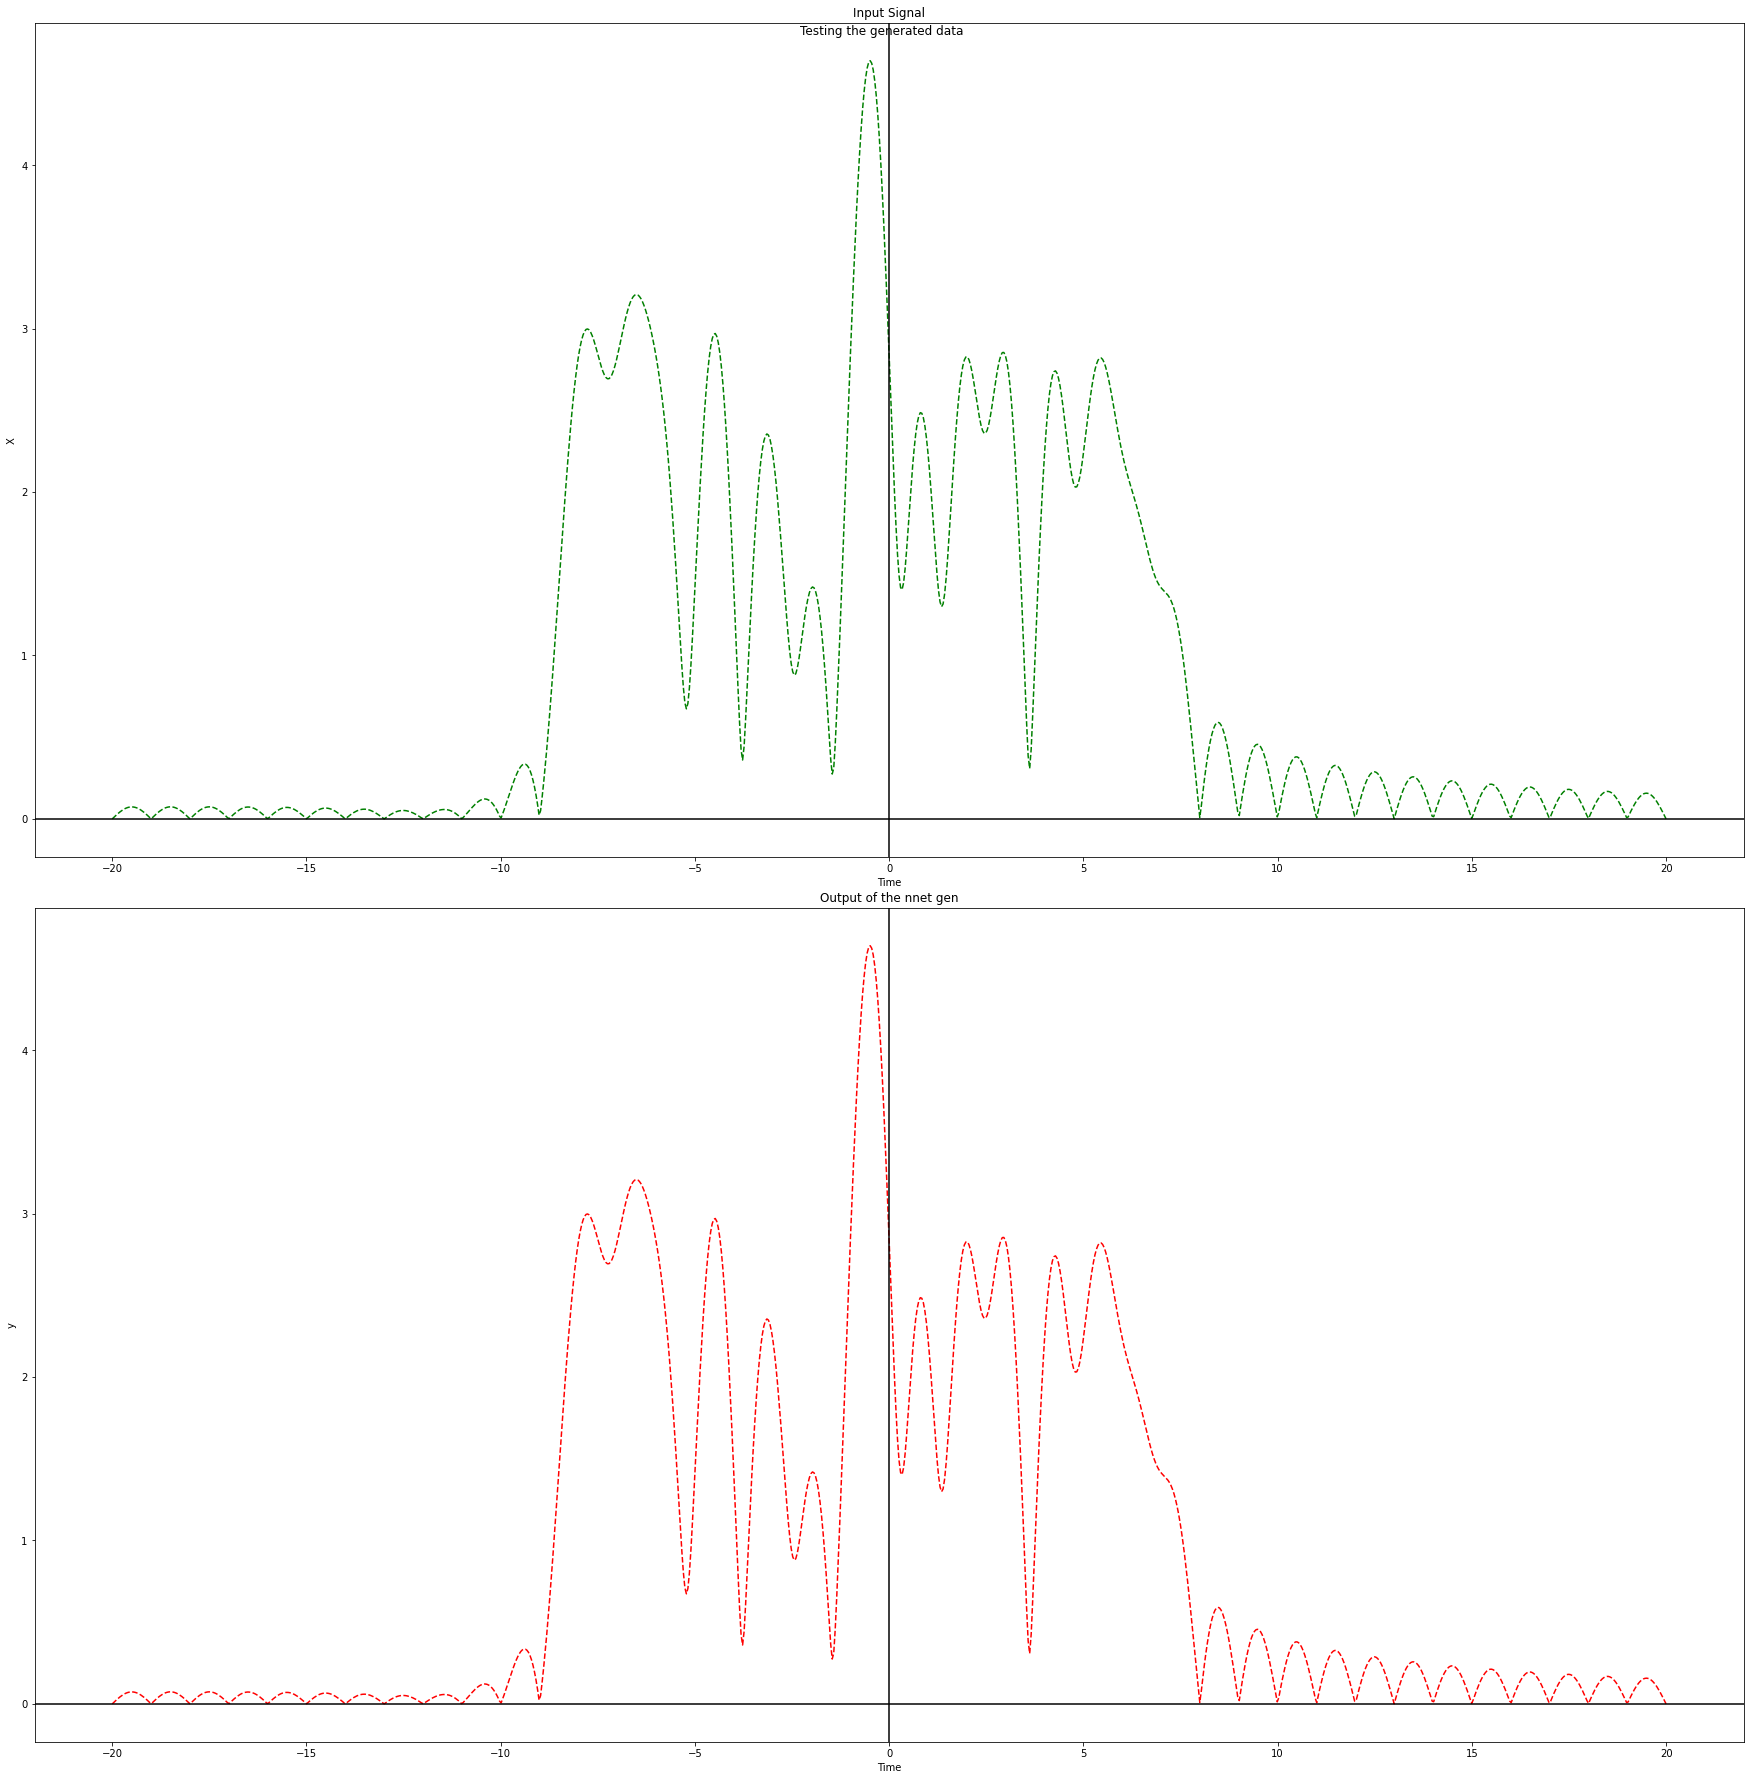

In [ ]:
    #Plots
    
    fig, (ax1, ax2) = plt.subplots(2, figsize = (25, 25))
    #fig = plt.figure(figsize=(25, 25))
    fig.tight_layout(pad=3.0)
    # Input signal
    fig.suptitle('Testing the generated data')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('X')
    ax1.set_title("Input Signal")
    ax1.plot(parameters.t, np.squeeze(np.abs(X[index])), 'g--')
    ax1.axhline(y=0, color='black')
    ax1.axvline(x=0, color='black')

    # NNet generator
    ax2.set_xlabel('Time')
    ax2.set_ylabel('y')
    ax2.set_title("Output of the nnet gen")
    ax2.plot(parameters.t, np.squeeze(np.abs(y[index])), 'r--')
    ax2.axhline(y=0, color='black')
    ax2.axvline(x=0, color='black')

    plt.plot()

In [ ]:
X

array([[3.29636906e-16+3.39175889e-16j, 1.58647648e-02+7.93419875e-03j,
        3.15711029e-02+1.57887399e-02j, ...,
        1.71814998e-02+2.11290093e-02j, 8.64419257e-03+1.06153042e-02j,
        2.89160310e-16-3.61148686e-16j]])

In [ ]:
y

array([[ 1.03890746e-15-4.47881917e-16j,  1.88427218e-03+1.76377944e-02j,
         3.68469891e-03+3.51061510e-02j, ...,
        -8.53461297e-03+2.58611553e-02j, -4.26686907e-03+1.30077122e-02j,
        -6.71570073e-15-4.21966775e-15j]])

In [ ]:
np.sum(X[index]-y[index])

(-114.45473872655651-116.72053936808574j)

In [ ]:
np.sum(y[index])

(114.95529460501282+41.75022013827219j)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


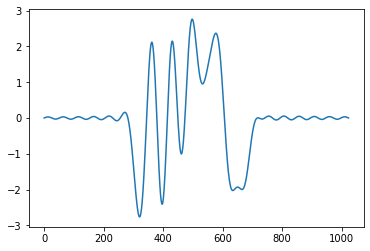

In [ ]:
plt.plot(X[index])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


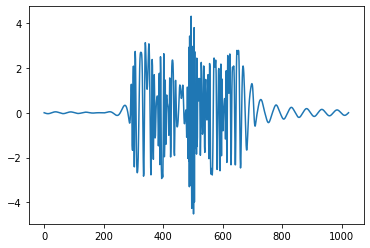

In [ ]:
plt.plot(y[index])

## **Data import and preparation**

In [ ]:
import time

In [ ]:
d1= load('gdrive/My Drive/DL_913/data/data_1_90K_P6e-2_P5e-2_P2.6e-2.npz')
d2= load('gdrive/My Drive/DL_913/data/data_5_100K_P2.6e-2.npz')
d3= load('gdrive/My Drive/DL_913/data/25K.npz')

In [ ]:
t1 = time.time()

X = np.concatenate([d1['X'], d2['X'], d3['X']])
y = np.concatenate([d1['y'], d2['y'], d3['y']])

t2 = time.time()
print("Toral time to unpack X and y is : ", t2-t1, " seconds.")

Toral time to unpack X and y is :  146.3771104812622  seconds.


In [ ]:
"""
d4= load('gdrive/My Drive/DL_913/data/215K.npz')

file_saved_name = "gdrive/My Drive/DL_913/data/215K.npz"
np.savez_compressed(file_saved_name, X=X, y=y)

"""

In [ ]:
d2= load('gdrive/My Drive/DL_913/data/data_5_100K_P2.6e-2.npz')

In [ ]:
t1 = time.time()

X = d2['X']
y = d2['y']

t2 = time.time()
print("Toral time to unpack X and y is : ", t2-t1, " seconds.")

Toral time to unpack X and y is :  48.80562210083008  seconds.


In [ ]:
X.shape

(100000, 1024)

In [ ]:
index = 5900

[channel] qzt : [-0.00575126-0.06344845j -0.00483003-0.06634428j -0.00367013-0.06662164j
 ... -0.00880019-0.04211595j -0.00804212-0.05117818j
 -0.00691447-0.05825119j]
[channel] qzf : [-32.39439218-143.72025812j   3.29253553+159.75269741j
  24.35733726-156.71421612j ...  51.47961418 -10.25767067j
 -58.7529084  -49.71877712j  51.65450103+106.02690487j]
[Equalizer] qzte : [-5.61705038e-09+8.50784737e-09j -7.79731073e-03+5.97211037e-03j
 -1.53264309e-02+1.17569170e-02j ... -1.69692460e-02-1.17932070e-03j
 -8.63165353e-03-5.96212750e-04j  5.82052240e-10-5.15339049e-09j]
[Equalizer] qzfe : [-32.39439218-143.72025812j   4.83210088+159.71354333j
  18.29890893-157.53658415j ...  50.39737157 -14.67908112j
 -60.62559055 -47.41728392j  52.67400355+105.52412702j]
[Equalizer] qzte : [-0.01030368+0.01113193j -0.015057  +0.01466093j -0.02235762+0.01759765j
 ... -0.00781525+0.00306796j -0.00359162+0.00777779j
 -0.00514758+0.00862275j]
[Equalizer] qzfe : [  26.94092575 -8.71297023j   28.42078791+41.778

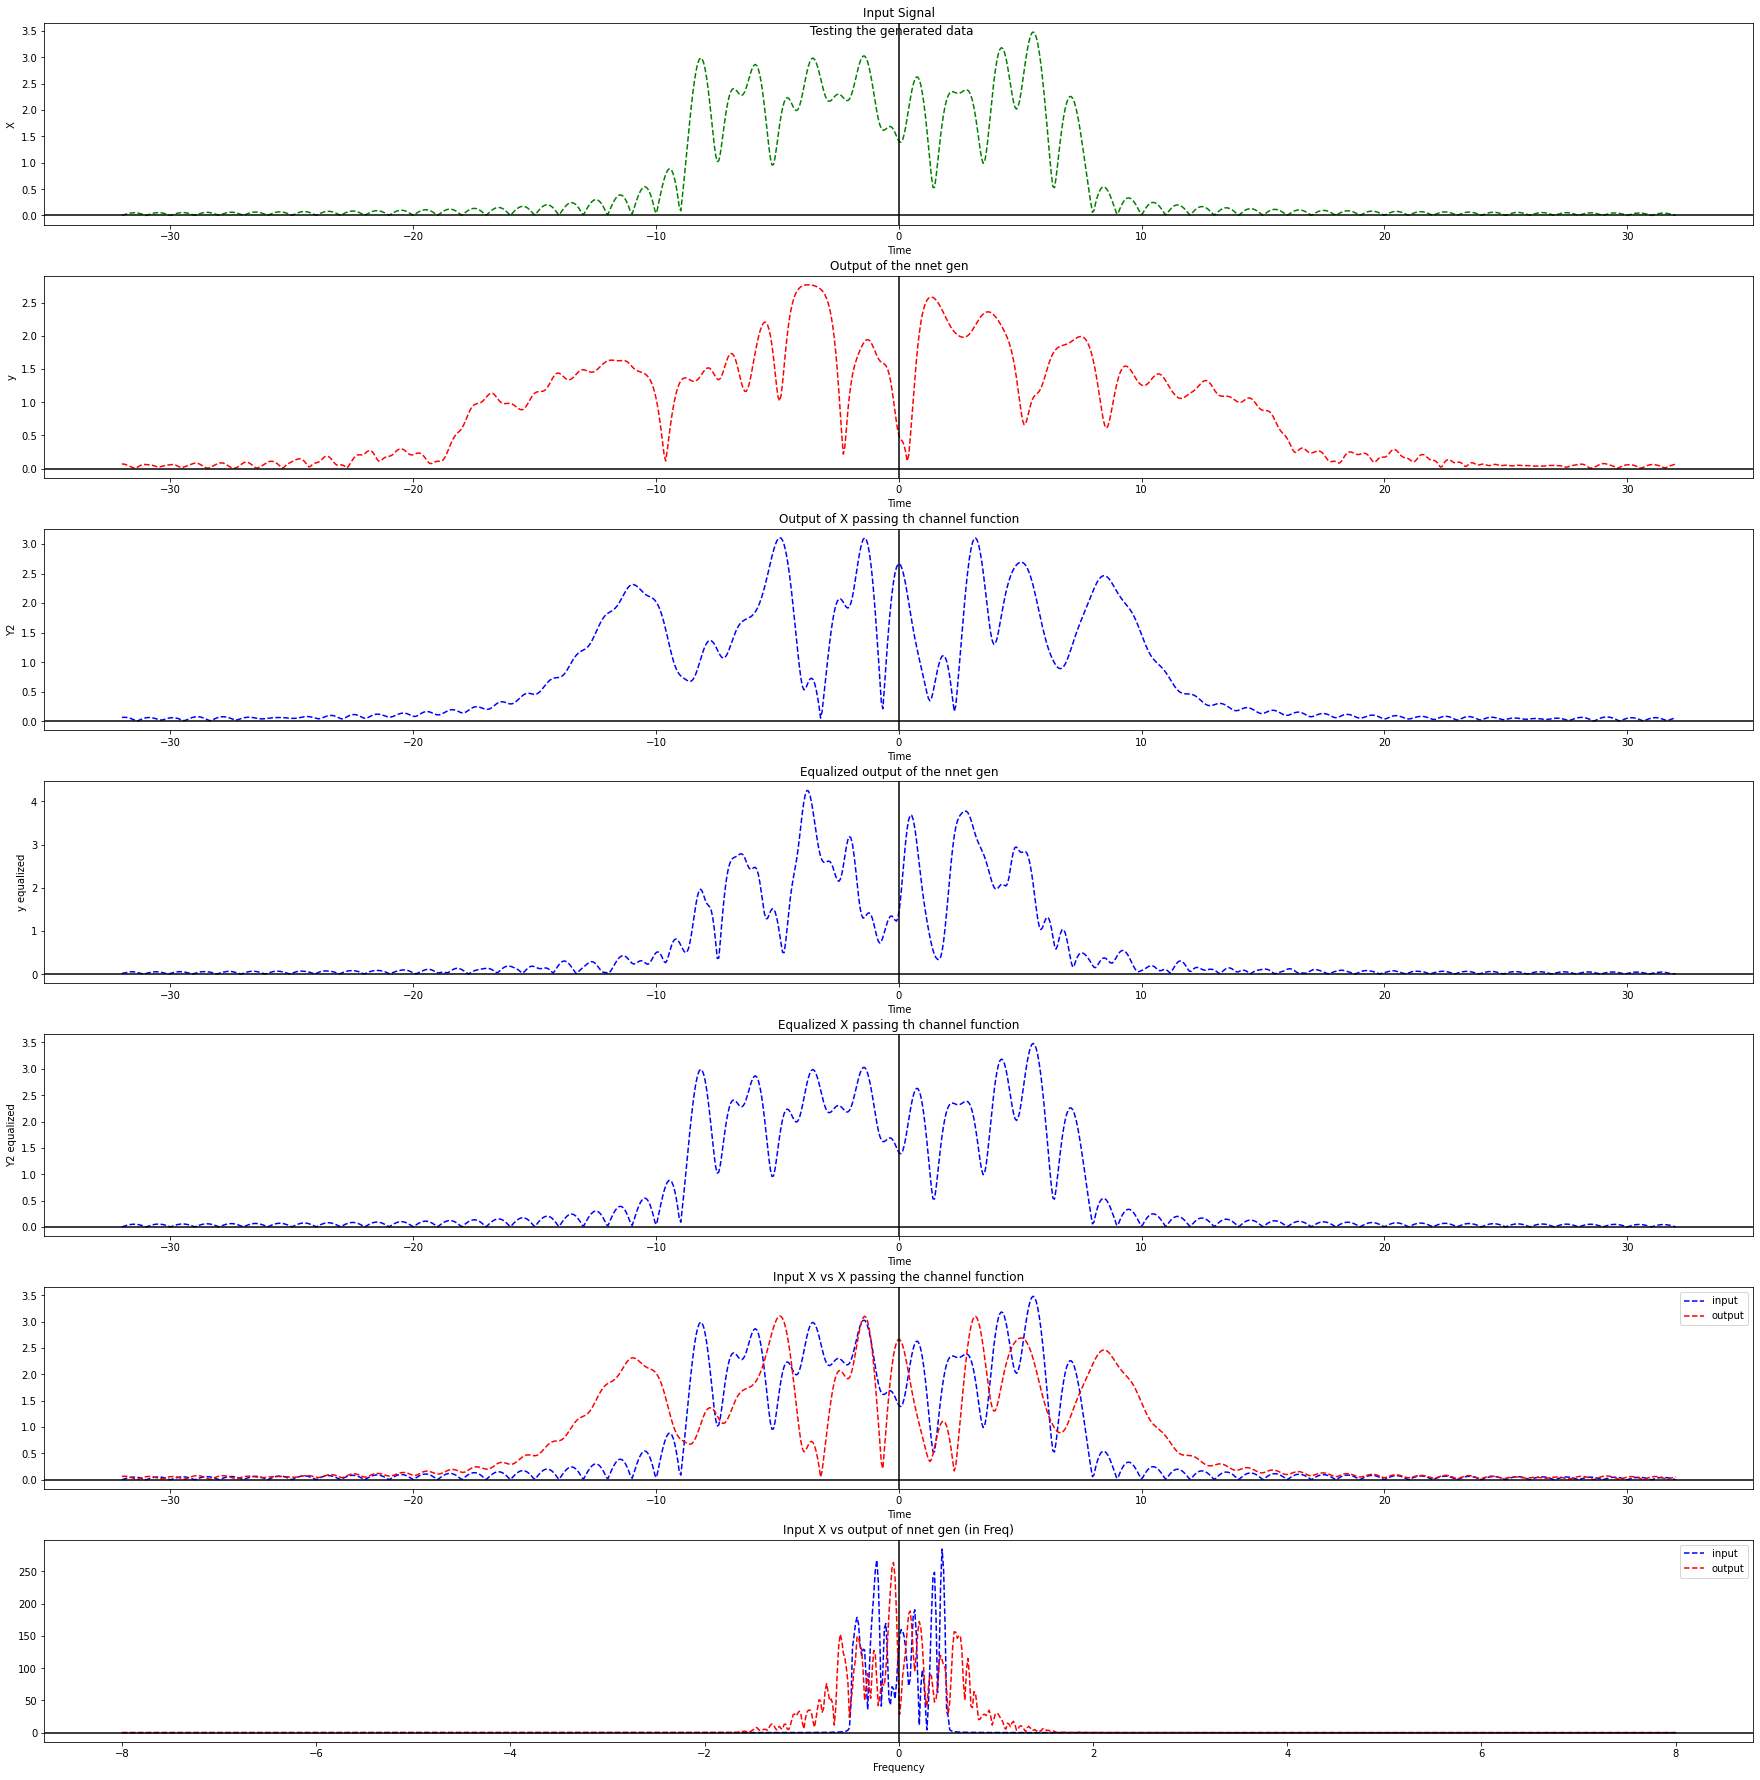

In [ ]:
test_generated(X, y, index, parameters)

**Checking that the real to complex function is reversible**

In [ ]:
y_ = y[index].reshape(-1,1)

In [ ]:
y_.shape

(1024, 1)

In [ ]:
vect_real = fromComplexToReal(y_.T)
vect_im = fromRealToComplex(vect_real)

100%|██████████| 1/1 [00:00<00:00, 248.96it/s]


 [INFO] {fromComplexToReal} runing...

 [INFO] vect_real.shape :  (1, 2048)
 [INFO] {fromComplexToReal} vect_real.shape :  (1, 2048)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)


In [ ]:
y_

array([[-0.0022698 -0.06922906j],
       [ 0.00060403-0.06830669j],
       [ 0.00238346-0.06372847j],
       ...,
       [-0.00809434-0.05367865j],
       [-0.00724792-0.06048141j],
       [-0.00510639-0.06623249j]])

In [ ]:
vect_real_ = vect_real.reshape(-1,1)
vect_real_

array([[-0.0022698 ],
       [-0.06922906],
       [ 0.00060403],
       ...,
       [-0.06048141],
       [-0.00510639],
       [-0.06623249]])

In [ ]:
vect_im_ = vect_im.reshape(-1,1)
vect_im_

array([[-0.0022698 -0.06922907j],
       [ 0.00060403-0.06830669j],
       [ 0.00238346-0.06372847j],
       ...,
       [-0.00809434-0.05367865j],
       [-0.00724792-0.06048141j],
       [-0.0051064 -0.06623249j]], dtype=complex64)

In [ ]:
"""
#check if pandas added index column
if df.shape[1]%2 !=0 :
  df = df.drop(columns=df.columns[0])
  print("New shape : ",df.shape)
else :
  print("Shape : ",df.shape)
"""

'\n#check if pandas added index column\nif df.shape[1]%2 !=0 :\n  df = df.drop(columns=df.columns[0])\n  print("New shape : ",df.shape)\nelse :\n  print("Shape : ",df.shape)\n'

## **DataFrame init**

### **Bits dataset**

In [ ]:
# if scaling=True, we are using min-max scaler
df = prepareDataFrameBits(X, y)

{prepareDataFrame} df_.shape :  (20000, 128)


In [21]:
# if scaling=True, we are using min-max scaler
df = prepareDataFrame(X, y, scaling=False)

  0%|          | 100/50000 [00:00<00:50, 997.31it/s]


 [INFO] {fromComplexToReal} runing...

 [INFO] vect_real.shape :  (50000, 2048)


100%|██████████| 50000/50000 [00:48<00:00, 1027.98it/s]


 [INFO] {fromComplexToReal} vect_real.shape :  (50000, 2048)


  0%|          | 101/50000 [00:00<00:49, 1007.23it/s]


 [INFO] {fromComplexToReal} runing...

 [INFO] vect_real.shape :  (50000, 2048)


100%|██████████| 50000/50000 [00:48<00:00, 1029.86it/s]


 [INFO] {fromComplexToReal} vect_real.shape :  (50000, 2048)
{prepareDataFrame} df_.shape :  (50000, 4096)


In [22]:
df

0             1         2     ...      4093      4094      4095
18664  2.927091e-16  3.585518e-16  0.005463  ...  0.024087 -0.076377  0.018744
5121  -1.873507e-16 -2.053594e-16 -0.016177  ... -0.095558  0.082978 -0.087624
9085  -2.547724e-16  1.472631e-16 -0.014337  ... -0.105839 -0.012609 -0.106103
25257 -3.299975e-16  3.862868e-16 -0.013043  ... -0.093014 -0.019598 -0.089512
7206  -6.889599e-16 -3.970519e-16 -0.006794  ... -0.028133  0.066617 -0.031159
...             ...           ...       ...  ...       ...       ...       ...
28624  7.421745e-16 -2.132093e-16  0.023309  ...  0.147263 -0.054350  0.144090
45837  4.760344e-16  3.355679e-16  0.000498  ...  0.007101 -0.048160  0.013115
12069  4.287730e-16  3.255626e-16  0.005762  ...  0.010160 -0.088566  0.012416
43313  7.944374e-17  2.753162e-16 -0.009821  ... -0.088374 -0.033066 -0.086223
5067  -6.528783e-16  1.102882e-16 -0.009822  ... -0.045500  0.095779 -0.039018

[50000 rows x 4096 columns]

In [ ]:
# if scaling=True, we are using min-max scaler
df_minmax = prepareDataFrame(X, y, scaling=True)

In [ ]:
X

array([[ 4.90221168e-17+3.39543673e-17j, -8.39662676e-04-1.15008043e-02j,
        -1.63946017e-03-2.26019967e-02j, ...,
        -1.51528465e-02-2.31280629e-02j, -7.70139127e-03-1.17678497e-02j,
        -1.47151782e-16-4.10819844e-16j],
       [ 1.02518200e-16-2.78640135e-16j, -1.32982548e-02-1.09380970e-02j,
        -2.61442298e-02-2.15202720e-02j, ...,
        -2.12658576e-02-3.31804671e-03j, -1.08215904e-02-1.69607094e-03j,
        -5.61563065e-16+7.14499462e-17j],
       [-6.23684180e-17-4.34899445e-16j,  1.47489903e-02-3.47717982e-03j,
         2.89943314e-02-6.83335758e-03j, ...,
         2.66872692e-02-9.89520493e-03j,  1.35782438e-02-5.03165709e-03j,
         5.25043993e-16+4.17226806e-16j],
       ...,
       [-1.67143489e-17+7.98249810e-18j, -1.20725005e-02-4.74978120e-04j,
        -2.37441421e-02-9.45519054e-04j, ...,
        -6.98966891e-03+6.90328878e-03j, -3.56514014e-03+3.50994427e-03j,
        -3.22388354e-16+2.13734727e-16j],
       [-1.08290558e-16+3.54103314e-16j, -5.

In [ ]:
df_ori

array([[0.64842439, 0.58212188, 0.4678966 , ..., 0.45530946, 0.36078248,
        0.46133427],
       [0.36653013, 0.58394051, 0.37807275, ..., 0.37499626, 0.39613467,
        0.37605114],
       [0.70765167, 0.43894063, 0.48279724, ..., 0.50170285, 0.58641736,
        0.50283197],
       ...,
       [0.63087019, 0.5499106 , 0.75912556, ..., 0.71595913, 0.34441611,
        0.72844624],
       [0.34631263, 0.53322415, 0.43907489, ..., 0.42356085, 0.44456405,
        0.4224225 ],
       [0.59005923, 0.55646001, 0.66473762, ..., 0.60064399, 0.26126587,
        0.60298248]])

In [ ]:
type(df_ori)

numpy.ndarray

In [ ]:
file_saved_name = "gdrive/My Drive/DL_913/data/100K_scaled.npz"
np.savez_compressed(file_saved_name, data=df_ori)

In [ ]:
# save the dataframe in gzip compressed format
df.to_csv('gdrive/My Drive/DL_913/data/100K_scaled.csv.gz', compression='gzip')

### **z-scalar**

In [ ]:
from scipy.stats import zscore

In [ ]:
df_zsc = df.copy()

In [ ]:
df_zsc = df_zsc.apply(zscore)

In [ ]:
df_zsc.head()

0         1         2     ...      4093      4094      4095
58497 -0.966392 -1.331134  0.372898  ...  0.538723  1.297372  0.555587
67738  0.093541  1.302860 -0.386722  ... -0.463409 -0.369064 -0.473503
88742 -1.040597 -0.772153 -2.131253  ... -1.811732  1.569935 -1.839048
5776  -0.930407  0.781714 -0.000566  ... -0.077880  0.172883 -0.086632
96132  1.709785 -0.078161  1.647119  ...  1.472392 -0.657421  1.467988

[5 rows x 4096 columns]

### **MaxAbsScaler**

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
df_minmax = df.copy()

In [ ]:
maxAbsScaler = MaxAbsScaler()

In [ ]:
df_minmax = maxAbsScaler.fit_transform(df_minmax)
df_minmax = pd.DataFrame(df_minmax)

In [ ]:
df_minmax.head()

0         1         2     ...      4093      4094      4095
0  0.172199 -0.556263 -0.230978  ... -0.058216  0.239119 -0.039384
1  0.333240 -0.353891  0.006698  ...  0.146331  0.555396  0.133480
2  0.107624 -0.319691  0.068790  ...  0.163089  0.390330  0.163779
3  0.029822  0.032939 -0.192310  ... -0.123483  0.196740 -0.121128
4  0.469046  0.201927  0.439962  ...  0.368508 -0.098206  0.385331

[5 rows x 4096 columns]

### **StandardScaler**

In [ ]:
# demonstrate data standardization with sklearn
from sklearn.preprocessing import StandardScaler

In [ ]:
df_stc = df.copy()

In [ ]:
# create scaler
scaler = StandardScaler()
# fit and transform in one step
df_stc = scaler.fit_transform(df_stc)

In [ ]:
df_stc = pd.DataFrame(df_stc)
df_stc.head()

0         1         2     ...      4093      4094      4095
0 -0.044834 -1.033292  0.256854  ...  0.270893  0.523199  0.247409
1 -1.413856 -0.368256 -0.659653  ... -0.520670  1.351533 -0.548003
2  0.742282 -0.830581 -1.049869  ... -0.601597  0.298000 -0.605057
3 -0.438923  1.105320  0.174195  ...  0.017804 -0.532531  0.042240
4  2.135357 -1.319752  0.407525  ...  0.682576  0.792224  0.637713

[5 rows x 4096 columns]

### **MinMax Scaler**

In [ ]:
df

0             1         2     ...      4093      4094      4095
31098 -6.883234e-16  3.367791e-16 -0.007202  ... -0.060048 -0.064618 -0.059984
51211  7.515545e-18  4.623367e-17 -0.000791  ...  0.001228 -0.035742  0.000899
90096 -4.708891e-16 -8.225122e-17 -0.010137  ... -0.089666 -0.048159 -0.087789
89342 -7.143867e-16 -2.434034e-16 -0.008408  ... -0.017178  0.124506 -0.020073
69685 -1.482731e-16 -5.738421e-17 -0.010871  ... -0.058116  0.098227 -0.059044
...             ...           ...       ...  ...       ...       ...       ...
19144 -5.680791e-16 -6.365099e-18 -0.011780  ... -0.092698 -0.071108 -0.088150
98718  1.622903e-16 -5.215831e-16 -0.016331  ... -0.066173  0.150483 -0.067544
88209 -1.866029e-16  4.124278e-16 -0.014667  ... -0.107715  0.016207 -0.101940
80795 -4.262037e-16  7.104575e-16  0.006464  ...  0.046663 -0.042068  0.046353
37613 -8.359635e-16 -6.229233e-16 -0.034091  ... -0.191117  0.175982 -0.190077

[100000 rows x 4096 columns]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df_minmax = df.copy()

In [ ]:
scaler = MinMaxScaler()

In [ ]:
df_minmax = scaler.fit_transform(df_minmax)

In [ ]:
df_minmax = pd.DataFrame(df_minmax)
df_minmax.head()

0         1         2     ...      4093      4094      4095
0  0.241797  0.595364  0.415496  ...  0.414755  0.388797  0.414204
1  0.502003  0.490342  0.478180  ...  0.494778  0.430865  0.497080
2  0.323106  0.443900  0.386793  ...  0.376074  0.412775  0.376354
3  0.232051  0.385649  0.403706  ...  0.470741  0.664320  0.468533
4  0.443747  0.452888  0.379620  ...  0.417277  0.626036  0.415483

[5 rows x 4096 columns]

## **Train & Test split**

In [ ]:
# bits data
withReshape = True
ts = 0.35
X_train, X_test, y_train, y_test = prepareTrainAndTestDataBits(df, withReshape, ts)

[INFO] - {prepareTrainAndTestDataBits} converting from pandas to numpy...
(20000, 64)
(20000, 64)
(13000, 64, 1)
(13000, 64, 1)
(7000, 64, 1)
(7000, 64, 1)


In [ ]:
withReshape = True
ts = 0.35
X_train, X_test, y_train, y_test = prepareTrainAndTestData(df, withReshape, ts)

In [ ]:
x_tr = X_train[0:75, :]
x_te = X_test[0:25, :]
y_tr = y_train[0:75, :]
y_te = y_test[0:25, :]
y_te.shape

(25, 2048, 1)

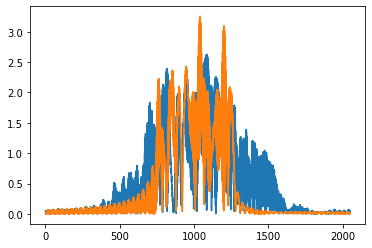

In [ ]:
#df
plt.plot(np.abs(X_train[0]))
plt.plot(np.abs(y_train[0]))

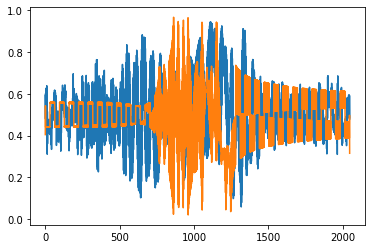

In [ ]:
#df_minmax
plt.plot(np.abs(X_train[0]))
plt.plot(np.abs(y_train[0]))

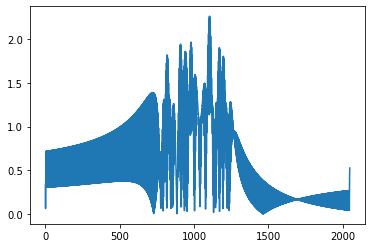

In [ ]:
#df_stc
plt.plot(np.abs(y_test[0]))

In [ ]:
x_ = df.iloc[0:1 , 0:2048]
x_.shape

(1, 2048)

In [ ]:
x_ = fromRealToComplex(x_.to_numpy())

100%|██████████| 1/1 [00:00<00:00, 223.09it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)


[channel] qzt : [-0.06850719-0.05844364j -0.06355199-0.05785731j -0.05605699-0.05502862j
 ... -0.07040196-0.04638047j -0.07244592-0.05252439j
 -0.07158313-0.05664776j]
[channel] qzf : [ 15.6855862  +96.52480273j -23.75239541-124.05264255j
 -13.3708645 +145.02013926j ...  87.64077541 -46.57743083j
 -70.6167814  +62.60463492j  24.62135846 -73.90779766j]
[Equalizer] qzte : [-1.11022302e-15+4.99600361e-16j -7.20190955e-03+1.36110373e-02j
 -1.41595099e-02+2.67596748e-02j ... -8.49732663e-03+2.01593228e-02j
 -4.32684319e-03+1.02600083e-02j  6.66133815e-16+3.33066907e-16j]
[Equalizer] qzfe : [ 15.6855862  +96.52480273j -24.94692844-123.81795173j
  -7.77133174+145.42773879j ...  83.27597622 -53.99513275j
 -68.15129993 +65.27993908j  23.90788142 -74.1416688j ]
[Equalizer] qzte : [-9.37946324e-03+0.01847241j -1.55192419e-02+0.02748124j
 -2.39748068e-02+0.03953324j ... -9.27918070e-05+0.01036485j
  4.68930354e-03+0.01128834j -9.42301854e-04+0.0136611j ]
[Equalizer] qzfe : [  66.98148507+42.686486

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


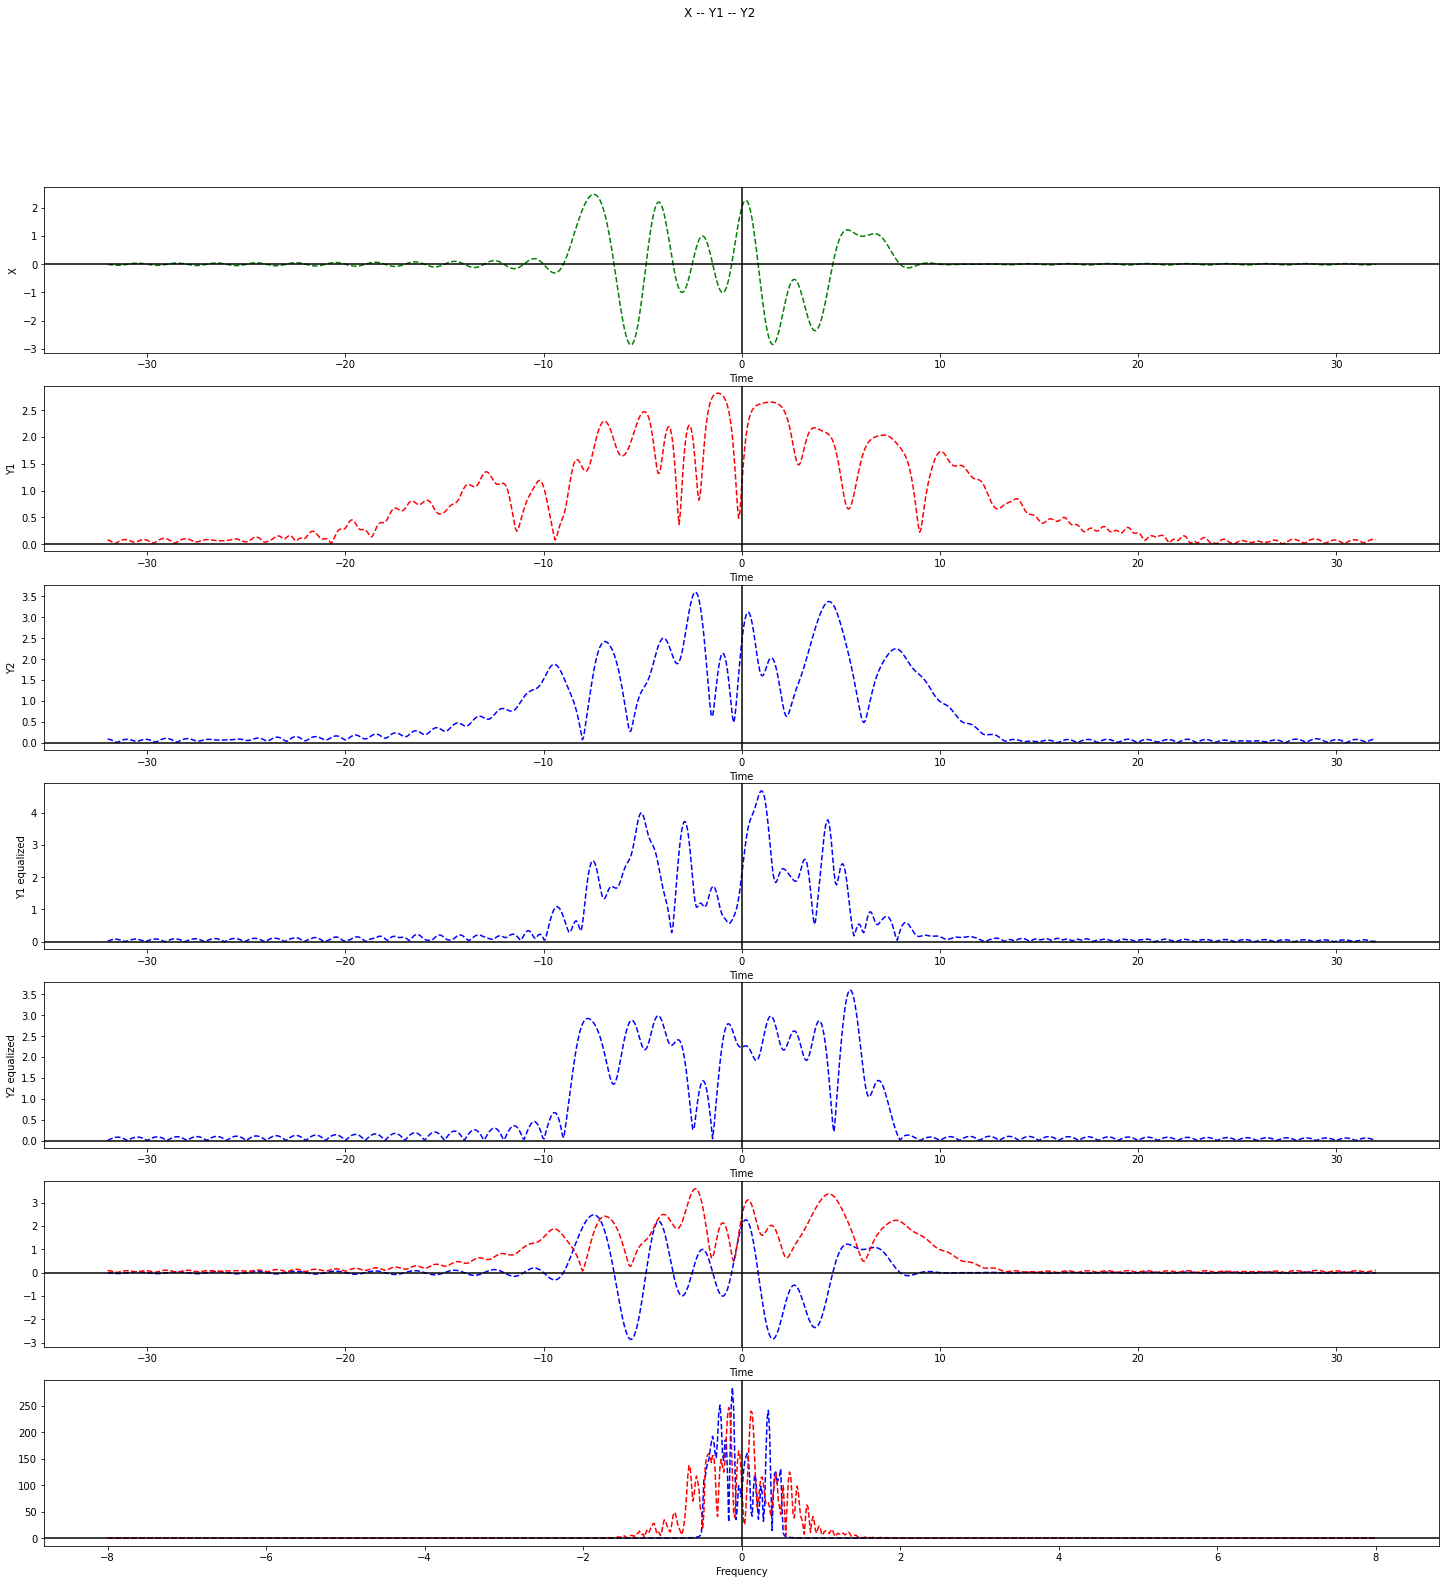

In [ ]:
test(np.squeeze(x_), parameters)

In [ ]:
mid = X_train.shape[1]

In [ ]:
#-----------------------------------------------------------------------------------------#

def test_complex2real(y, index, mid, parameter):


    y__ = y[index-1:index,:mid].reshape(1,-1,1)
    vect_real = fromComplexToReal(y__)
    vect_im = fromRealToComplex(vect_real)
    
    y__ = y__.reshape(-1,1)
    vect_im = vect_im.reshape(-1,1)

    #Plots
    fig = plt.figure(figsize=(15, 15))
    
    # y_test vs y_pred
    ax = fig.add_subplot(111)
    ax.set_xlabel('Time')
    ax.plot(parameter.t, np.squeeze(y__.T), 'b--', label='test')
    ax.plot(parameter.t, np.squeeze(vect_im.T), 'r--', label='predicted')
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')

    plt.show()
    
#-----------------------------------------------------------------------------------------#

def test_real2complex(y, index, mid, parameter):


    y__ = y[index-1:index,:mid].reshape(1,-1,1) 
    vect_im = fromRealToComplex(y__)
    vect_real = fromComplexToReal(vect_im)

    y__ = y__.reshape(-1,1)
    vect_real = vect_real.reshape(-1,1)

    #Plots
    fig = plt.figure(figsize=(15, 15))
    
    # y_test vs y_pred
    ax = fig.add_subplot(111)
    ax.set_xlabel('Time')
    ax.plot(np.squeeze(y__.T), 'b--', label='test')
    ax.plot(np.squeeze(vect_real.T), 'r--', label='predicted')
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')

    plt.show()
    
#-----------------------------------------------------------------------------------------#

In [ ]:
"""
index = 10
mid = df.shape[1] // 2
test_complex2real(y, index, mid, parameters)
"""

'\nindex = 10\nmid = df.shape[1] // 2\ntest_complex2real(y, index, mid, parameters)\n'

100%|██████████| 1/1 [00:00<00:00, 462.28it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromComplexToReal} runing...

 [INFO] vect_real.shape :  (1, 2048)
 [INFO] {fromComplexToReal} vect_real.shape :  (1, 2048)


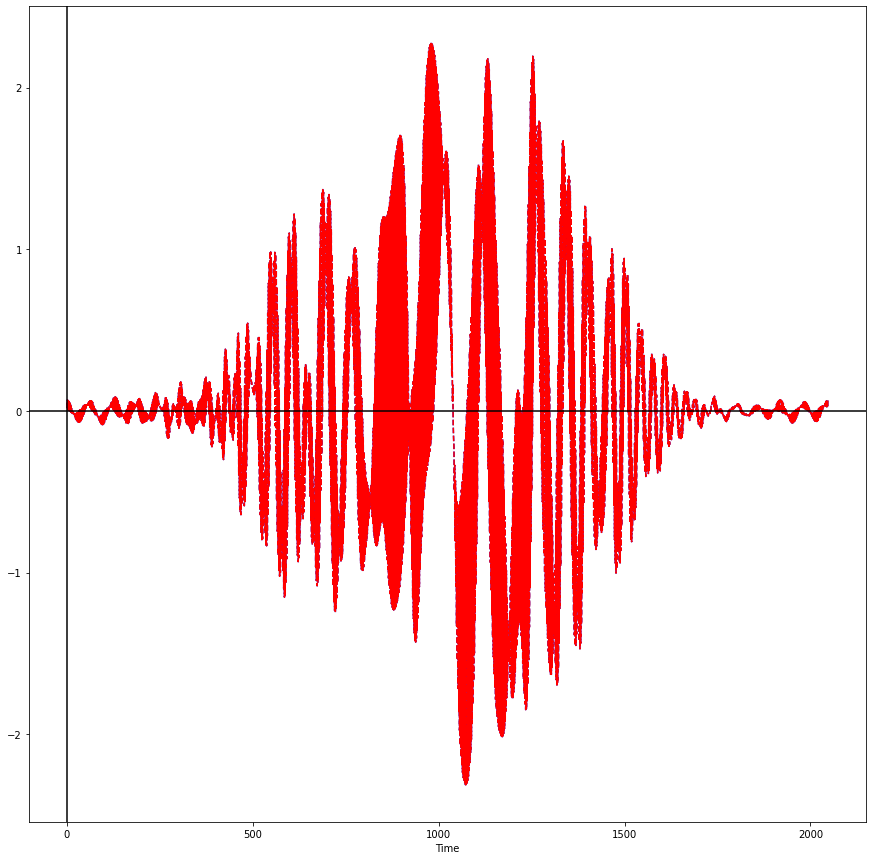

In [ ]:
index = 10
mid = df.shape[1] // 2
test_real2complex(X_test, index, mid, parameters)

# **Model Training & Testing**

In [ ]:
import datetime

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, BatchNormalization, Conv1D, Conv2D, Dense, LSTM, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.callbacks import History 
from keras.utils.vis_utils import plot_model

from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

In [ ]:
#-----------------------------------------------------------------------------------------#

def test_prediction(y_test, y_pred, index, parameter):
    
    print("y_pred : ",y_pred)
    print("y_pred.shape : ",y_pred.shape)

    # Original
    y_ = y_test[index].reshape(1,-1,1)
    y_test_im = fromRealToComplex(y_)
    # Predicted
    y_pred = y_pred.reshape(1,-1,1)
    y_pred_im = fromRealToComplex(y_pred)
    
    y_test_im = np.squeeze(y_test_im)
    y_pred_im = np.squeeze(y_pred_im)

    diff = y_ - y_pred
    diff_im = fromRealToComplex(diff)

    y_ = np.squeeze(y_)
    y_pred = np.squeeze(y_pred)
    diff_im = np.squeeze(diff_im)

    mse_diff = mean_squared_error(y_, y_pred)
    #mse_diff = (1/len(diff))*np.sum((diff**2))

    
    print("\n")
    print("y_test : ", y_)
    print("\n")

    print("y_pred : ", y_pred)
    print("\n")

    print("diff : ", diff)
    print("mse test : ", mse_diff)
    print("\n")

    # Equalizer
    #Y2e, _ = equalizer.equalize(parameter.t, y_test, parameter.z)
    #Y1e, _ = equalizer.equalize(parameter.t, y_pred, parameter.z)

    #Plots

    plt.plot(np.abs(y_pred))
    plt.title("predicted")
    plt.show()

    plt.plot(np.abs(y_test[index_pred]))
    plt.title("test")
    plt.show()
    fig = plt.figure(figsize=(15, 15))
    
    # y_test vs y_pred
    ax = fig.add_subplot(211)
    #ax.set_xlabel('Time')
    ax.plot(y_test[index_pred], 'b--', label='test')
    ax.plot(y_pred, 'r--', label='predicted')
   # ax.plot(parameter.t, y_test_im, 'b--', label='test')
   # ax.plot(parameter.t, y_pred_im, 'r--', label='predicted')
   # ax.plot(parameter.t, diff_im.T, 'g--', label='difference')
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')
    ax.legend()

    """
    ax = fig.add_subplot(212)
    ax.set_xlabel('Time')
    ax.plot(y_, 'b--', label='test')
    ax.plot(y_pred, 'r--', label='predicted')
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')
    """
    """
    y_f = np.fft.fft(y_)
    print("y_f : ", y_f)
    print("y_f.shape : ", y_f.shape)
    y_f = y_f.reshape(1,-1,1)
    print("y_f : ", y_f)
    print("y_f.shape : ", y_f.shape)
    y_f_im = fromRealToComplex(y_f)
    print("y_f_im : ", y_f_im)
    print("y_f_im.shape : ", y_f.shape)

    y_pred_f = np.fft.fft(y_pred)
    print("y_pred_f : ", y_pred_f)
    print("y_pred_f.shape : ", y_pred_f.shape)
    y_pred_f = y_pred_f.reshape(1,-1,1)
    print("y_pred_f : ", y_pred_f)
    print("y_pred_f.shape : ", y_pred_f.shape)
    y_pred_f_im = fromRealToComplex(y_pred_f)
    print("y_pred_f_im : ", y_pred_f_im)
    print("y_pred_f_im.shape : ", y_pred_f_im.shape)

    ax = fig.add_subplot(212)
    ax.set_xlabel('Frequency')
    ax.plot(parameter.f, np.squeeze(y_f_im), 'b--', label='test')
    ax.plot(parameter.f, np.squeeze(y_pred_f_im), 'r--', label='predicted')
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')
    plt.show()
    
    """
    # Fourier Transform
    Xf = fftshift(fft(y_test_im))
    Yf = fftshift(fft(y_pred_im))
    
    plt.xlabel('Frequency')
    plt.plot(parameter.f, np.abs(Xf), 'b--', label='input')
    plt.plot(parameter.f, np.abs(Yf), 'r--', label='output')
    plt.title("Input X vs output of nnet gen (in Freq)")
    plt.show()

    plt.plot(np.squeeze(abs(y_test[index])), 'g--')
    plt.plot(np.squeeze(abs(y_pred)), 'b--')
    plt.show()

    plt.plot(np.squeeze(abs(y_test_im)), 'g--')
    plt.plot(np.squeeze(abs(y_pred_im)), 'b--')
    plt.show()

#-----------------------------------------------------------------------------------------#

def test_predicted(y_test, y_pred, index, parameter):

    #X = X_test[index]

    print("y_pred : ",y_pred)
    print("y_pred.shape : ",y_pred.shape)

    # Original
    y_original = y_test[index].reshape(1,-1,1)
    y_test_im = fromRealToComplex(y_original)

    # Predicted
    y_predicted = y_pred.reshape(1,-1,1)
    y_pred_im = fromRealToComplex(y_predicted)
    
    # Getting rid of one dim
    y_test_im = np.squeeze(y_test_im)
    y_pred_im = np.squeeze(y_pred_im)

    # Compute the difference between the test and predicted data
    diff = y_original - y_predicted
    diff_im = fromRealToComplex(diff)

    y_original = np.squeeze(y_original)
    y_predicted = np.squeeze(y_predicted)
    diff_im = np.squeeze(diff_im)

    """
    # Channel
    Y2, _ = channel.channel(parameter.t, X, parameter.z, parameter.sigma2, parameter.B )#0, 0)

    # Equalizer
    Y2e, _ = equalizer.equalize(parameter.t, Y2, parameter.z)
    Y1e, _ = equalizer.equalize(parameter.t, np.squeeze(y), parameter.z)

    # Fourier Transform
    Xf = fftshift(fft(X))
    Yf = fftshift(fft(y))
    """
    #Plots
    
    fig, (ax1) = plt.subplots(1, figsize = (25, 25))
    fig.tight_layout(pad=3.0)

    # Input signal
    fig.suptitle('Testing the predicted data')

    ax1.set_xlabel('Time')
    ax1.plot(parameter.t, np.abs(y_original), 'b--', label='y_test')
    ax1.plot(parameter.t, np.abs(y_predicted), 'r--', label='y_predicted')
    ax1.set_title("Input signal vs predicted signal.")
    ax1.axhline(y=0, color='black')
    ax1.axvline(x=0, color='black')
    ax1.legend()
    
    plt.show()
    
#-----------------------------------------------------------------------------------------#

def test_ypred(y_pred, parameter):
    

    # Predicted
    y_pred = y_pred.reshape(1,-1,1)
    y_pred_im = fromRealToComplex(y_pred)
    
    y_pred_im = np.squeeze(y_pred_im)

    y_pred = np.squeeze(y_pred)

    print("y_pred_im.shape : ",y_pred_im.shape)
    print("y_pred.shape : ",y_pred.shape)
    print("\n")

    # Equalizer
    #Y2e, _ = equalizer.equalize(parameter.t, y_test, parameter.z)
    #Y1e, _ = equalizer.equalize(parameter.t, y_pred, parameter.z)

    #Plots
    fig = plt.figure(figsize=(15, 15))
    
    # y_test vs y_pred
    ax = fig.add_subplot(211)
    ax.set_xlabel('Time')
    ax.plot(parameter.t, y_pred_im.T, 'r--', label='predicted')
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')
    ax.legend()

    ax = fig.add_subplot(212)
    ax.set_xlabel('Time')
    ax.plot(y_pred, 'r--', label='predicted')
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')

    plt.show()
    
#-----------------------------------------------------------------------------------------#

In [ ]:
#-----------------------------------------------------------------------------------------------------#

def train(model, X_train, X_test, y_train, y_test, Nepochs, batchSize, earlystopping_patience=5) :
  # Fiting the model
  log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

  earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = earlystopping_patience,  
                                        restore_best_weights = True) 
  
  history = History()

  model.fit( X_train, y_train, 
            batch_size = batchSize, 
            epochs = Nepochs, 
            verbose = 1, 
            validation_data =(X_test, y_test), 
            #callbacks =[history, earlystopping, tensorboard_callback])
            callbacks =[history, earlystopping, tensorboard_callback])
  
  return model

#-----------------------------------------------------------------------------------------------------#

def test_model(model, X_test, y_test, history, index_pred, with_error_plots, all_plots=False) :
  with_eval = False
  y_pred = evaluate(model, X_test, y_test, history, index_pred, with_eval, with_error_plots, all_plots)
  return y_pred

#-----------------------------------------------------------------------------------------------------#


def evaluate(model, X_test, y_test, history, index_pred, with_eval, with_error_plots, all_plots=False):

  # evaluating and printing results 
  if with_eval :
    score = model.evaluate(X_test, y_test, verbose = 0) 
    print('Test loss:', score[0]) 
    print('Test accuracy:', score[1]) 

  # Plots
  
  if with_error_plots : 
    plt.plot(history.history['mse'])
    plt.title("mse")
    plt.show()
    plt.plot(history.history['mae'])
    plt.title("mae")
    plt.show()
    plt.plot(history.history['cosine_proximity'])
    plt.title("cosine_proximity")
    plt.show()
    
  # prediction on one element
  X = X_test[index_pred]
  y_pred = model.predict(X)
  print("X_test.shape : ",X_test.shape)
  print("y_test.shape : ",y_test.shape)
  print("X.shape : ",X.shape)
  print("y_pred.shape : ",y_pred.shape)
  print("\n")

  X = X.reshape(-1,1)
  y_pred = y_pred.reshape(-1,1)
  print("After reshaping...")
  print("X.shape : ",X.shape)
  print("y_pred.shape : ",y_pred.shape)

  

  if all_plots:
  
    X_im = fromRealToComplex(X.T)
    y_im = fromRealToComplex(y_pred.T)

    y_qzt, y_qzf = channel.channel(parameters.t, X_im, parameters.z, parameters.sigma02, parameters.B)
    y_gen_equalized_t, y_gen_equalized_f = equalizer.equalize(parameters.t, y_im, parameters.z)
    y_qzt_equalized_t, y_qzt_equalized_f = equalizer.equalize(parameters.t, y_qzt, parameters.z)
    allPlots(y_qzt, y_qzf, y_qzt_equalized_t, y_qzt_equalized_f, y_im, y_gen_equalized_t, y_gen_equalized_f)

  return y_pred

#-----------------------------------------------------------------------------------------------------#

def allPlots(y_qzt, y_qzf, y_qzt_equalized_t, y_qzt_equalized_f, y_pred, y_pred_equalized_t, y_pred_equalized_f):
    
    fig2, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, figsize = (15, 15))
    fig2.tight_layout(pad=7.0)


    ###
    ax1.plot(parameters.t, np.squeeze(y_qzt.real), 'b-')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Abs(y_qzt)")
    ax1.set_title("y_test passed in Channel function - Time plot - Re(y_qzt)")

    ###
    ax2.plot(parameters.f, np.squeeze(np.abs(y_qzf)), 'b-')
    ax2.set_xlabel("Freq")
    ax2.set_ylabel("Abs(y_qzf)")
    ax2.set_title("Equalization of y_test- Freq plot - |y_qzf|")

    ###
    ax3.plot(parameters.t, np.squeeze(np.abs(y_qzt_equalized_t)), 'b-')
    ax3.set_xlabel("Time")
    ax3.set_ylabel("Abs(y_qzt_equalized_t)")
    ax3.set_title("Equalization of y_test input in the Channel - Time plot - |y_qzt_equalized_t|")

    ###
    ax4.plot(parameters.f, np.squeeze(np.abs(y_qzt_equalized_f)), 'b-')
    ax4.set_xlabel("Freq")
    ax4.set_ylabel("Abs(y_qzt_equalized_f)")
    ax4.set_title("Equalization of y_test input in the Channel - Freq plot - |y_qzt_equalized_f|")

    ###
    ax5.plot(parameters.t, np.squeeze(np.absolute(y_pred)), 'b-')
    ax5.set_xlabel("Time")
    ax5.set_ylabel("Abs(y_pred)")
    ax5.set_title("Prediction (y_pred) - Time plot - |y_pred|")

    ###
    ax6.plot(parameters.t, np.squeeze(np.abs(y_pred_equalized_t)), 'b-')
    ax6.set_xlabel("Time")
    ax6.set_ylabel("Abs(y_pred_equalized_t)")
    ax6.set_title("Equalization of prediction (y_pred) - Time plot - |y_pred_equalized_t|")

    ###        
    ax7.plot(parameters.f, np.squeeze(np.abs(y_pred_equalized_f)), 'b-')
    ax7.set_xlabel("Freq")
    ax7.set_ylabel("Abs(y_pred_equalized_t)")
    ax7.set_title("Equalization of prediction (y_pred) - Freq plot - |y_pred_equalized_f|")

    plt.show()

#-----------------------------------------------------------------------------------------------------#

def all_evals(model, index_pred):

  with_error_plots = False
  with_eval = False
  y_pred = evaluate(model, X_test, y_test, history, index_pred, with_eval, with_error_plots)

  X_test_im = goBackToComplexVector(X_test[index_pred])
  y_test_im = goBackToComplexVector(y_test[index_pred])
  y_pred_im = goBackToComplexVector(y_pred)

  plotOne(X_test_im)
  plotTwo(X_test_im, y_pred_im)
  plotTwo(y_test_im, y_pred_im)


#-----------------------------------------------------------------------------------------------------#

def plotResults(X, y_pred):

    y_pred_im = fromRealToComplex(y_pred.T).T
    X = fromRealToComplex(X.T).T

    Xf = np.fft.fftshift(X)
    Yf = np.fft.fftshift(y_pred_im)

    fig3, (ax5) = plt.subplots(1, figsize = (10, 10))
    fig3.tight_layout(pad=7.0)

    ###
    ax5.plot(parameters.f, np.absolute(Xf), 'b-', label='nnet')
    ax5.set_xlabel("Time")
    ax5.set_ylabel("Abs(y_gen)")
    ax5.set_title("NNetGen - Time plot - |y_gen|")

    ###
    ax5.plot(parameters.f, np.squeeze(np.absolute(Yf)), 'r-', label='nnet')
    ax5.set_xlabel("Freq")
    ax5.set_ylabel("Abs(y_gen)")
    ax5.set_title("NNetGen - Freq plot - |y_gen|")

#-----------------------------------------------------------------------------------------------------#

In [ ]:
batch_size = 16
earlystopping_patience = 4
N_output_pred = 1#len(y_train[0])
N_features = len(X_train[0])
N_samples = len(X_train)
N_output = len(y_train[0])
inputShape = (batch_size, N_features, 1)#(N_samples, batch_size, N_features) 
inputShape

(16, 64, 1)

In [ ]:
X_train.shape

(13000, 64, 1)

In [ ]:
X_train.shape[1]

64

In [ ]:
N_output_pred

1

## **CNN-2D**

In [52]:
def plot_transformed_to_img(index_plot):

  plt.imshow(X_train[index_plot][0])
  plt.title("Image on channel 1")
  plt.show()

  plt.imshow(X_train[index_plot][1])
  plt.title("Image on channel 2")
  plt.show()


def test_pred_cnn2D(model, X_test, index_pred):
  # reshaping the data
  x_tester = X_test.reshape(X_test.shape[0], -1, 32,32,2)
  x_test_original = X_test.reshape(X_test.shape[0], 2048,1)

  # making prediction
  y_pred = model.predict(x_tester[index_pred])

  # results
  plt.plot(np.abs(y_test[index_pred]))
  plt.title("Original signal")
  plt.show()

  plt.plot(np.abs(y_pred.T))
  plt.title("Predicted signal")
  plt.show()

  plt.plot(np.abs(y_pred.T), label="predicted")
  plt.plot(np.abs(y_test[index_pred]), label="original")
  plt.title("Predicted signal vs original")
  plt.legend()
  plt.show()

  return y_pred


def test_pred_resnet50(model, X_test, index_pred):
  # reshaping the data
  x_tester = X_test.reshape(X_test.shape[0], -1, 32,32,2)
  x_test_original = X_test.reshape(X_test.shape[0], 2048,1)

  # making prediction
  y_pred = model.predict(x_tester[index_pred])

  # results
  plt.plot(np.abs(y_test[index_pred]))
  plt.title("Original signal")
  plt.show()

  plt.plot(np.abs(y_pred.T))
  plt.title("Predicted signal")
  plt.show()

  plt.plot(np.abs(y_pred.T), label="predicted")
  plt.plot(np.abs(y_test[index_pred]), label="original")
  plt.title("Predicted signal vs original")
  plt.legend()
  plt.show()


In [ ]:
withReshape = True
ts = 0.25
X_train, X_test, y_train, y_test = prepareTrainAndTestData(df, withReshape, ts)

[INFO] - {prepareTrainAndTestData} converting from pandas to numpy...
(100000, 2048)
(100000, 2048)
(75000, 2048, 1)
(75000, 2048, 1)
(25000, 2048, 1)
(25000, 2048, 1)


In [ ]:
# Reshape X to (n_samples, channels, height, width)
X_train = X_train.reshape((X_train.shape[0],2,32,32))
X_test = X_test.reshape((X_test.shape[0],2,32,32))
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

In [ ]:
X_train.shape

(75000, 2, 32, 32)

In [ ]:
n_features = 2048
n_output = 2048

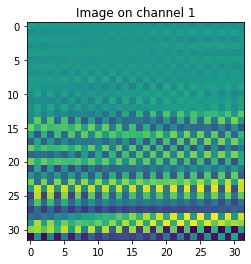

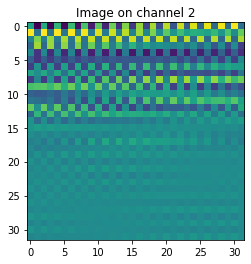

In [ ]:
index_plot = 689
plot_transformed_to_img(index_plot)

###**Keras CNN-2D**

In [ ]:
model = Sequential()

# Define the model ------------------------------------------------------------------------------------------------------#

model.add(Conv2D(256, (3,3), strides=(1, 1), input_shape=(2,32,32), padding='same'))
model.add(Activation('selu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(512, (3,3), strides=(1, 1), padding='same'))
model.add(Activation('selu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(1024, (3,3), strides=(1, 1), padding='same'))
model.add(Activation('selu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('selu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(32))
model.add(Activation('selu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(128))
model.add(Activation('selu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(n_output))
model.add(Activation('selu'))

# Compile the model ------------------------------------------------------------------------------------------------------#
  

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

print(model.optimizer.get_config())
print(model.summary())
print("model.output_shape : ",model.output_shape)

{'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 2, 32, 256)        73984     
_________________________________________________________________
activation_14 (Activation)   (None, 2, 32, 256)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 2, 32, 256)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 2, 32, 256)        1024      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 32, 512)        1180160   
_________________________________________________________________
activation_15 (Activation)   (None, 2, 32, 512)        0      

In [ ]:
epochs = 40
batch_size = 16
# Fiting the model
model = train(model, X_train, X_test, y_train, y_test, epochs , batch_size, earlystopping_patience)

Epoch 1/40
4688/4688 [==============================] - 95s 14ms/step - loss: 0.5822 - mae: 0.3793 - val_loss: 0.5010 - val_mae: 0.3191
Epoch 2/40
4688/4688 [==============================] - 63s 13ms/step - loss: 0.5345 - mae: 0.3455 - val_loss: 0.4914 - val_mae: 0.3124
Epoch 3/40
4688/4688 [==============================] - 63s 13ms/step - loss: 0.5264 - mae: 0.3404 - val_loss: 0.4891 - val_mae: 0.3100
Epoch 4/40
4688/4688 [==============================] - 63s 13ms/step - loss: 0.5215 - mae: 0.3378 - val_loss: 0.4786 - val_mae: 0.3070
Epoch 5/40
4688/4688 [==============================] - 63s 13ms/step - loss: 0.5169 - mae: 0.3362 - val_loss: 0.4698 - val_mae: 0.3046
Epoch 6/40
4688/4688 [==============================] - 63s 13ms/step - loss: 0.5117 - mae: 0.3346 - val_loss: 0.4656 - val_mae: 0.3028
Epoch 7/40
4688/4688 [==============================] - 63s 13ms/step - loss: 0.5086 - mae: 0.3333 - val_loss: 0.4602 - val_mae: 0.2989
Epoch 8/40
4688/4688 [==========================

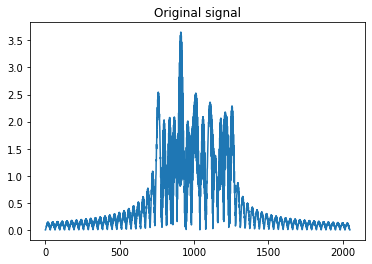

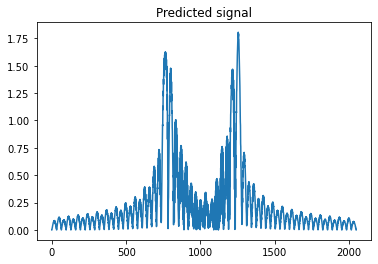

In [ ]:
index_pred = 0
test_pred_cnn2D(model, X_test, index_pred)

### **Resnet50**

In [23]:
from keras import applications
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.models import Sequential,Model,load_model

In [31]:
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (32,32,2))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/applications/imagenet_utils.py:333: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  str(input_shape[-1]) + ' input channels.')


In [32]:
withReshape = True
ts = 0.25
X_train, X_test, y_train, y_test = prepareTrainAndTestData(df, withReshape, ts)

[INFO] - {prepareTrainAndTestData} converting from pandas to numpy...
(50000, 2048)
(50000, 2048)
(37500, 2048, 1)
(37500, 2048, 1)
(12500, 2048, 1)
(12500, 2048, 1)


In [33]:
# Reshape X to (n_samples, height, width, channels)
X_train = X_train.reshape((X_train.shape[0],32,32,2))
X_test = X_test.reshape((X_test.shape[0],32,32,2))
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

In [34]:
X_train.shape

(37500, 32, 32, 2)

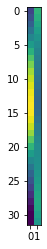

In [35]:
index_plot = 59
plt.imshow(X_train[index_plot][0])
plt.imshow(X_train[index_plot][1])

In [36]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(2048, activation= 'elu')(x)
x = Dense(1024, activation= 'elu')(x)
x = Dense(512, activation= 'elu')(x)
x = Dense(1024, activation= 'elu')(x)
x = Dense(2048, activation= 'elu')(x)
predictions = Dense(2048, activation= 'elu')(x)
_resnet50 = Model(inputs = base_model.input, outputs = predictions)

In [37]:
_resnet50.compile(optimizer= 'adam', loss='mse', metrics=['mae'])
_resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 2)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 2)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   6336        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
nepochs = 25
batch_size = 128

_resnet50.fit(X_train, y_train, epochs = nepochs, batch_size=batch_size)

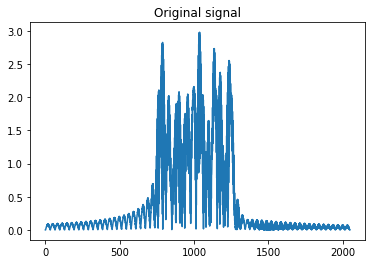

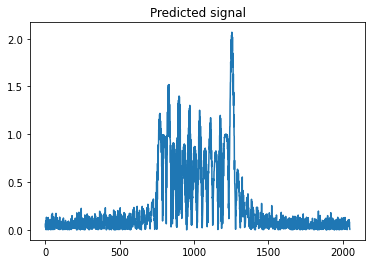

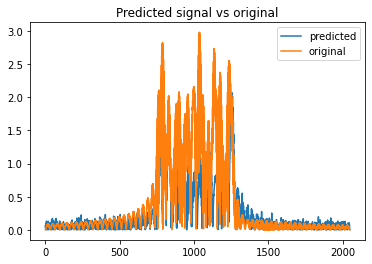

In [53]:
index_pred = 0
y_pred = test_pred_cnn2D(_resnet50, X_train, index_pred)

In [67]:
#-------------------------------------------------------------------------------------------------#

def plot_transformed_to_img(X, index_plot):

    plt.imshow(X[index_plot][0])
    plt.title("Image on channel 1")
    plt.show()

    plt.imshow(X[index_plot][1])
    plt.title("Image on channel 2")
    plt.show()
    
#-------------------------------------------------------------------------------------------------#

def evaluate_ber(y_pred, y_test, index_pred, nsymbols):
    
    nLayers = 500                         # Number of Layers of the Generative network
    y_ori = y_test[index_pred]
    # Initialize parameters
    parameters = Parameters(nsymbols=nsymbols, nLayers=nLayers)
    # Initialize the Equalizer
    equalizer = Equalizer()
    # Initialize the Demodulator
    demodulator = Demodulator()
    # Initialize the Transmitor
    transmitor = Transmitor()
    # Initialize the Detector
    detector = Detector(transmitor)
    
    # propagation & equalization.
    q0t = fromRealToComplex(y_pred)    
    #qzt, qzf = channel.channel(parameters.t, q0t, parameters.z, parameters.sigma2, parameters.B) 
    qzt = q0t
    qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z) # equalized output
    # demodulation
    shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)
    #shat = demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

    # detection
    stilde, indexes = detector.detector(shat, parameters.M)
    bhat = detector.symbols_to_bit(indexes, parameters.M)
    y_ori = y_ori.reshape(1,-1)
    # propagation & equalization.
    q0t = fromRealToComplex(y_ori)
    print(q0t.shape)
    qzt = q0t
    qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z) # equalized output
    # demodulation
    shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

    # detection
    stilde, indexes = detector.detector(shat, parameters.M)
    b = detector.symbols_to_bit(indexes, parameters.M)
    
    ser = detector.ser(shat, stilde)  # symbol error rate
    ber = detector.ber(b, bhat)  # bit error rate
    
    print("b : ", b)
    print("bhat : ", bhat)
    print("ber : ", ber)
    print("ser : ", ser)    
    
#-------------------------------------------------------------------------------------------------#
    
def evals(model, X_test, y_test, index_pred, nsymbols=16):
    
    # Reshape images to go back to Signal
    x_tester = X_test.reshape(X_test.shape[0], -1, 2,32,32)
    #x_test_original = X_test.reshape(X_test.shape[0], 2048,1)
       
    y_pred = model.predict(x_tester[index_pred])
    
    plt.title("Predicted Signal")
    plt.plot(np.squeeze(np.abs(y_pred)))
    plt.show()
    
    plt.title("Predicted Signal vs Original")
    plt.plot(np.squeeze(np.abs(y_pred)), label="prediction")
    plt.plot(np.squeeze(np.abs(y_test[index_pred])), label="original")
    plt.legend()
    plt.show()
    
    plt.title("Predicted Signal vs Original")
    plt.plot(np.squeeze(np.abs(y_pred)), label="prediction")
    plt.plot(np.squeeze(np.abs(y_test[index_pred])), label="original")
    plt.legend()
    plt.show()
    
    evaluate_ber(y_pred, y_test, index_pred, nsymbols)
    
    return y_pred

#-------------------------------------------------------------------------------------------------#
import numpy as np

class Demodulator :

    #-------------------------------------------------------------------------------------------------#

    def demod(self, t, dt, qzte, B, Ns):
        sl = np.zeros((Ns, 1), dtype=np.complex128)
        l1 = int(-(Ns/2))
        l2 = int((Ns/2) - 1)
        
        lRange = np.linspace(l1, l2, num=Ns, endpoint=True)

        for j, l in enumerate(lRange):
            for i, ti in enumerate(t):
                sl[j] += qzte[0, i] * np.sinc(B*ti-l) * dt

        shat = np.sqrt(B)*sl

        return shat

    #-------------------------------------------------------------------------------------------------#
    
import numpy as np

class Detector :

    #-------------------------------------------------------------------------------------------------#


    def __init__(self, transmitor):
        self.transmitor = transmitor

    #-------------------------------------------------------------------------------------------------#

    def detector(self, shat, M):
        """ Computes detection based on ML detector """

        cnt, _, _  = self.transmitor.build_constellations(M)
        symboles = []
        indexes = []

        for symb in shat:
            diff = np.absolute(symb - cnt)**2
            index = np.argmin(diff)
            indexes.append(index)
            symboles.append(cnt[index])

        stilde = np.array(symboles)
        return stilde, np.array(indexes)

    #-------------------------------------------------------------------------------------------------#

    def symbols_to_bit(self, indexes, M):

        """ Find the bit associated to the symbol """

        _, _, binaryArr = self.transmitor.build_constellations(M)

        bits = np.ndarray(0, dtype=np.int32)
        for index in indexes:
            bits = np.hstack((bits, binaryArr[index]))
        return bits

    #-------------------------------------------------------------------------------------------------#

    def ber(self, b, bhat):

        """ Computes bit error rate """
        return np.sum(np.abs(b.T - bhat)) / b.size

    #-------------------------------------------------------------------------------------------------#

    def ser(self, s, shat):

        """ Computes symbol error rate """
        return np.sum(np.absolute(s - shat)) / s.size

    #-------------------------------------------------------------------------------------------------#
  
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt

class Transmitor :

    def __init__(self):
        super()


    #-------------------------------------------------------------------------------------------------#
    
    def source(self, N, p):
        """ Generates an N-bit sequence drawn from a Bernoulli stochastic process.
            @param N : Length of the bit sequence
            @param p : probability of 0
        """
        # number of experiences
        n=1
        return np.random.binomial(n, p, size=N)

    #-------------------------------------------------------------------------------------------------#

    def build_constellations(self,M):
        k = int(np.log2(M))
        N = np.arange(0, M, dtype=np.int32)
        coords = []
        binaryStr = []
        binaryArr = np.zeros((M, k), dtype=np.uint8)
        for n in N:
            bin, code = self.gray_coding(n, M)
            coords.append(code)
            binaryArr[n] = bin
            binaryStr.append(np.binary_repr(n, width=k))

        coords = np.array(coords)

        return coords, binaryStr, binaryArr

    #-------------------------------------------------------------------------------------------------#

    def bit_to_symb(self, b, M=16):
        """ Creates a mapping between bits sequences and symbols.
            @param b : N-bit sequence
            @param M : Number of symbols in the constellation
        """

        k = int(np.log2(M))

        if b.size % k != 0:
            b = np.vstack((b, np.zeros((6-b.size % k, 1), dtype=np.uint8)))

        bits = b.reshape((-1, k))

        symboles = []
        for bi in bits:
            biDec = np.packbits(np.hstack((np.zeros(8-k, dtype=np.uint8), bi)))[0]
            bin, code = self.gray_coding(biDec, M)
            symboles.append(code)

        return np.array(symboles)

    #-------------------------------------------------------------------------------------------------#

    def gray_coding(self, n, M):
        k = int(np.log2(M))

        reAxis = np.hstack((np.arange(-(np.sqrt(M)//2), 0, step=1),
                            np.arange(1, np.sqrt(M)/2+1, step=1)))
        imAxis = np.copy(reAxis)

        bin = np.unpackbits(np.array([n], dtype=np.uint8))[8-k:]

        rePart = bin[:k//2]
        imPart = bin[k//2:]

        aReBin = np.hstack((np.zeros(8-k//2, dtype=np.uint8), rePart))
        aImBin = np.hstack((np.zeros(8-k//2, dtype=np.uint8), imPart))

        aReDec = np.packbits(aReBin)
        aImDec = np.packbits(aImBin)

        reIndex = np.bitwise_xor(aReDec, aReDec//2)[0]
        imIndex = np.bitwise_xor(aImDec, aImDec//2)[0]

        return  bin, complex(reAxis[reIndex], imAxis[imIndex])
    
    #-------------------------------------------------------------------------------------------------#

    def plot_constellation(self, M, constellation, binaryStr):

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        fig.suptitle(f'{M}-QAM Constellation')
        ax.set_xlabel('Real part')
        ax.set_ylabel('Imaginary part')

        ax.scatter(constellation.real, constellation.imag)

        for i, str_bin in enumerate(binaryStr):
            ax.annotate(str_bin, (constellation.real[i], constellation.imag[i]),
                        xytext=(constellation.real[i]-0.2, constellation.imag[i]-0.2))

        ax.axis([-(np.sqrt(M)//2)-1, np.sqrt(M)/2+1, -(np.sqrt(M)//2)-1, np.sqrt(M)/2+1])
        ax.axhline(y=0, color='black')
        ax.axvline(x=0, color='black')

        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_major_locator(MultipleLocator(1))
        
        plt.show()

    #-------------------------------------------------------------------------------------------------#
    
    def build_constellations_2(self, M):
    
        """ Builds a M-QAM constellation.
            @param M : Number of symbols.
        """
        
        # Sequential address from 0 to M-1 (1xM dimension)
        n = np.arange(0,M)
        #convert linear addresses to Gray code
        a = np.asarray([x^(x>>1) for x in n])
        #Dimension of K-Map - N x N matrix
        D = np.sqrt(M).astype(int) 
        # NxN gray coded matrix
        a = np.reshape(a,(D,D))
        # identify alternate rows
        oddRows=np.arange(start = 1, stop = D ,step=2) 
        
        # reshape to 1xM - Gray code walk on KMap
        nGray=np.reshape(a,(M)) 
        
        #element-wise quotient and remainder
        (x,y)=np.divmod(nGray,D) 
        # PAM Amplitudes 2d+1-D - real axis
        Ax=2*x+1-D 
        # PAM Amplitudes 2d+1-D - imag axis
        Ay=2*y+1-D 
        constellation = Ax+1j*Ay
        
        self.constellation = constellation

        return constellation


    #-------------------------------------------------------------------------------------------------#
    

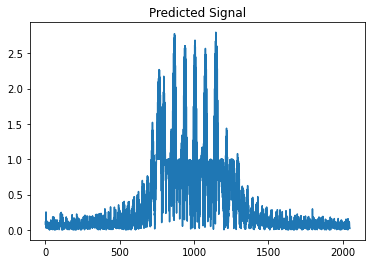

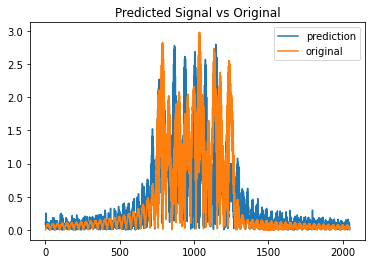

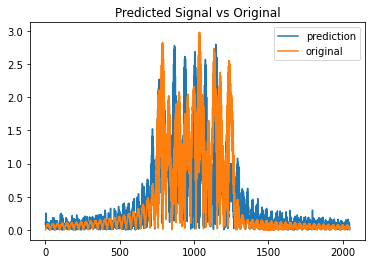

100%|██████████| 1/1 [00:00<00:00, 120.20it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)
[Equalizer] qzte : [[-0.0094759 -0.04884945j  0.13337897+0.04678967j  0.00385961+0.0114775j
  ... -0.01796542-0.1703214j   0.18020171+0.22937207j
   0.09972263-0.00756199j]]
[Equalizer] qzfe : [[ 60.45548189 -0.50715863j -32.85050838 -4.21709604j
   14.83738318 +4.39352259j ... -74.64893818+28.21164423j
   87.64422875-27.9364025j  -81.53348041+12.06422959j]]



100%|██████████| 1/1 [00:00<00:00, 247.99it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)
(1, 1024)
[Equalizer] qzte : [[0.06860257-0.07554733j 0.06656884-0.07890512j 0.06148527-0.08129526j
  ... 0.05624265-0.0610447j  0.06330837-0.06644303j
  0.06750826-0.07134015j]]
[Equalizer] qzfe : [[ 80.42446882+127.05432697j -99.77385194-147.74981427j
  117.27404839+120.19702234j ... -34.66454263 +23.40342884j
   41.5653747  +14.3604016j  -57.93031445 -75.93584136j]]


b :  [1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1]
bhat :  [1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0
 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1]
ber :  0.46875
ser :  36.53384449359453


array([[-0.0812611 ,  0.12123466,  0.05928387, ...,  0.08142187,
         0.02101862, -0.0213396 ]], dtype=float32)

In [68]:
evals(_resnet50, X_test, y_test, index_pred, nsymbols=16)

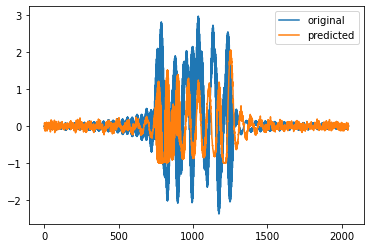

In [74]:
plt.plot(np.squeeze(y_test[index_pred]), label="original")
plt.plot(np.squeeze(y_pred), label="predicted")
plt.legend()

## **Dense (MLP)**

In [ ]:
#-----------------------------------------------------------------------------------------------------#

def my_activation(x):
        """ Computes the activation of a neuron.
            @param x : data.

            Should use Keras function for stability of the tensors.
        """
        dz = parameters.z/parameters.nz
        return x*K.exp(1j*dz*K.abs(x)**2) # add complex j, later add weight factor to the activation function (put w to the exponents)


#-----------------------------------------------------------------------------------------------------#

def create_MLP_CNN(only_dense, opti, customActivationFct, activation_fct, lr, N_output_pred, loss_fct, nbrOfStackedDense, nbrOfStackedCNN, nbrNeuronsDense, nbrFiltersCNN, dropoutDense, dropoutCNN):

  # use early stopping
  #callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
  

  # custom activation function
  if customActivationFct :
    # see how to provide the gradient for tf so that BP use it to update the errors
    #2048 dense neurons* 6 layers * phase activation/ker activation * 100K examples
    get_custom_objects().update({'my_activation': Activation(my_activation)})
  
  # Model
  model_dense_cnn = Sequential()

  

  # Embedding layer -----------------------------------------------------------------------------------------------------#
  
  #model_dense_cnn.add(Embedding(X_train.shape[1], 16, input_length=X_train.shape[1]))
  
  # Fully connected layers -----------------------------------------------------------------------------------------------#
  
  for i in range(nbrOfStackedDense//2) :

    if i == 0 :
      # Input layer - 1st Dense layer should include input shape
      #model_dense_cnn.add(Dense(X_train.shape[1], kernel_initializer='VarianceScaling',  use_bias=True,  input_shape=X_train.shape[1:]))
      model_dense_cnn.add(Dense(nbrNeuronsDense, kernel_initializer='VarianceScaling', activation='relu', use_bias=True,  input_shape=X_train.shape[1:]))
      #model_dense_cnn.add(PReLU())
      #model_dense_cnn.add(Dropout(dropoutDense))
      
      
    else :
      #model_dense_cnn.add(BatchNormalization())
      model_dense_cnn.add(Dense(nbrNeuronsDense, kernel_initializer='VarianceScaling',  activation='relu',use_bias=True))
      #model_dense_cnn.add(PReLU())
      #model_dense_cnn.add(Dropout(dropoutDense))


  # Convolution layers ----------------------------------------------------------------------------------------------------#
  if only_dense != 1 :

    # go up to 10 layers of CNN
    for i in range(nbrOfStackedCNN):
      
      if i == 0 :
        # 1st CNN layer should include input shape
        #model_dense_cnn.add(BatchNormalization())
        model_dense_cnn.add(Conv1D(filters=nbrFiltersCNN, kernel_size=1 ,strides=1, activation='relu', input_shape=X_train.shape[1:], use_bias=True, kernel_initializer= 'VarianceScaling')) 
        #model_dense_cnn.add(PReLU())
        #model_dense_cnn.add(Dropout(dropoutCNN))

      else :
        #model_dense_cnn.add(BatchNormalization())
        model_dense_cnn.add(Conv1D(filters=nbrFiltersCNN, kernel_size=1 ,strides=1, activation='relu', kernel_initializer= 'VarianceScaling', use_bias=True))
        #model_dense_cnn.add(Dropout(dropoutCNN))

   

  # Fully connected layers -------------------------------------------------------------------------------------------------#
  for i in range(nbrOfStackedDense//2) :
    #model_dense_cnn.add(BatchNormalization())
    model_dense_cnn.add(Dense(nbrNeuronsDense, use_bias=True, activation='relu',kernel_initializer='VarianceScaling'))
    #model_dense_cnn.add(PReLU())
    #model_dense_cnn.add(Dropout(dropoutDense))

  

  # Output layer -----------------------------------------------------------------------------------------------------------#
  model_dense_cnn.add(Dense(N_output_pred)) #=1
 
  if customActivationFct :
    model_dense_cnn.add(Activation(my_activation, name='SpecialActivation'))
  else :
    model_dense_cnn.add(Activation('sigmoid'))
  # Compile the model ------------------------------------------------------------------------------------------------------#
  

  model_dense_cnn.compile(loss=loss_fct, 
                      optimizer=opti, 
                      metrics=['mae'])
  if lr != None :
    K.set_value(model_dense_cnn.optimizer.learning_rate, lr)

  print(model_dense_cnn.optimizer.get_config())
  print(model_dense_cnn.summary())
  print("model_dense.output_shape : ",model_dense_cnn.output_shape)

  return model_dense_cnn

#-----------------------------------------------------------------------------------------------------#

In [ ]:
with_error_plots = True 

only_dense = False
customActivationFct = False
lr = None

earlystopping_patience = 4
nbrOfStackedDense = 6
nbrOfStackedCNN = 6
nbrNeuronsDense = 64
nbrFiltersCNN = 64

dropoutDense, dropoutCNN = 0, 0

loss_fct = 'mse'
activation_fct = 'relu'
opti = 'adam'

In [ ]:
with_error_plots = True 

only_dense = False
customActivationFct = False
lr = None

earlystopping_patience = 15
nbrOfStackedDense = 2
nbrOfStackedCNN = 0
nbrNeuronsDense = 2048
nbrFiltersCNN = 0

dropoutDense, dropoutCNN = 0, 0

loss_fct = 'mse'
activation_fct = 'sigmoid'
opti = 'sgd'

In [ ]:
model_dense_full_big_ts = create_MLP_CNN(only_dense, opti, customActivationFct, activation_fct, lr, N_output_pred, loss_fct, nbrOfStackedDense, nbrOfStackedCNN, nbrNeuronsDense, nbrFiltersCNN, dropoutDense, dropoutCNN)

{'name': 'SGD', 'learning_rate': 0.01, 'decay': 0.0, 'momentum': 0.0, 'nesterov': False}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048, 2048)        4096      
_________________________________________________________________
dense_1 (Dense)              (None, 2048, 2048)        4196352   
_________________________________________________________________
dense_2 (Dense)              (None, 2048, 1)           2049      
_________________________________________________________________
activation (Activation)      (None, 2048, 1)           0         
Total params: 4,202,497
Trainable params: 4,202,497
Non-trainable params: 0
_________________________________________________________________
None
model_dense.output_shape :  (None, 2048, 1)


In [ ]:
epochs = 40
# Fiting the model
model_dense_full_big_ts = train(model_dense_full_big_ts, X_train, X_test, y_train, y_test, epochs , batch_size, earlystopping_patience=20)

Epoch 1/40
4063/4063 [==============================] - 573s 141ms/step - loss: 0.6286 - mae: 0.4311 - val_loss: 0.6235 - val_mae: 0.4140
Epoch 2/40
4063/4063 [==============================] - 572s 141ms/step - loss: 0.6234 - mae: 0.4110 - val_loss: 0.6227 - val_mae: 0.4090
Epoch 3/40
4063/4063 [==============================] - 572s 141ms/step - loss: 0.6230 - mae: 0.4082 - val_loss: 0.6225 - val_mae: 0.4074
Epoch 4/40
4063/4063 [==============================] - 572s 141ms/step - loss: 0.6229 - mae: 0.4071 - val_loss: 0.6225 - val_mae: 0.4067
Epoch 5/40
4063/4063 [==============================] - 572s 141ms/step - loss: 0.6228 - mae: 0.4065 - val_loss: 0.6224 - val_mae: 0.4062
Epoch 6/40
4063/4063 [==============================] - 572s 141ms/step - loss: 0.6228 - mae: 0.4061 - val_loss: 0.6224 - val_mae: 0.4059
Epoch 7/40
4063/4063 [==============================] - 572s 141ms/step - loss: 0.6227 - mae: 0.4059 - val_loss: 0.6224 - val_mae: 0.4057
Epoch 8/40
4063/4063 [============

In [ ]:
# testing the model
index_pred = 0
with_error_plots = False
history=None
y_pred = test_model(model_dense_full_big_ts, x_te, y_te, history, index_pred, with_error_plots)
test_prediction(y_te, y_pred, index_pred, parameters)

In [ ]:
print("done!")

### **Full Dense**

#### **With min-max scaler**

In [ ]:
withReshape = True
ts = 0.25
X_train, X_test, y_train, y_test = prepareTrainAndTestData(df, withReshape, ts)

[INFO] - {prepareTrainAndTestData} converting from pandas to numpy...
(100000, 2048)
(100000, 2048)
(75000, 2048, 1)
(75000, 2048, 1)
(25000, 2048, 1)
(25000, 2048, 1)


In [ ]:
model_dense_full_minmax = create_MLP_CNN(only_dense, opti, customActivationFct, activation_fct, lr, N_output_pred, loss_fct, nbrOfStackedDense, nbrOfStackedCNN, nbrNeuronsDense, nbrFiltersCNN, dropoutDense, dropoutCNN)

{'name': 'SGD', 'learning_rate': 0.01, 'decay': 0.0, 'momentum': 0.0, 'nesterov': False}
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 2048, 1024)        2048      
_________________________________________________________________
dense_28 (Dense)             (None, 2048, 1024)        1049600   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2048, 512)         524800    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 2048, 512)         262656    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 2048, 512)         262656    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 2048, 512)         262656    
_______________________________

In [ ]:
epochs = 250
# Fiting the model
model_dense_full_minmax = train(model_dense_full_minmax, x_tr, x_te, y_tr, y_te, epochs , batch_size, earlystopping_patience=20)

Epoch 1/250
5/5 [==============================] - 1s 249ms/step - loss: 0.6677 - mae: 0.5327 - val_loss: 0.6769 - val_mae: 0.5347
Epoch 2/250
5/5 [==============================] - 1s 141ms/step - loss: 0.6658 - mae: 0.5295 - val_loss: 0.6750 - val_mae: 0.5316
Epoch 3/250
5/5 [==============================] - 1s 142ms/step - loss: 0.6639 - mae: 0.5264 - val_loss: 0.6732 - val_mae: 0.5287
Epoch 4/250
5/5 [==============================] - 1s 141ms/step - loss: 0.6621 - mae: 0.5234 - val_loss: 0.6715 - val_mae: 0.5258
Epoch 5/250
5/5 [==============================] - 1s 141ms/step - loss: 0.6604 - mae: 0.5205 - val_loss: 0.6699 - val_mae: 0.5230
Epoch 6/250
5/5 [==============================] - 1s 142ms/step - loss: 0.6588 - mae: 0.5176 - val_loss: 0.6683 - val_mae: 0.5203
Epoch 7/250
5/5 [==============================] - 1s 143ms/step - loss: 0.6572 - mae: 0.5149 - val_loss: 0.6669 - val_mae: 0.5178
Epoch 8/250
5/5 [==============================] - 1s 141ms/step - loss: 0.6558 - m

100%|██████████| 1/1 [00:00<00:00, 180.43it/s]

X_test.shape :  (75, 2048, 1)
y_test.shape :  (75, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.03723286]
 [0.05918484]
 [0.0400978 ]
 ...
 [0.05230071]
 [0.03553091]
 [0.05538486]]
y_pred.shape :  (2048, 1)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)


y_test :  [-5.68387015e-16  4.10339051e-16 -2.55820875e-02 ...  3.04243081e-02
 -3.59262272e-16  7.02612401e-16]


y_pred :  [0.03723286 0.05918484 0.0400978  ... 0.05230071 0.03553091 0.05538486]


diff :  [[[-0.03723286]
  [-0.05918484]
  [-0.06567989]
  ...
  [-0.02187641]
  [-0.03553091]
  [-0.05538486]]]
mse test :  0.614023724775933




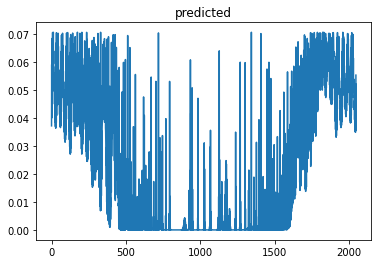

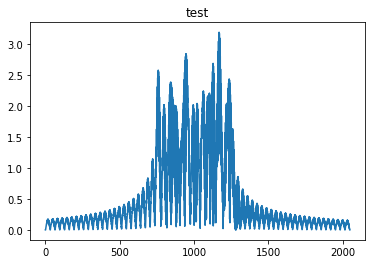

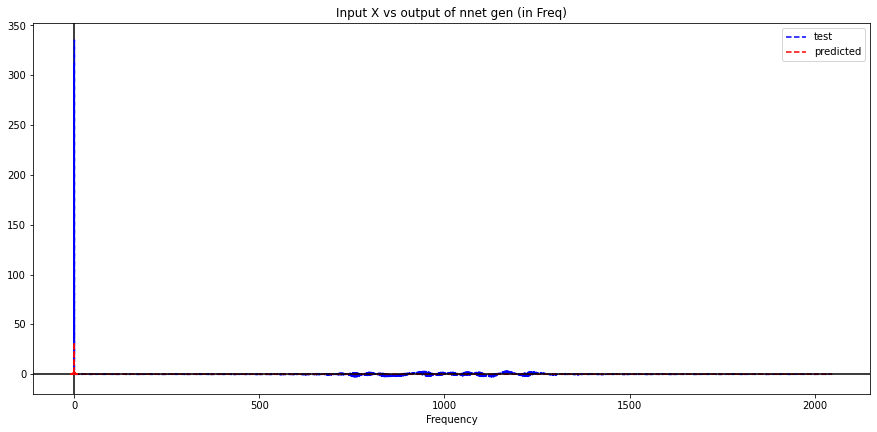

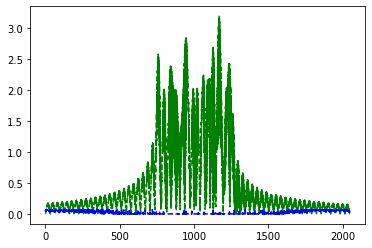

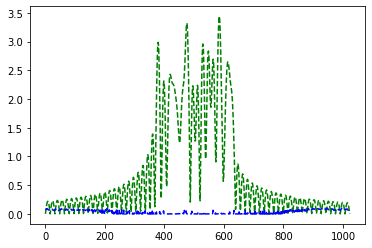

In [ ]:
# testing the model
index_pred = 10
with_error_plots = False
history=None
y_pred = test_model(model_dense_full_minmax, x_tr, y_tr, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

100%|██████████| 1/1 [00:00<00:00, 167.33it/s]

X_test.shape :  (25000, 2048, 1)
y_test.shape :  (25000, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.00856371]
 [0.01814279]
 [0.00856251]
 ...
 [0.0162758 ]
 [0.00853748]
 [0.01710198]]
y_pred.shape :  (2048, 1)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)


y_test :  [-0.70167748 -0.9672131   0.04892847 ... -0.69555856  0.71079597
 -0.01055106]


y_pred :  [0.00856371 0.01814279 0.00856251 ... 0.0162758  0.00853748 0.01710198]


diff :  [[[-0.71024119]
  [-0.98535589]
  [ 0.04036596]
  ...
  [-0.71183436]
  [ 0.70225849]
  [-0.02765304]]]
mse test :  0.3989478901310205




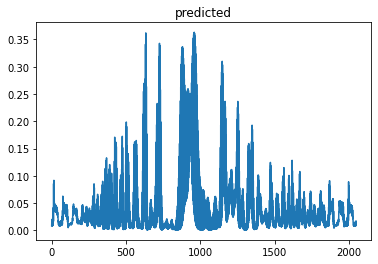

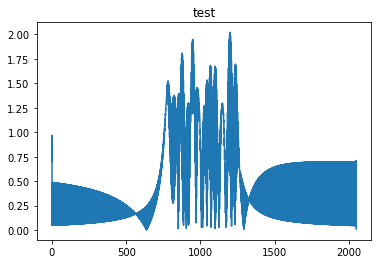

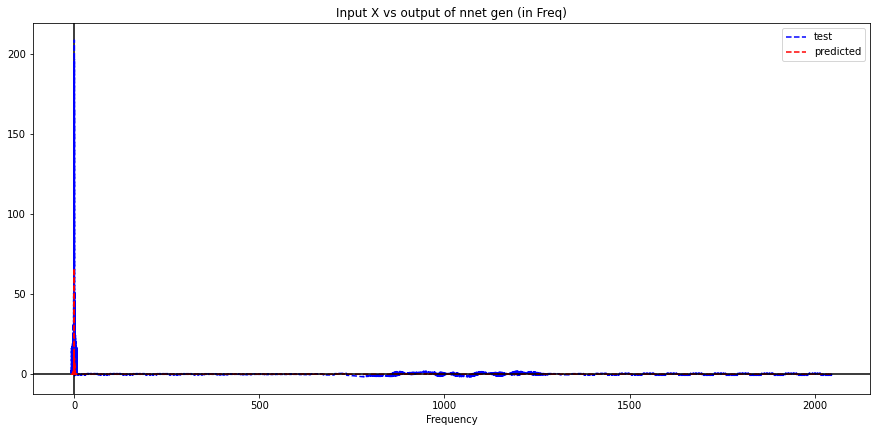

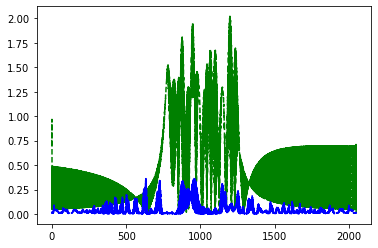

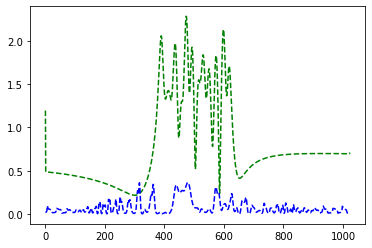

In [ ]:
# testing the model
index_pred = 256
with_error_plots = False
history=None
y_pred = test_model(model_dense_full_minmax, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

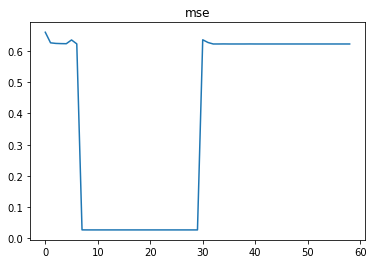

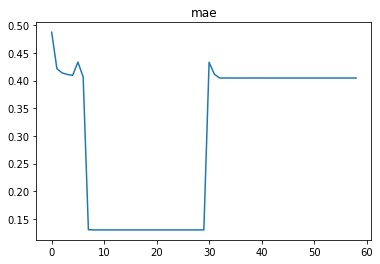

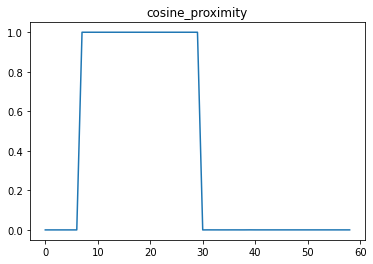

100%|██████████| 1/1 [00:00<00:00, 158.63it/s]

X_test.shape :  (25000, 2048, 1)
y_test.shape :  (25000, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[8.3893341e-05]
 [7.3649258e-05]
 [8.3686631e-05]
 ...
 [7.3116724e-05]
 [8.3907573e-05]
 [7.3275944e-05]]
y_pred.shape :  (2048, 1)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)


y_ :  [ 1.11669871e-16  7.51057887e-18 -1.17938102e-02 ... -3.52789568e-03
 -3.93816421e-16 -2.10492521e-16]
y_test_im :  [ 1.1166987e-16+7.5105791e-18j -1.1793810e-02-3.5304343e-03j
 -2.3189623e-02-6.9350395e-03j ... -1.6707378e-02-6.9310451e-03j
 -8.5030096e-03-3.5278958e-03j -3.9381643e-16-2.1049252e-16j]
y_pred :  [8.3893341e-05 7.3649258e-05 8.3686631e-05 ... 7.3116724e-05 8.3907573e

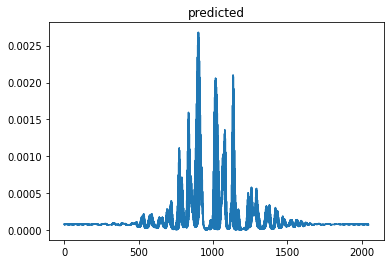

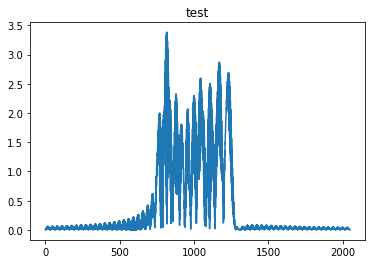

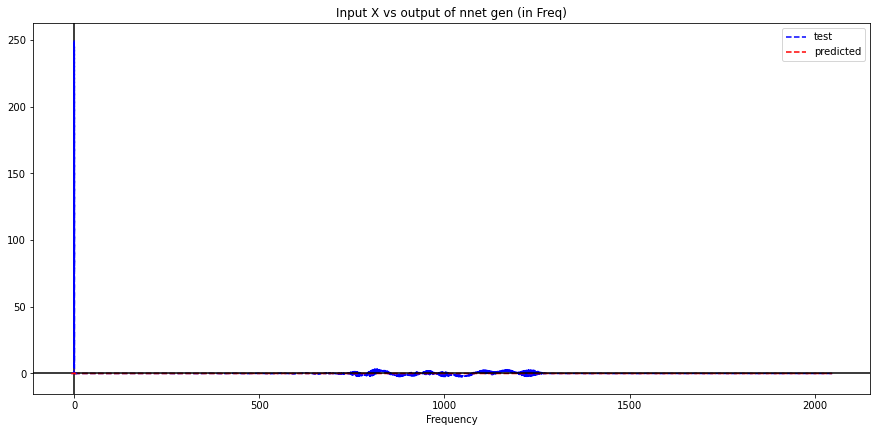

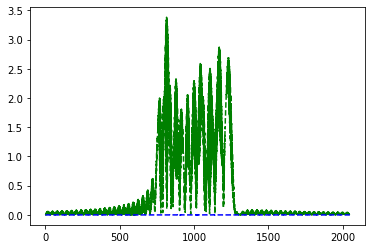

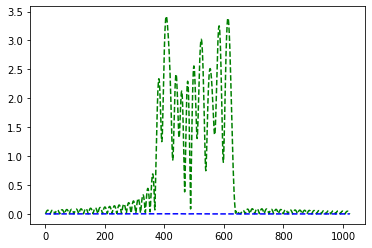

In [ ]:
# testing the model
index_pred = 256
with_error_plots = True
y_pred = test_model(model_dense_full_minmax, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

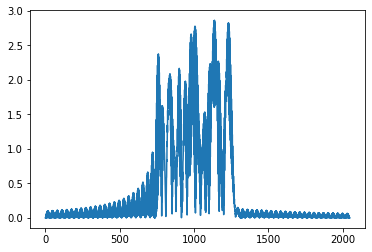

In [ ]:
plt.plot(np.abs(y_test[index_pred]))

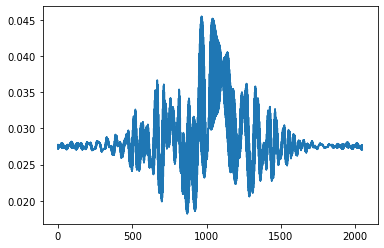

In [ ]:
plt.plot(np.abs(y_pred))

In [ ]:
epochs = 30
# Fiting the model
model_dense_full_minmax = train(model_dense_full_minmax, X_train, X_test, y_train, y_test, epochs , batch_size, earlystopping_patience)

Epoch 1/30
674/674 [==============================] - 69s 102ms/step - loss: 0.0279 - mse: 0.0279 - mae: 0.1315 - cosine_proximity: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.0279 - val_mse: 0.0279 - val_mae: 0.1313 - val_cosine_proximity: 1.0000 - val_cosine_similarity: 1.0000
Epoch 2/30
674/674 [==============================] - 68s 100ms/step - loss: 0.0279 - mse: 0.0279 - mae: 0.1312 - cosine_proximity: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.0278 - val_mse: 0.0278 - val_mae: 0.1312 - val_cosine_proximity: 1.0000 - val_cosine_similarity: 1.0000
Epoch 3/30
674/674 [==============================] - 68s 100ms/step - loss: 0.0278 - mse: 0.0278 - mae: 0.1311 - cosine_proximity: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.0278 - val_mse: 0.0278 - val_mae: 0.1311 - val_cosine_proximity: 1.0000 - val_cosine_similarity: 1.0000
Epoch 4/30
674/674 [==============================] - 68s 100ms/step - loss: 0.0278 - mse: 0.0278 - mae: 0.1311 - cosine_proximity: 1.0000 - cosi

In [ ]:
# testing the model
index_pred = -16494
with_error_plots = True
y_pred = test_model(model_dense_shallow, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

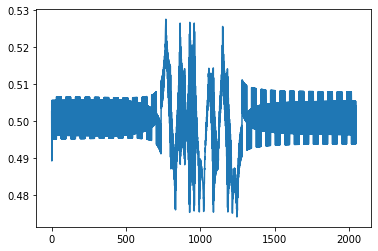

In [ ]:
plt.plot(y_pred)

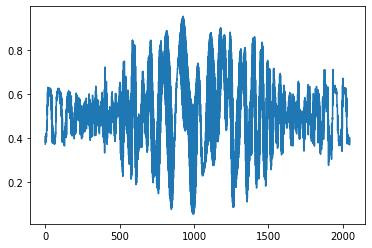

In [ ]:
plt.plot(y_test[index_pred])

In [ ]:
parameters.t.shape

(1024,)

In [ ]:
model_dense_shallow = create_MLP_CNN(only_dense, opti, customActivationFct, activation_fct, lr, N_output_pred, loss_fct, nbrOfStackedDense, nbrOfStackedCNN, nbrNeuronsDense, nbrFiltersCNN, dropoutDense, dropoutCNN)

{'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 2048, 2048)        4096      
_________________________________________________________________
dropout_41 (Dropout)         (None, 2048, 2048)        0         
_________________________________________________________________
dense_38 (Dense)             (None, 2048, 2)           4098      
_________________________________________________________________
dropout_42 (Dropout)         (None, 2048, 2)           0         
_________________________________________________________________
dense_39 (Dense)             (None, 2048, 1)           3         
_________________________________________________________________
activation_11 (Activation)   (None, 2048, 1)           0      

In [ ]:
epochs = 100
# Fiting the model
model_dense_shallow = train(model_dense_shallow, X_train, X_test, y_train, y_test, epochs , batch_size, earlystopping_patience=10)

Epoch 1/100
674/674 [==============================] - 69s 103ms/step - loss: 0.0279 - mse: 0.0279 - mae: 0.1311 - cosine_proximity: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.0279 - val_mse: 0.0279 - val_mae: 0.1312 - val_cosine_proximity: 1.0000 - val_cosine_similarity: 1.0000
Epoch 2/100
674/674 [==============================] - 69s 102ms/step - loss: 0.0279 - mse: 0.0279 - mae: 0.1310 - cosine_proximity: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.0281 - val_mse: 0.0281 - val_mae: 0.1316 - val_cosine_proximity: 1.0000 - val_cosine_similarity: 1.0000
Epoch 3/100
674/674 [==============================] - 69s 102ms/step - loss: 0.0279 - mse: 0.0279 - mae: 0.1310 - cosine_proximity: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.0278 - val_mse: 0.0278 - val_mae: 0.1308 - val_cosine_proximity: 1.0000 - val_cosine_similarity: 1.0000
Epoch 4/100
674/674 [==============================] - 69s 102ms/step - loss: 0.0279 - mse: 0.0279 - mae: 0.1309 - cosine_proximity: 1.0000 - 

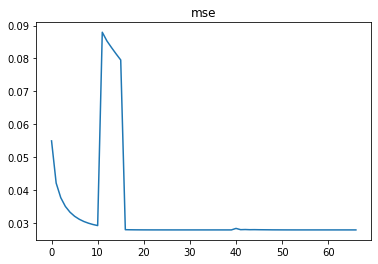

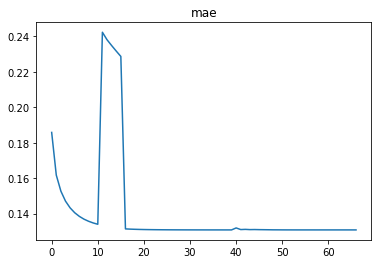

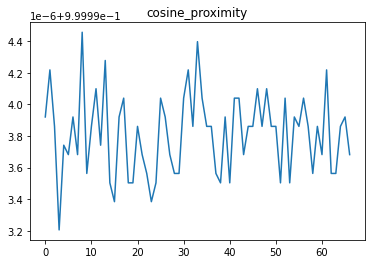

X_test.shape :  (28750, 2048, 1)
y_test.shape :  (28750, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.4991231 ]
 [0.5008357 ]
 [0.50044775]
 ...
 [0.49439222]
 [0.49905112]
 [0.48871094]]
y_pred.shape :  (2048, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)


y_ :  [0.32448642 0.45256705 0.33167517 ... 0.45890069 0.32210932 0.4541194 ]
y_test_im :  [0.32448642+0.45256705j 0.33167517+0.44823618j 0.34119488+0.43552189j ...
 0.33267826+0.47023383j 0.32541965+0.45890069j 0.32210932+0.4541194j ]
y_pred :  [0.4991231  0.5008357  0.50044775 ... 0.49439222 0.49905112 0.48871094]
y_pred_im :  [0.4991231 +0.5008357j  0.50044775+0.49102384j 0.50044644+0.49102175j ...
 0.5020593 +0.49439806j 0.5020584 +0.49439222j 0.49905112+0.48871094j]
diff :  [[[-0.17463668]
  [-0.04826867]
  [-0.16877258]
  ...


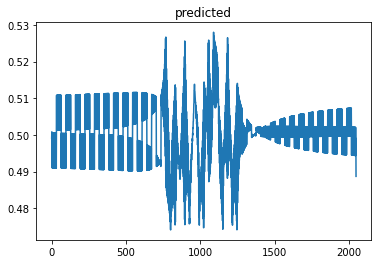

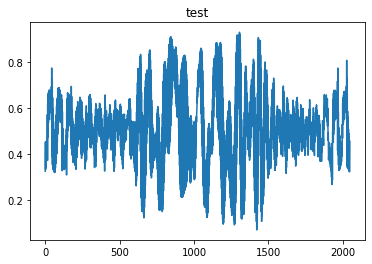

y_f :  [1038.24720304 +0.j           -6.98794955 -7.3264104j
   11.87159159+11.98096749j ...   -5.75757774+15.00819942j
   11.87159159-11.98096749j   -6.98794955 +7.3264104j ]
y_f.shape :  (2048,)
y_f :  [[[1038.24720304 +0.j        ]
  [  -6.98794955 -7.3264104j ]
  [  11.87159159+11.98096749j]
  ...
  [  -5.75757774+15.00819942j]
  [  11.87159159-11.98096749j]
  [  -6.98794955 +7.3264104j ]]]
y_f.shape :  (1, 2048, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
y_f_im :  [[[1045.57361344 -6.98794955j]
  [  26.87979101 +6.22338974j]
  [  13.5255295 +17.74713334j]
  ...
  [ -16.70093982 +7.55453078j]
  [  -8.27830574-17.64566446j]
  [   4.54518119-18.96891704j]]]
y_f_im.shape :  (1, 2048, 1)
y_pred_f :  [ 1.02406930e+03+0.j          1.24414509e+00+0.34718788j
 -8.16574951e-01-0.64353981j ... -3.02198174e-01-0.84923584j
 -8.16574951e-01+0.64353981j  1.24414509e+00-0.34718788j]
y_pred_f.shape :  (2048,)
y_pred_f :  [[[ 1.02406930e+03+0.j        ]
  [ 1.24414509e+00+0.34718788j]
  [

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


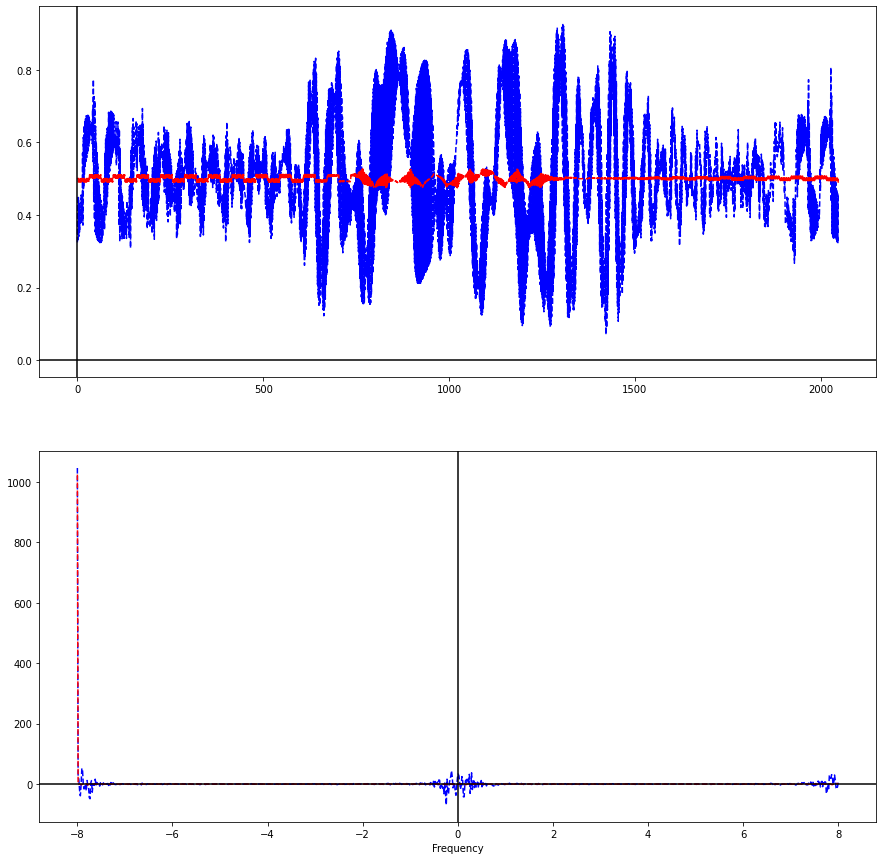

In [ ]:
# testing the model
index_pred = -16494
with_error_plots = True
y_pred = test_model(model_dense_shallow, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

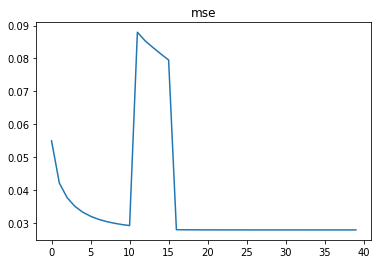

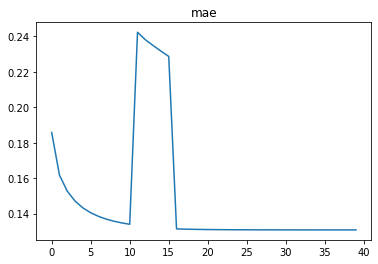

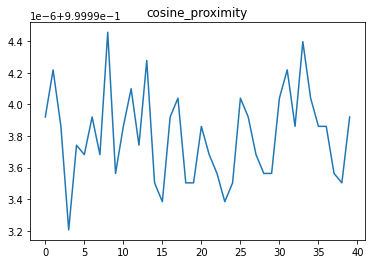

X_test.shape :  (28750, 2048, 1)
y_test.shape :  (28750, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.49916467]
 [0.5008707 ]
 [0.50048417]
 ...
 [0.49445227]
 [0.49909303]
 [0.48879308]]
y_pred.shape :  (2048, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)


y_ :  [0.32448642 0.45256705 0.33167517 ... 0.45890069 0.32210932 0.4541194 ]
y_test_im :  [0.32448642+0.45256705j 0.33167517+0.44823618j 0.34119488+0.43552189j ...
 0.33267826+0.47023383j 0.32541965+0.45890069j 0.32210932+0.4541194j ]
y_pred :  [0.49916467 0.5008707  0.50048417 ... 0.49445227 0.49909303 0.48879308]
y_pred_im :  [0.49916467+0.5008707j  0.50048417+0.4910969j  0.5004829 +0.49109483j ...
 0.5020895 +0.49445808j 0.5020886 +0.49445227j 0.49909303+0.48879308j]
diff :  [[[-0.17467825]
  [-0.04830366]
  [-0.168809  ]
  ...


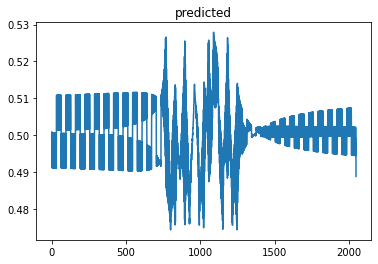

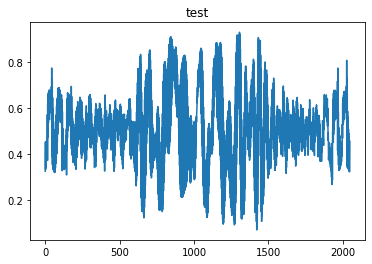

y_f :  [1038.24720304 +0.j           -6.98794955 -7.3264104j
   11.87159159+11.98096749j ...   -5.75757774+15.00819942j
   11.87159159-11.98096749j   -6.98794955 +7.3264104j ]
y_f.shape :  (2048,)
y_f :  [[[1038.24720304 +0.j        ]
  [  -6.98794955 -7.3264104j ]
  [  11.87159159+11.98096749j]
  ...
  [  -5.75757774+15.00819942j]
  [  11.87159159-11.98096749j]
  [  -6.98794955 +7.3264104j ]]]
y_f.shape :  (1, 2048, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
y_f_im :  [[[1045.57361344 -6.98794955j]
  [  26.87979101 +6.22338974j]
  [  13.5255295 +17.74713334j]
  ...
  [ -16.70093982 +7.55453078j]
  [  -8.27830574-17.64566446j]
  [   4.54518119-18.96891704j]]]
y_f_im.shape :  (1, 2048, 1)
y_pred_f :  [ 1.02414729e+03+0.j          1.23931468e+00+0.34584153j
 -8.13404783e-01-0.64103897j ... -3.01018080e-01-0.84593615j
 -8.13404783e-01+0.64103897j  1.23931468e+00-0.34584153j]
y_pred_f.shape :  (2048,)
y_pred_f :  [[[ 1.02414729e+03+0.j        ]
  [ 1.23931468e+00+0.34584153j]
  [

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


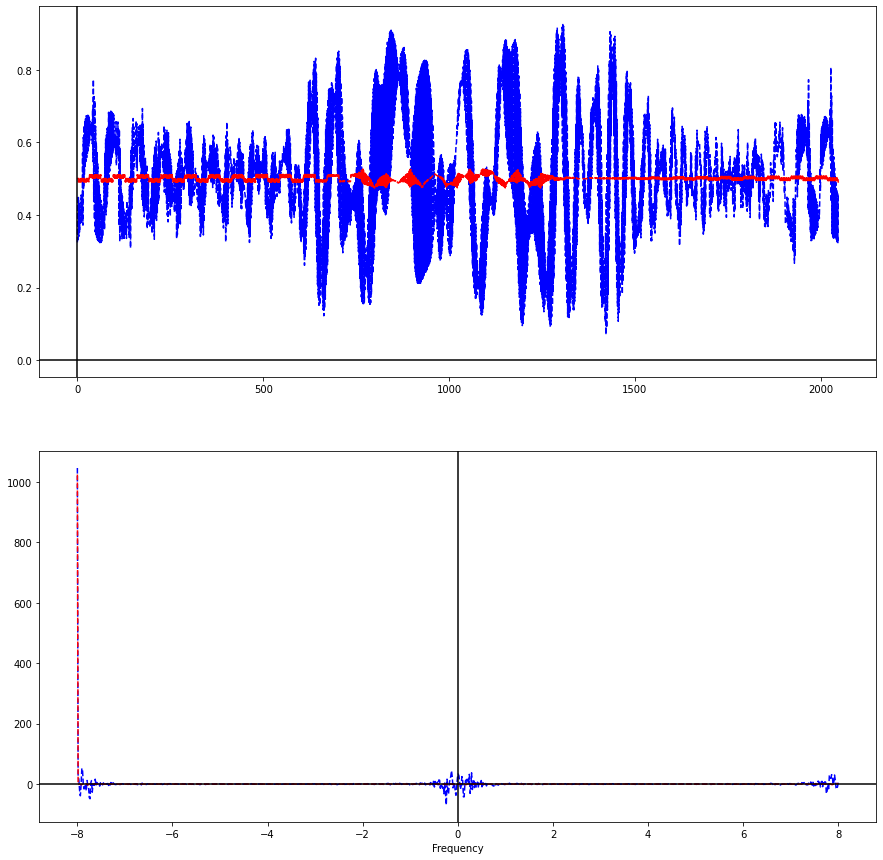

In [ ]:
# testing the model
index_pred = -16494
with_error_plots = True
y_pred = test_model(model_dense_full_minmax, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

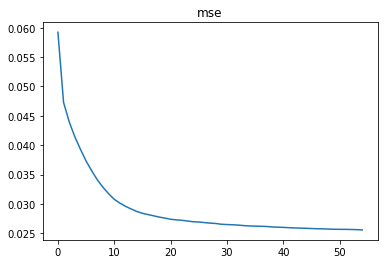

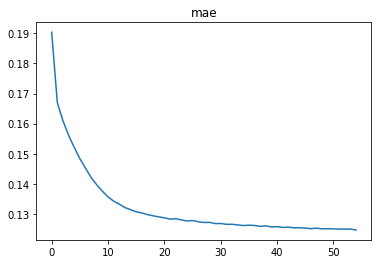

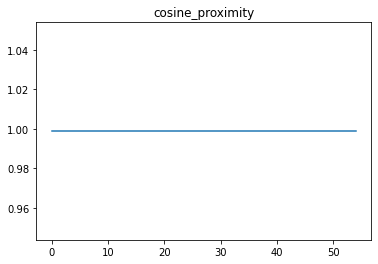

X_test.shape :  (250, 2048, 1)
y_test.shape :  (250, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.42231235]
 [0.48450506]
 [0.41057009]
 ...
 [0.60103464]
 [0.4263225 ]
 [0.5009929 ]]
y_pred.shape :  (2048, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
y_test_im.shape :  (1024,)
y_pred_im.shape :  (1024,)
y_.shape :  (2048,)
y_pred.shape :  (2048,)


y_ :  [0.26362355 0.33791057 0.14737598 ... 0.45755368 0.33402382 0.24228896]
y_test_im :  [0.26362355+0.33791057j 0.14737598+0.45252484j 0.14775534+0.45094581j ...
 0.15503613+0.45645298j 0.1544065 +0.45755368j 0.33402382+0.24228896j]
y_pred :  [0.42231235 0.48450506 0.41057009 ... 0.60103464 0.4263225  0.5009929 ]
y_pred_im :  [0.42231235+0.48450506j 0.41057009+0.602275j   0.4105702 +0.6022683j  ...
 0.40885442+0.6010263j  0.4088575 +0.60

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


TypeError: ignored

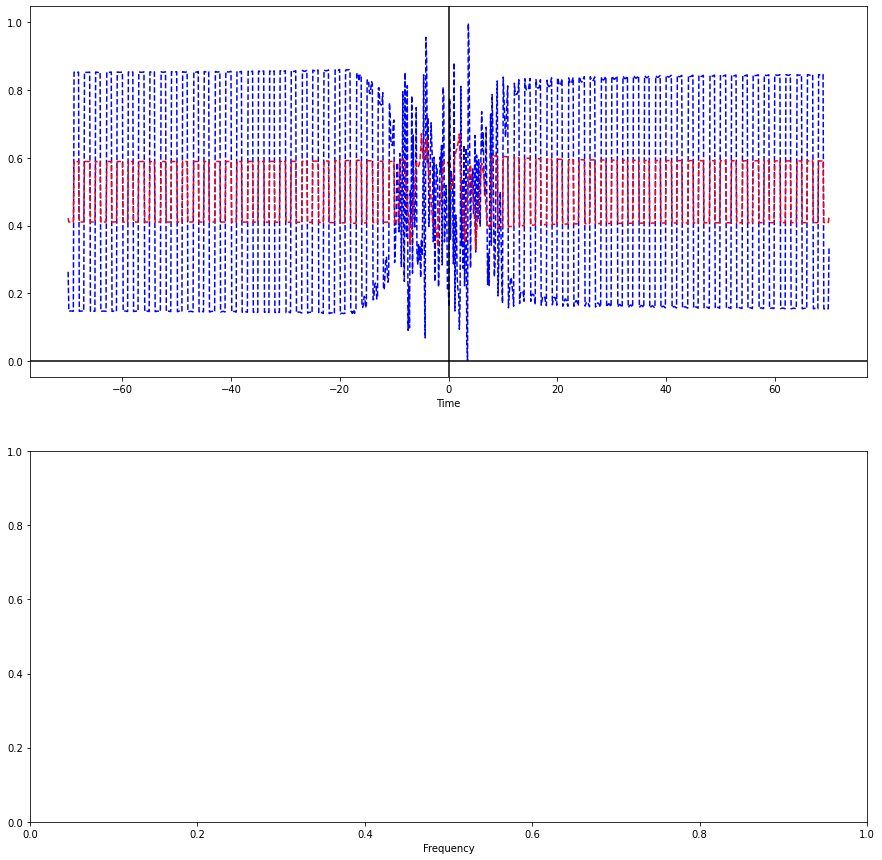

In [ ]:
# testing the model
index_pred = -198
with_error_plots = True
y_pred = test_model(model_dense_full_minmax, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

In [ ]:
# testing the model
index_pred = -1
with_error_plots = False
y_pred = test_model(model_dense_full, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

NameError: ignored

In [ ]:
y_pred

array([[0.7628479 ],
       [0.8705845 ],
       [0.917663  ],
       ...,
       [0.88984257],
       [0.80232626],
       [0.88923883]], dtype=float32)

In [ ]:
y_test[index_pred]

array([[0.41868118],
       [0.61831996],
       [0.41212175],
       ...,
       [0.38424995],
       [0.5850962 ],
       [0.38463718]])

In [ ]:
np.sum(y_pred)/(y_pred[1]*len(y_pred))

#### **With Z-Scaler**

In [ ]:
withReshape = True
ts = 0.25
X_train, X_test, y_train, y_test = prepareTrainAndTestData(df_zsc, withReshape, ts)

In [ ]:
epochs = 5
# Fiting the model
model_dense_full_zsc = create_MLP_CNN(only_dense, opti, customActivationFct, activation_fct, lr, N_output_pred, loss_fct, nbrOfStackedDense, nbrOfStackedCNN, nbrNeuronsDense, nbrFiltersCNN, dropoutDense, dropoutCNN)

In [ ]:
model_dense_full_zsc = train(model_dense_full_zsc, X_train, X_test, y_train, y_test, epochs , batch_size)

In [ ]:
# testing the model
index_pred = -1
with_error_plots = False
y_pred = test_model(model_dense_full_2, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

In [ ]:
model_dense_full.weights

In [ ]:
y_pred

array([[2.3718481e-01],
       [2.4085340e-01],
       [5.1770557e-04],
       ...,
       [2.6522839e-09],
       [3.9441189e-01],
       [4.0914434e-01]], dtype=float32)

In [ ]:
y_test[index_pred]

array([[ 0.50140138],
       [-1.46331905],
       [ 0.59767279],
       ...,
       [ 1.44522801],
       [-0.55755538],
       [ 1.44275879]])

In [ ]:
np.sum(y_pred)/(y_pred[1]*len(y_pred))

array([0.16965835], dtype=float32)

### **Dense & CNN**

In [ ]:
with_error_plots = True 

only_dense = False
customActivationFct = False
lr = 0.0001

nbrOfStackedDense = 3
nbrOfStackedCNN = 5
nbrNeuronsDense = 32
nbrFiltersCNN = 64

dropoutDense, dropoutCNN = 0.15, 0.15

loss_fct = 'mse'
activation_fct = 'sigmoid'
opti = 'sgd'

#### **With min-max scaler**

In [ ]:
withReshape = True
ts = 0.25
X_train, X_test, y_train, y_test = prepareTrainAndTestData(df_minmax, withReshape, ts)

(115000, 2048)
(115000, 2048)
(86250, 2048, 1)
(86250, 2048, 1)
(28750, 2048, 1)
(28750, 2048, 1)


In [ ]:
model_dense_cnn_minmax = create_MLP_CNN(only_dense, opti, customActivationFct, activation_fct, lr, N_output_pred, loss_fct, nbrOfStackedDense, nbrOfStackedCNN, nbrNeuronsDense, nbrFiltersCNN, dropoutDense, dropoutCNN)

{'name': 'SGD', 'learning_rate': 1e-04, 'decay': 0.0, 'momentum': 0.0, 'nesterov': False}
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 2048, 2048)        4096      
_________________________________________________________________
dropout_31 (Dropout)         (None, 2048, 2048)        0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 2048, 2048)        8192      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 2048, 64)          131136    
_________________________________________________________________
dropout_32 (Dropout)         (None, 2048, 64)          0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 2048, 64)          256       
______________________________

In [ ]:
epochs = 30
# Fiting the model
model_dense_cnn_minmax = train(model_dense_cnn_minmax, X_train, X_test, y_train, y_test, epochs , batch_size, earlystopping_patience)

Epoch 1/30
674/674 [==============================] - 237s 350ms/step - loss: 0.0890 - mse: 0.0890 - mae: 0.2440 - cosine_proximity: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.0278 - val_mse: 0.0278 - val_mae: 0.1307 - val_cosine_proximity: 1.0000 - val_cosine_similarity: 1.0000
Epoch 2/30
674/674 [==============================] - 234s 348ms/step - loss: 0.0859 - mse: 0.0859 - mae: 0.2390 - cosine_proximity: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.0278 - val_mse: 0.0278 - val_mae: 0.1306 - val_cosine_proximity: 1.0000 - val_cosine_similarity: 1.0000
Epoch 3/30
674/674 [==============================] - 234s 347ms/step - loss: 0.0838 - mse: 0.0838 - mae: 0.2356 - cosine_proximity: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.0278 - val_mse: 0.0278 - val_mae: 0.1305 - val_cosine_proximity: 1.0000 - val_cosine_similarity: 1.0000
Epoch 4/30
674/674 [==============================] - 234s 347ms/step - loss: 0.0818 - mse: 0.0818 - mae: 0.2325 - cosine_proximity: 1.0000 - 

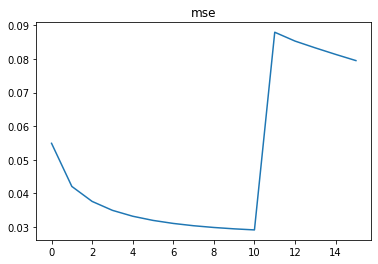

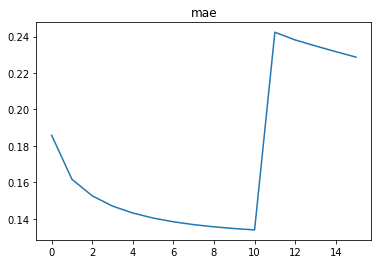

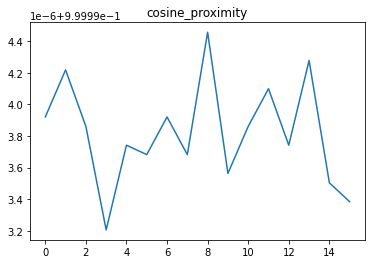

X_test.shape :  (28750, 2048, 1)
y_test.shape :  (28750, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.49544364]
 [0.5026294 ]
 [0.49375692]
 ...
 [0.50645894]
 [0.49171138]
 [0.5102366 ]]
y_pred.shape :  (2048, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
y_test_im.shape :  (1024,)
y_pred_im.shape :  (1024,)
y_.shape :  (2048,)
y_pred.shape :  (2048,)


y_ :  [0.52749428 0.65950238 0.54428153 ... 0.63831448 0.51534429 0.64760136]
y_test_im :  [0.52749428+0.65950238j 0.54428153+0.66921318j 0.5641367 +0.67019095j ...
 0.51037433+0.63528338j 0.50968774+0.63831448j 0.51534429+0.64760136j]
y_pred :  [0.49544364 0.5026294  0.49375692 ... 0.50645894 0.49171138 0.5102366 ]
y_pred_im :  [0.49544364+0.5026294j  0.49375692+0.5070286j  0.49376297+0.50702924j ...
 0.4899308 +0.5064593j  0.48993406+

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


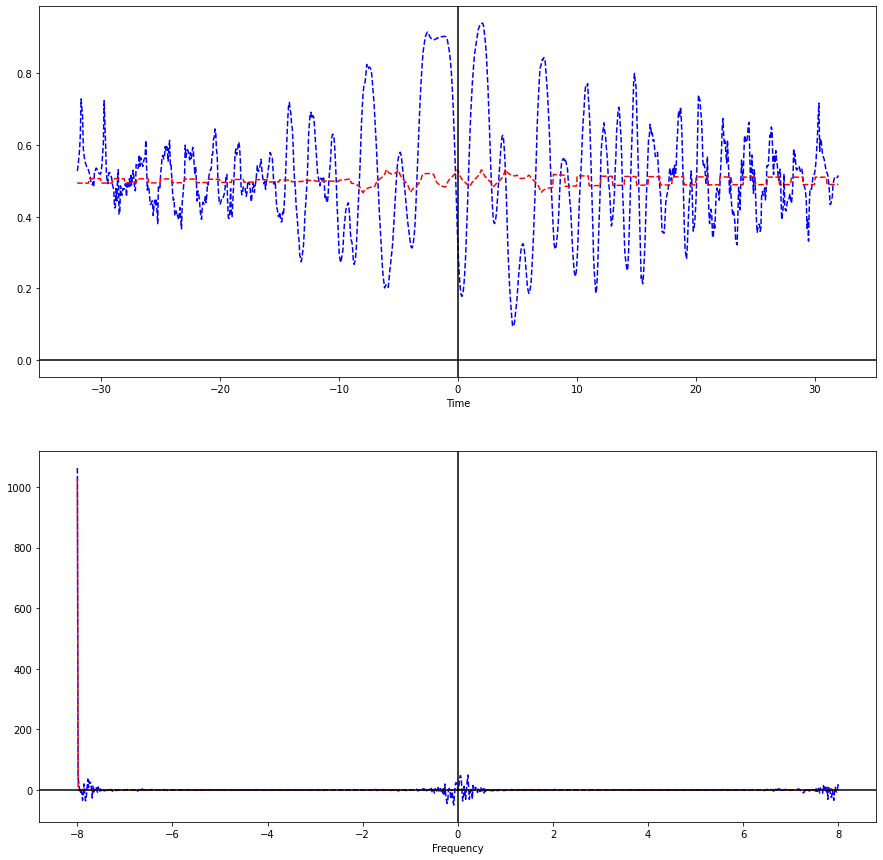

In [ ]:
# testing the model
index_pred = 0
with_error_plots = True
y_pred = test_model(model_dense_cnn_minmax, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

In [ ]:
model_dense_cnn_minmax_full = create_MLP_CNN(only_dense, opti, customActivationFct, activation_fct, lr, N_output_pred, loss_fct, nbrOfStackedDense, nbrOfStackedCNN, nbrNeuronsDense, nbrFiltersCNN, dropoutDense, dropoutCNN)

{'name': 'SGD', 'learning_rate': 0.01, 'decay': 0.0, 'momentum': 0.0, 'nesterov': False}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048, 2048)        4096      
_________________________________________________________________
dropout (Dropout)            (None, 2048, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048, 2048)        8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2048, 128)         262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048, 128)         512       
_________________________________

In [ ]:
epochs = 30
# Fiting the model
model_dense_cnn_minmax_full = train(model_dense_cnn_minmax_full, X_train, X_test, y_train, y_test, epochs , batch_size, earlystopping_patience)

Epoch 1/30
674/674 [==============================] - 285s 376ms/step - loss: 0.0642 - mse: 0.0642 - mae: 0.2023 - cosine_proximity: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.0278 - val_mse: 0.0278 - val_mae: 0.1306 - val_cosine_proximity: 1.0000 - val_cosine_similarity: 1.0000
Epoch 2/30
674/674 [==============================] - 252s 374ms/step - loss: 0.0436 - mse: 0.0436 - mae: 0.1648 - cosine_proximity: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.0278 - val_mse: 0.0278 - val_mae: 0.1307 - val_cosine_proximity: 1.0000 - val_cosine_similarity: 1.0000
Epoch 3/30
674/674 [==============================] - 252s 374ms/step - loss: 0.0385 - mse: 0.0385 - mae: 0.1544 - cosine_proximity: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.0278 - val_mse: 0.0278 - val_mae: 0.1307 - val_cosine_proximity: 1.0000 - val_cosine_similarity: 1.0000
Epoch 4/30
674/674 [==============================] - 252s 374ms/step - loss: 0.0355 - mse: 0.0355 - mae: 0.1482 - cosine_proximity: 1.0000 - 

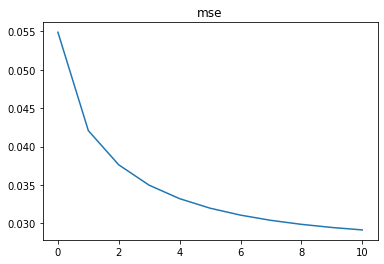

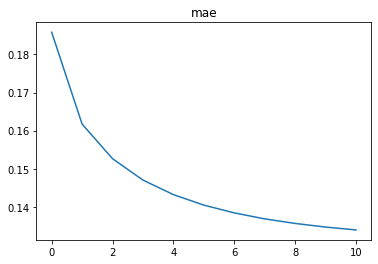

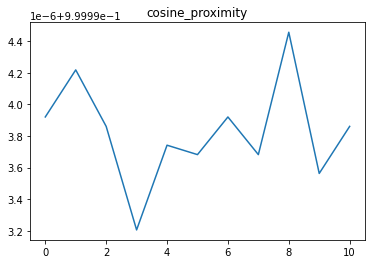

X_test.shape :  (28750, 2048, 1)
y_test.shape :  (28750, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.49692106]
 [0.5028983 ]
 [0.49551785]
 ...
 [0.5060837 ]
 [0.4938162 ]
 [0.50922596]]
y_pred.shape :  (2048, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
y_test_im.shape :  (1024,)
y_pred_im.shape :  (1024,)
y_.shape :  (2048,)
y_pred.shape :  (2048,)


y_ :  [0.52749428 0.65950238 0.54428153 ... 0.63831448 0.51534429 0.64760136]
y_test_im :  [0.52749428+0.65950238j 0.54428153+0.66921318j 0.5641367 +0.67019095j ...
 0.51037433+0.63528338j 0.50968774+0.63831448j 0.51534429+0.64760136j]
y_pred :  [0.49692106 0.5028983  0.49551785 ... 0.5060837  0.4938162  0.50922596]
y_pred_im :  [0.49692106+0.5028983j  0.49551785+0.5065576j  0.4955229 +0.506558j   ...
 0.49233496+0.50608397j 0.49233773+

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


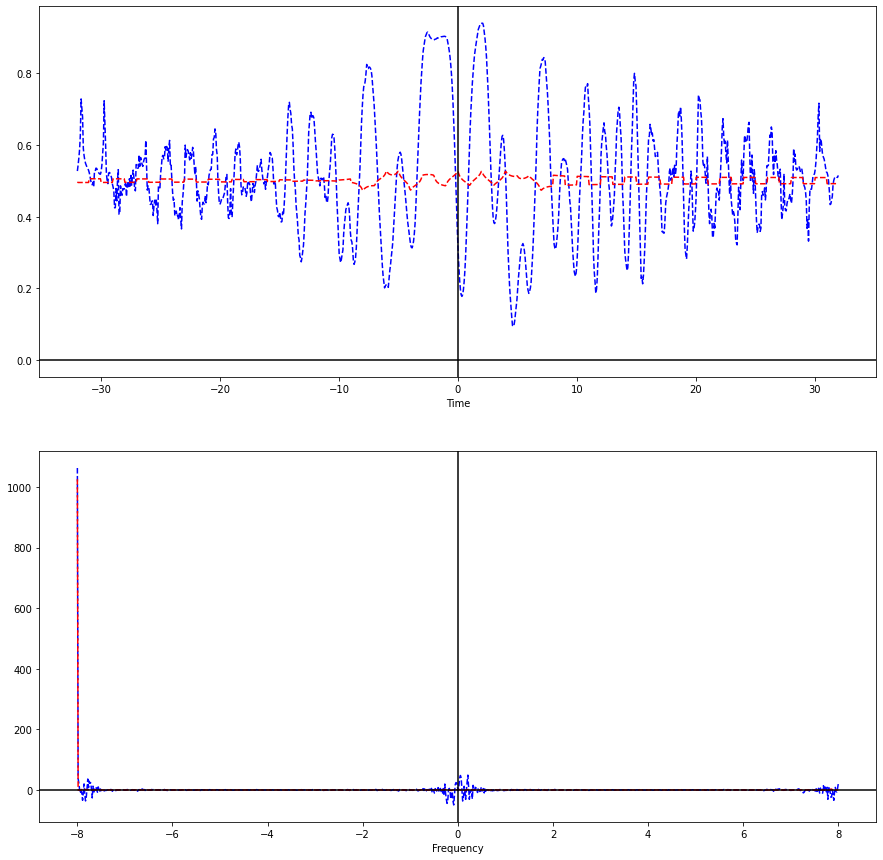

In [ ]:
# testing the model
index_pred = 0
with_error_plots = True
y_pred = test_model(model_dense_cnn_minmax_full, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

In [ ]:
epochs = 10
# Fiting the model
model_dense_cnn_minmax = train(model_dense_cnn_minmax, X_train, X_test, y_train, y_test, epochs , batch_size, earlystopping_patience)

Epoch 1/10
704/704 [==============================] - 82s 76ms/step - loss: 0.0510 - mse: 0.0510 - mae: 0.1761 - cosine_proximity: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.0260 - val_mse: 0.0260 - val_mae: 0.1284 - val_cosine_proximity: 1.0000 - val_cosine_similarity: 1.0000
Epoch 2/10
704/704 [==============================] - 53s 75ms/step - loss: 0.0348 - mse: 0.0348 - mae: 0.1446 - cosine_proximity: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.0260 - val_mse: 0.0260 - val_mae: 0.1286 - val_cosine_proximity: 1.0000 - val_cosine_similarity: 1.0000
Epoch 3/10
704/704 [==============================] - 53s 75ms/step - loss: 0.0315 - mse: 0.0315 - mae: 0.1385 - cosine_proximity: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.0259 - val_mse: 0.0259 - val_mae: 0.1287 - val_cosine_proximity: 1.0000 - val_cosine_similarity: 1.0000
Epoch 4/10
704/704 [==============================] - 53s 75ms/step - loss: 0.0299 - mse: 0.0299 - mae: 0.1354 - cosine_proximity: 1.0000 - cosine_s

X_test.shape :  (7500, 2048, 1)
y_test.shape :  (7500, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.5188265 ]
 [0.49215645]
 [0.51163423]
 ...
 [0.489415  ]
 [0.5052099 ]
 [0.48989424]]
y_pred.shape :  (2048, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
y_test_im.shape :  (1024,)
y_pred_im.shape :  (1024,)
y_.shape :  (2048,)
y_pred.shape :  (2048,)


y_ :  [0.64925821 0.59168026 0.65808699 ... 0.57221824 0.35860541 0.39621412]
y_test_im :  [0.64925821+0.59168026j 0.65808699+0.51687446j 0.66051467+0.51818661j ...
 0.6477809 +0.57628985j 0.64487546+0.57221824j 0.35860541+0.39621412j]
y_pred :  [0.5188265  0.49215645 0.51163423 ... 0.489415   0.5052099  0.48989424]
y_pred_im :  [0.5188265 +0.49215645j 0.51163423+0.48485914j 0.5116313 +0.48485616j ...
 0.51398337+0.48942024j 0.51398027+0.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


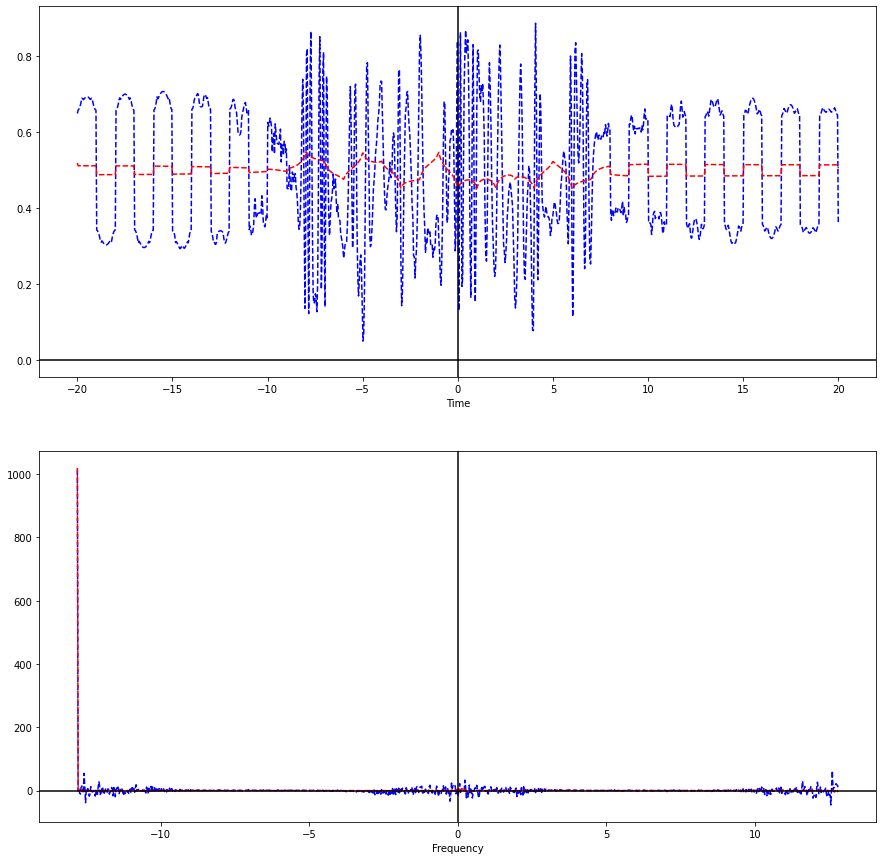

In [ ]:
# testing the model
index_pred = 654
with_error_plots = False
y_pred = test_model(model_dense_cnn_minmax, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

In [ ]:
with_error_plots = True 

only_dense = False
customActivationFct = False
lr = None
batch_size = 64

nbrOfStackedDense = 2
nbrOfStackedCNN = 7
nbrNeuronsDense = 16
nbrFiltersCNN = 256

dropoutDense, dropoutCNN = 0, 0

loss_fct = tf.keras.losses.Huber()  #'mse'
activation_fct = 'sigmoid'
opti = tf.keras.optimizers.SGD(nesterov=True)#'sgd'

# Model
model_dense_cnn_minmax_3 = create_MLP_CNN(only_dense, opti, customActivationFct, activation_fct, lr, N_output_pred, loss_fct, nbrOfStackedDense, nbrOfStackedCNN, nbrNeuronsDense, nbrFiltersCNN, dropoutDense, dropoutCNN)

epochs = 30
# Fiting the model
model_dense_cnn_minmax_3 = train(model_dense_cnn_minmax_3, X_train, X_test, y_train, y_test, epochs , batch_size)

{'name': 'SGD', 'learning_rate': 0.01, 'decay': 0.0, 'momentum': 0.0, 'nesterov': True}
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_218 (Dense)            (None, 2048, 64)          128       
_________________________________________________________________
dropout_304 (Dropout)        (None, 2048, 64)          0         
_________________________________________________________________
batch_normalization_272 (Bat (None, 2048, 64)          256       
_________________________________________________________________
conv1d_120 (Conv1D)          (None, 2048, 256)         16640     
_________________________________________________________________
dropout_305 (Dropout)        (None, 2048, 256)         0         
_________________________________________________________________
batch_normalization_273 (Bat (None, 2048, 256)         1024      
_______________________________

X_test.shape :  (15000, 2048, 1)
y_test.shape :  (15000, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.50108457]
 [0.5010147 ]
 [0.49783587]
 ...
 [0.501709  ]
 [0.50420445]
 [0.49523914]]
y_pred.shape :  (2048, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
y_test_im.shape :  (1024,)
y_pred_im.shape :  (1024,)
y_.shape :  (2048,)
y_pred.shape :  (2048,)


y_ :  [0.55497873 0.5756432  0.55330331 ... 0.42212142 0.44598624 0.42188209]
y_test_im :  [0.55497873+0.5756432j  0.55330331+0.57758082j 0.44373122+0.42778815j ...
 0.55518586+0.57509487j 0.44587445+0.42212142j 0.44598624+0.42188209j]
y_pred :  [0.50108457 0.5010147  0.49783587 ... 0.501709   0.50420445 0.49523914]
y_pred_im :  [0.50108457+0.5010147j  0.49783587+0.501709j   0.501568  +0.49769562j ...
 0.50157154+0.4976949j  0.49783564+

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


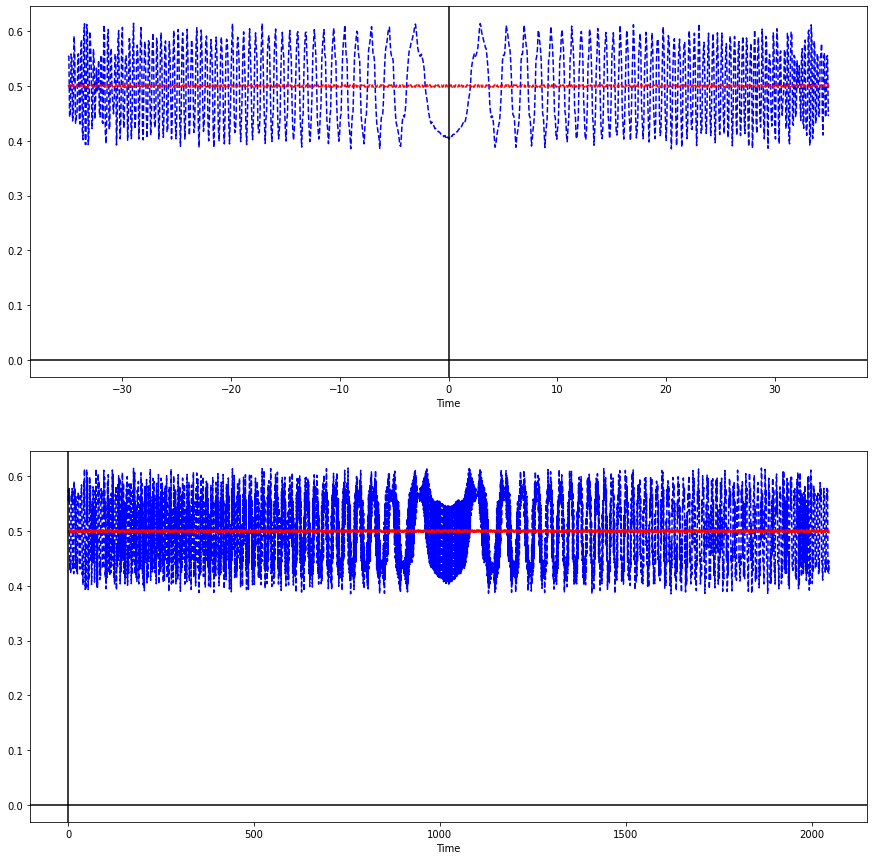

In [ ]:
# testing the model
index_pred = -1
with_error_plots = False
y_pred = test_model(model_dense_cnn_minmax_3, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

X_test.shape :  (15000, 2048, 1)
y_test.shape :  (15000, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.49116817]
 [0.4915247 ]
 [0.5082547 ]
 ...
 [0.48789176]
 [0.47480103]
 [0.52188885]]
y_pred.shape :  (2048, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
y_test_im.shape :  (1024,)
y_pred_im.shape :  (1024,)
y_.shape :  (2048,)
y_pred.shape :  (2048,)


y_ :  [0.55497873 0.5756432  0.55330331 ... 0.42212142 0.44598624 0.42188209]
y_test_im :  [0.55497873+0.5756432j  0.55330331+0.57758082j 0.44373122+0.42778815j ...
 0.55518586+0.57509487j 0.44587445+0.42212142j 0.44598624+0.42188209j]
y_pred :  [0.49116817 0.4915247  0.5082547  ... 0.48789176 0.47480103 0.52188885]
y_pred_im :  [0.49116817+0.4915247j  0.5082547 +0.48789176j 0.4886312 +0.5089941j  ...
 0.4886314 +0.508995j   0.5082547 +

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


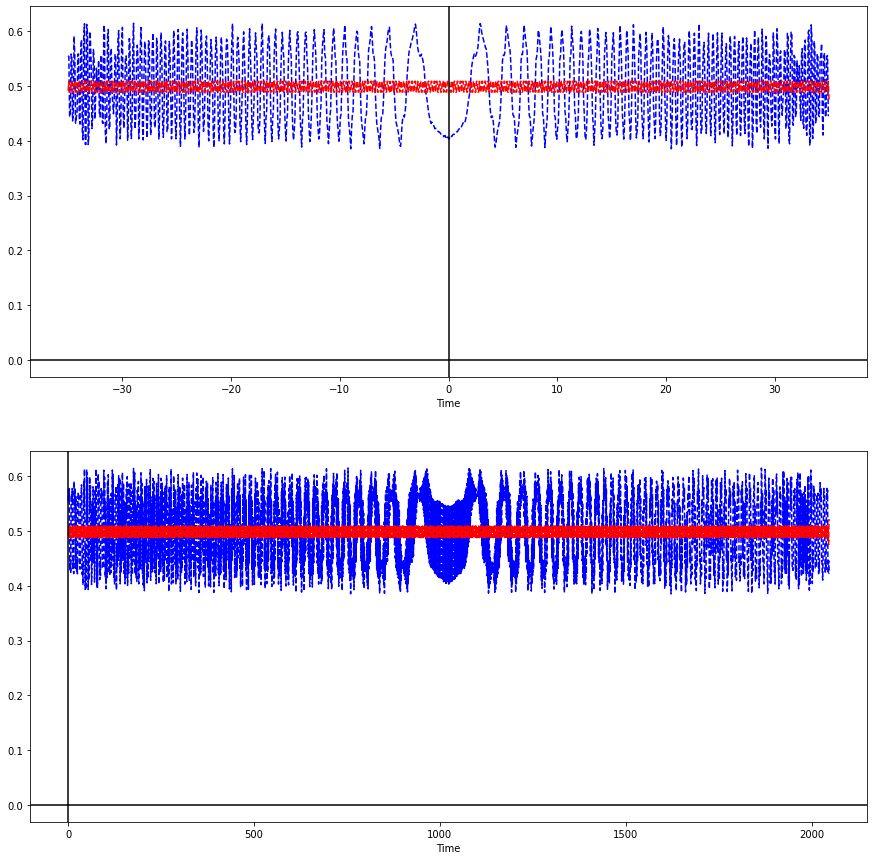

In [ ]:
# testing the model
index_pred = -1
with_error_plots = False
y_pred = test_model(model_dense_cnn_minmax_2, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

X_test.shape :  (15000, 2048, 1)
y_test.shape :  (15000, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.5068476 ]
 [0.50057364]
 [0.23594178]
 ...
 [0.5641568 ]
 [0.76504654]
 [0.10570443]]
y_pred.shape :  (2048, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
y_test_im.shape :  (1024,)
y_pred_im.shape :  (1024,)
y_.shape :  (2048,)
y_pred.shape :  (2048,)


y_ :  [0.55497873 0.5756432  0.55330331 ... 0.42212142 0.44598624 0.42188209]
y_test_im :  [0.55497873+0.5756432j  0.55330331+0.57758082j 0.44373122+0.42778815j ...
 0.55518586+0.57509487j 0.44587445+0.42212142j 0.44598624+0.42188209j]
y_pred :  [0.5068476  0.50057364 0.23594178 ... 0.5641568  0.76504654 0.10570443]
y_pred_im :  [0.5068476 +0.50057364j 0.23594178+0.5641568j  0.55131423+0.22668894j ...
 0.5513112 +0.22667743j 0.23594168+

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


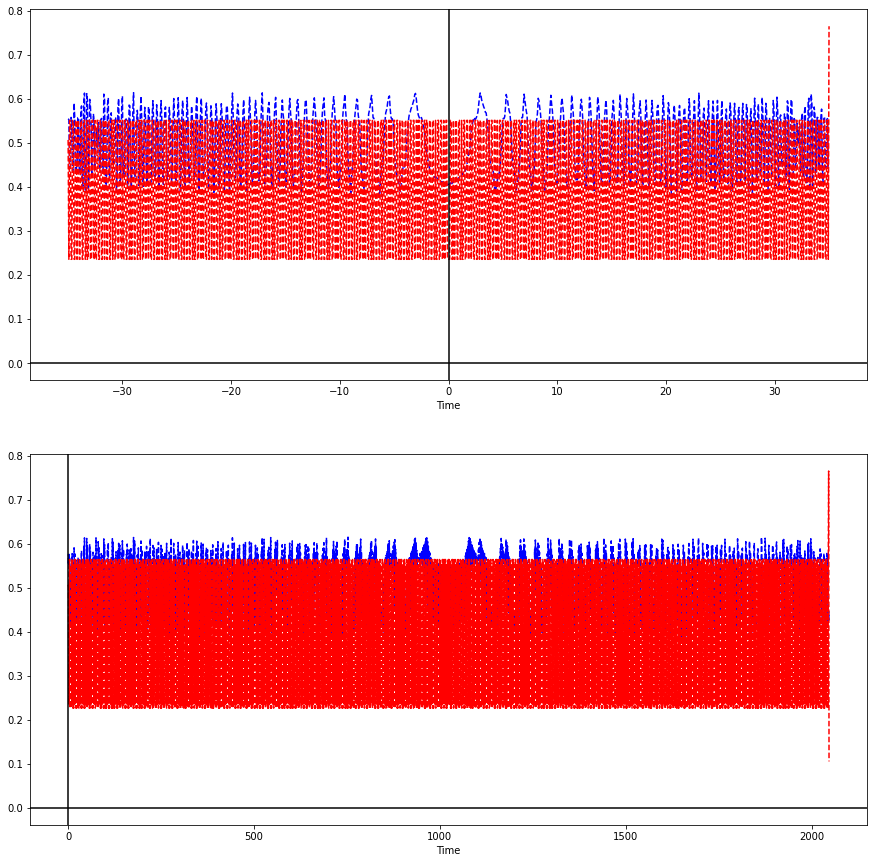

In [ ]:
# testing the model
index_pred = -1
with_error_plots = False
y_pred = test_model(model_dense_cnn_minmax, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

### CNN-20epo

In [ ]:
epochs = 20
# Fiting the model
model_dense_cnn = train(model_dense_cnn, X_train, X_test, y_train, y_test, epochs , batch_size)

Epoch 1/20
352/352 [==============================] - 90s 256ms/step - loss: 1.0077 - mse: 1.0077 - mae: 0.8013 - cosine_proximity: 1.0366e-04 - msle: 0.1532 - val_loss: 1.1131 - val_mse: 1.1131 - val_mae: 0.8209 - val_cosine_proximity: -2.5490e-04 - val_msle: 0.1577
Epoch 2/20
352/352 [==============================] - 89s 254ms/step - loss: 1.0027 - mse: 1.0027 - mae: 0.7994 - cosine_proximity: 1.0366e-04 - msle: 0.1636 - val_loss: 1.0073 - val_mse: 1.0073 - val_mae: 0.7997 - val_cosine_proximity: -2.5490e-04 - val_msle: 0.1670
Epoch 3/20
352/352 [==============================] - 89s 254ms/step - loss: 1.0011 - mse: 1.0011 - mae: 0.7987 - cosine_proximity: 1.0366e-04 - msle: 0.1690 - val_loss: 1.0063 - val_mse: 1.0063 - val_mae: 0.7994 - val_cosine_proximity: -2.5490e-04 - val_msle: 0.1715
Epoch 4/20
352/352 [==============================] - 89s 254ms/step - loss: 1.0003 - mse: 1.0003 - mae: 0.7984 - cosine_proximity: 1.0366e-04 - msle: 0.1724 - val_loss: 1.0057 - val_mse: 1.0057 -

X_test.shape :  (15000, 2048, 1)
y_test.shape :  (15000, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.0095441 ]
 [0.00831803]
 [0.01936297]
 ...
 [0.03261735]
 [0.01025091]
 [0.0078587 ]]
y_pred.shape :  (2048, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
y_test_im.shape :  (1024,)
y_pred_im.shape :  (1024,)
y_.shape :  (2048,)
y_pred.shape :  (2048,)


y_ :  [ 2.01475351  0.05466522  2.00644788 ... -0.12412681 -2.01102334
 -0.13310471]
y_test_im :  [ 2.01475351+0.05466522j  2.00644788+0.1897594j  -2.01498805+0.0524797j
 ...  2.01516887+0.03758189j -2.01160197-0.12412681j
 -2.01102334-0.13310471j]
y_pred :  [0.0095441  0.00831803 0.01936297 ... 0.03261735 0.01025091 0.0078587 ]
y_pred_im :  [0.0095441 +0.00831803j 0.01936297+0.0326551j  0.01269986+0.00747514j ...
 0.01269348+0.00746611

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


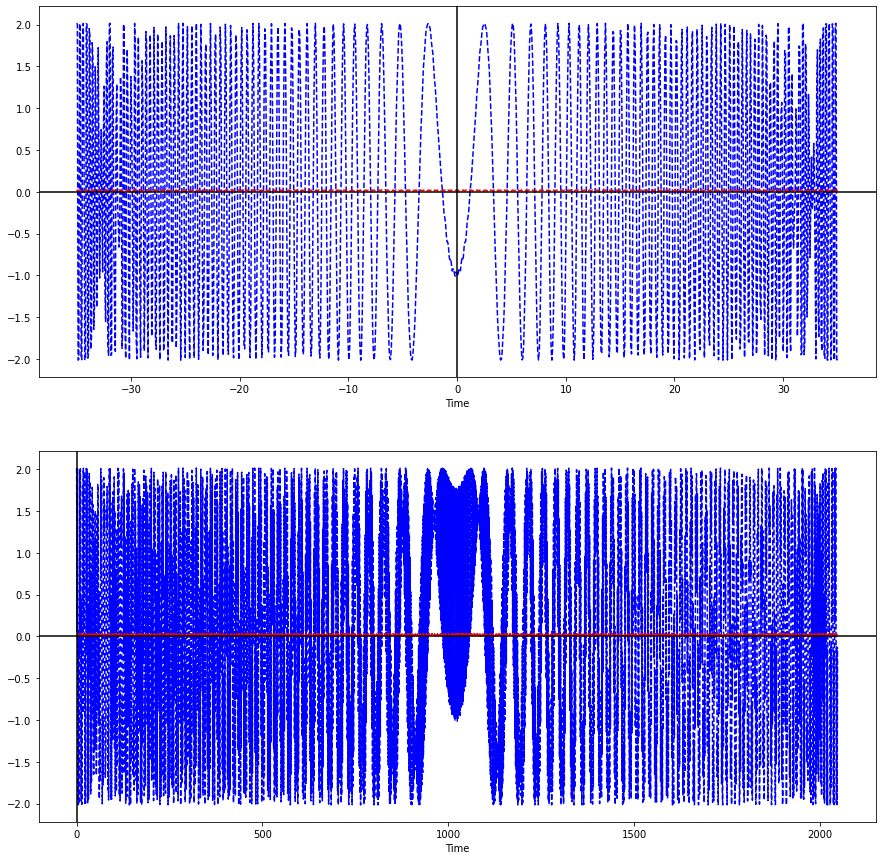

In [ ]:
# testing the model
index_pred = 9595
with_error_plots = False
y_pred = test_model(model_dense_cnn, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

### CNN-1epo

In [ ]:
epochs = 1
# Fiting the model
model_dense_cnn = train(model_dense_cnn, X_train, X_test, y_train, y_test, epochs , batch_size)

X_test.shape :  (15000, 2048, 1)
y_test.shape :  (15000, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[1.5839407e-05]
 [9.9997163e-01]
 [9.9934024e-01]
 ...
 [1.7020812e-07]
 [5.2293479e-02]
 [9.9997234e-01]]
y_pred.shape :  (2048, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
y_test_im.shape :  (1024,)
y_pred_im.shape :  (1024,)
y_.shape :  (2048,)
y_pred.shape :  (2048,)


y_ :  [-1.54450358 -1.94308932 -1.4115483  ...  1.99530333  1.46816275
  2.00188733]
y_test_im :  [-1.54450358-1.94308932j -1.4115483 -2.04255341j  1.64494801+1.85811788j
 ... -1.56080531-1.92990241j  1.47702648+1.99530333j
  1.46816275+2.00188733j]
y_pred :  [1.5839407e-05 9.9997163e-01 9.9934024e-01 ... 1.7020812e-07 5.2293479e-02
 9.9997234e-01]
y_pred_im :  [1.5839407e-05+9.9997163e-01j 9.9934024e-01+1.7020812e-07j

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


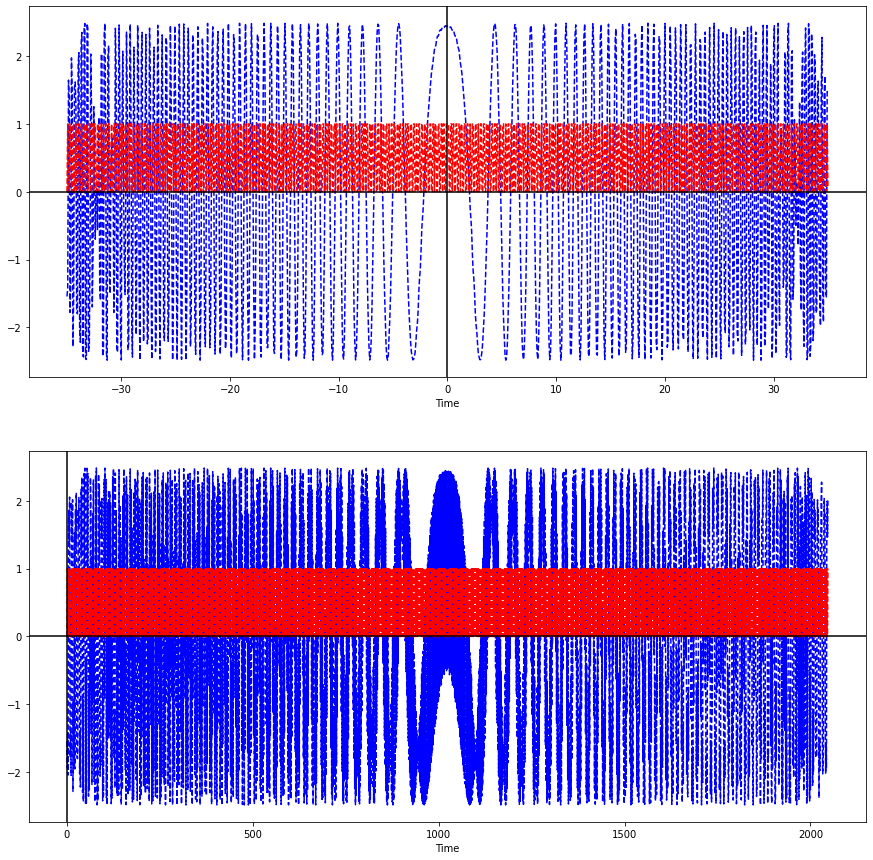

In [ ]:
# testing the model
index_pred = -1
with_error_plots = False
y_pred = test_model(model_dense_cnn, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

In [ ]:
y_pred

array([[1.5839407e-05],
       [9.9997163e-01],
       [9.9934024e-01],
       ...,
       [1.7020812e-07],
       [5.2293479e-02],
       [9.9997234e-01]], dtype=float32)

### CNN-200epo

In [ ]:
with_error_plots = True 

only_dense = False
customActivationFct = False
lr = None

nbrOfStackedDense = 7
nbrOfStackedCNN = 110
nbrNeuronsDense = 32
nbrFiltersCNN = 32

dropoutDense, dropoutCNN = 0, 0

loss_fct = 'mse'
activation_fct = 'relu'
opti = 'rmsprop'

model_dense_cnn_200ep = create_MLP_CNN(only_dense, opti, customActivationFct, activation_fct, lr, N_output_pred, loss_fct, nbrOfStackedDense, nbrOfStackedCNN, nbrNeuronsDense, nbrFiltersCNN, dropoutDense, dropoutCNN)

{'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_240 (Dense)            (None, 2048, 64)          128       
_________________________________________________________________
dropout_296 (Dropout)        (None, 2048, 64)          0         
_________________________________________________________________
batch_normalization_159 (Bat (None, 2048, 64)          256       
_________________________________________________________________
dense_241 (Dense)            (None, 2048, 32)          2080      
_________________________________________________________________
dropout_297 (Dropout)        (None, 2048, 32)          0         
_________________________________________________________________
batch_normalization_160 (Bat (None, 2048, 32)          128   

In [ ]:
epochs = 5
# Fiting the model
model_dense_cnn_200ep = train(model_dense_cnn_200ep, X_train, X_test, y_train, y_test, epochs , batch_size)

Epoch 1/5
352/352 [==============================] - 134s 325ms/step - loss: 1.0699 - mse: 1.0699 - mae: 0.8256 - cosine_proximity: 9.9505e-05 - msle: 0.1482 - val_loss: 1.0188 - val_mse: 1.0188 - val_mae: 0.8008 - val_cosine_proximity: -2.7461e-04 - val_msle: 0.1793
Epoch 2/5
352/352 [==============================] - 111s 314ms/step - loss: 0.9883 - mse: 0.9883 - mae: 0.7931 - cosine_proximity: 1.7299e-04 - msle: 0.1913 - val_loss: 1.0045 - val_mse: 1.0045 - val_mae: 0.7986 - val_cosine_proximity: -2.5544e-04 - val_msle: 0.1914
Epoch 3/5
352/352 [==============================] - 110s 314ms/step - loss: 0.9992 - mse: 0.9992 - mae: 0.7985 - cosine_proximity: 1.9615e-04 - msle: 0.1934 - val_loss: 1.5296 - val_mse: 1.5296 - val_mae: 1.0018 - val_cosine_proximity: 0.0026 - val_msle: 0.2502
Epoch 4/5
352/352 [==============================] - 110s 314ms/step - loss: 1.0029 - mse: 1.0029 - mae: 0.7991 - cosine_proximity: -2.2609e-05 - msle: 0.1937 - val_loss: 1.0820 - val_mse: 1.0820 - val

X_test.shape :  (45000, 2048, 1)
y_test.shape :  (45000, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[3.6933102e-06]
 [2.7286986e-04]
 [1.5757173e-04]
 ...
 [1.4857753e-05]
 [1.6476084e-05]
 [4.0160699e-04]]
y_pred.shape :  (2048, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
y_test_im.shape :  (1024,)
y_pred_im.shape :  (1024,)
y_.shape :  (2048,)
y_pred.shape :  (2048,)


y_ :  [ 0.52850823  1.62367662  0.41918396 ... -1.64102169 -0.46534038
 -1.64312215]
y_test_im :  [ 0.52850823+1.62367662j  0.41918396+1.65564347j -0.61344083-1.59317139j
 ...  0.54216097+1.6191157j  -0.47260939-1.64102169j
 -0.46534038-1.64312215j]
y_pred :  [3.6933102e-06 2.7286986e-04 1.5757173e-04 ... 1.4857753e-05 1.6476084e-05
 4.0160699e-04]
y_pred_im :  [3.69331019e-06+2.72869860e-04j 1.57571732e-04+1.48579511e

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


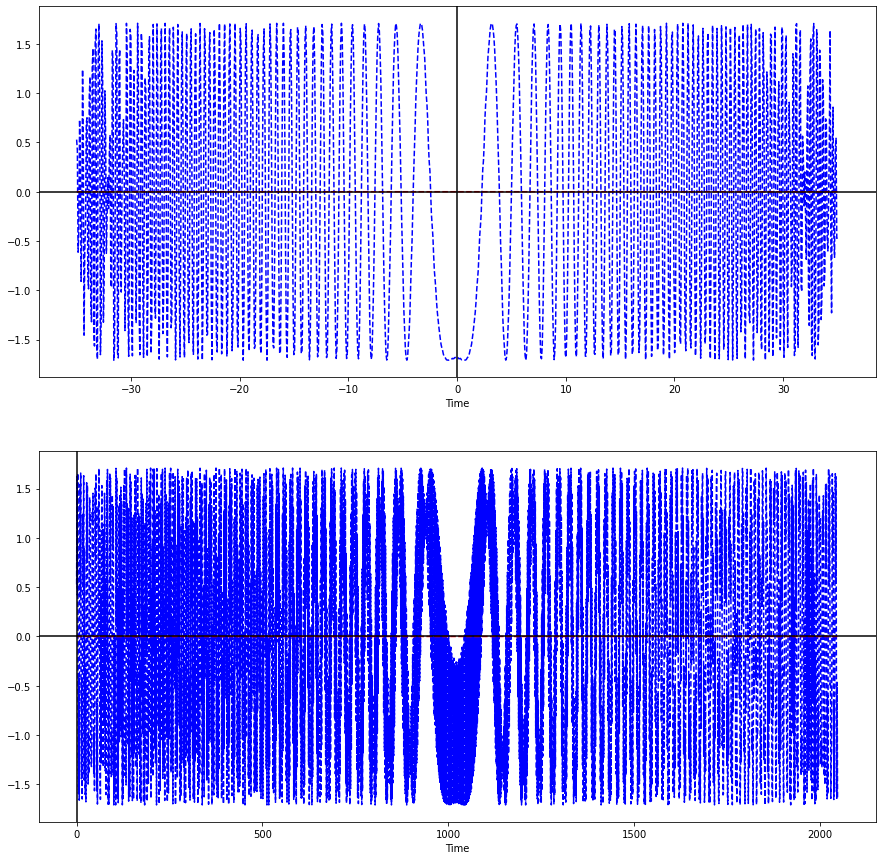

In [ ]:
# testing the model
index_pred = 1089
with_error_plots = False
y_pred = test_model(model_dense_cnn_200ep, X_train, y_train, history, index_pred, with_error_plots)
test_prediction(y_train, y_pred, index_pred, parameters)

In [ ]:
y_pred

array([[1.5811718e-04],
       [3.5150439e-05],
       [2.0351032e-05],
       ...,
       [2.7850461e-05],
       [8.0708858e-05],
       [2.9275920e-05]], dtype=float32)

In [ ]:
np.var(X_test[index_pred])

1.0771286940255362

In [ ]:
np.var(y_test[index_pred])

1.0762441477155273

X_test.shape :  (15000, 2048, 1)
y_test.shape :  (15000, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[1.2477558]
 [1.2477576]
 [1.2477578]
 ...
 [1.2475696]
 [1.2477576]
 [1.2477555]]
y_pred.shape :  (2048, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
y_test_im.shape :  (1024,)
y_pred_im.shape :  (1024,)
y_.shape :  (2048,)
y_pred.shape :  (2048,)


y_ :  [0.39011991 0.4190017  0.39615594 ... 0.58495349 0.60640421 0.58550204]
y_test_im :  [0.39011991+0.4190017j  0.39615594+0.40956044j 0.61452836+0.57492691j ...
 0.38937218+0.41997238j 0.60680595+0.58495349j 0.60640421+0.58550204j]
y_pred :  [1.2477558 1.2477576 1.2477578 ... 1.2475696 1.2477576 1.2477555]
y_pred_im :  [1.2477558+1.2477576j 1.2477578+1.2475696j 1.2477568+1.2477576j ...
 1.2477572+1.2477576j 1.2477578+1.2475696j 1.2477576+

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


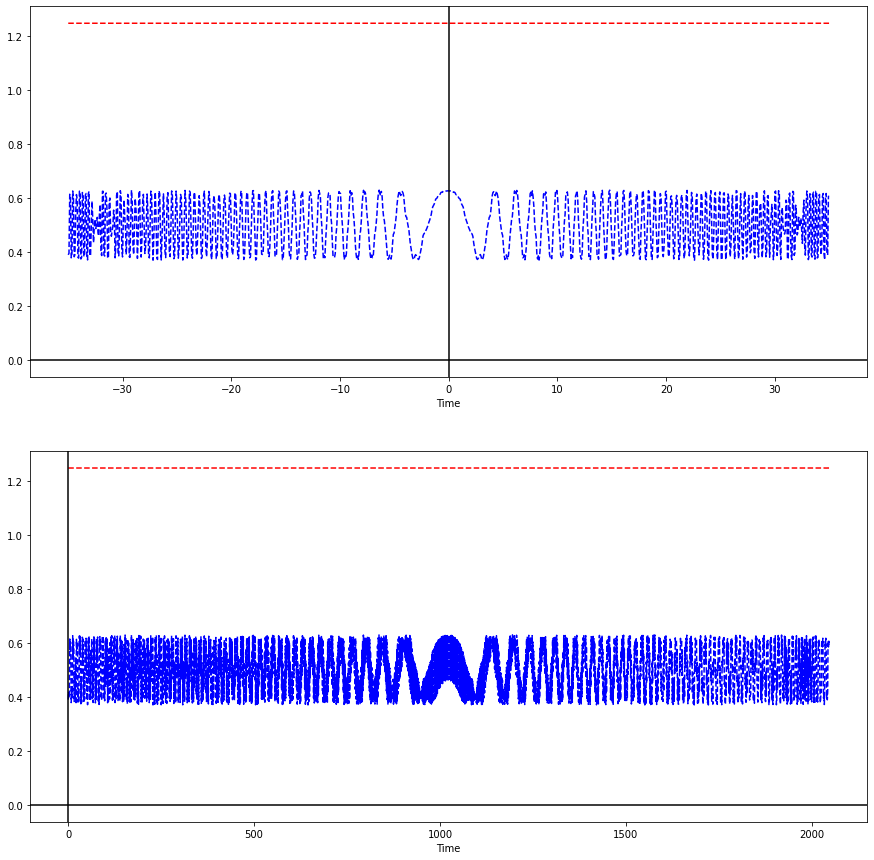

In [ ]:
# testing the model
index_pred = 100
with_error_plots = False
y_pred = test_model(model_dense_cnn, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
y_pred_im.shape :  (1024,)
y_pred.shape :  (2048,)




/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


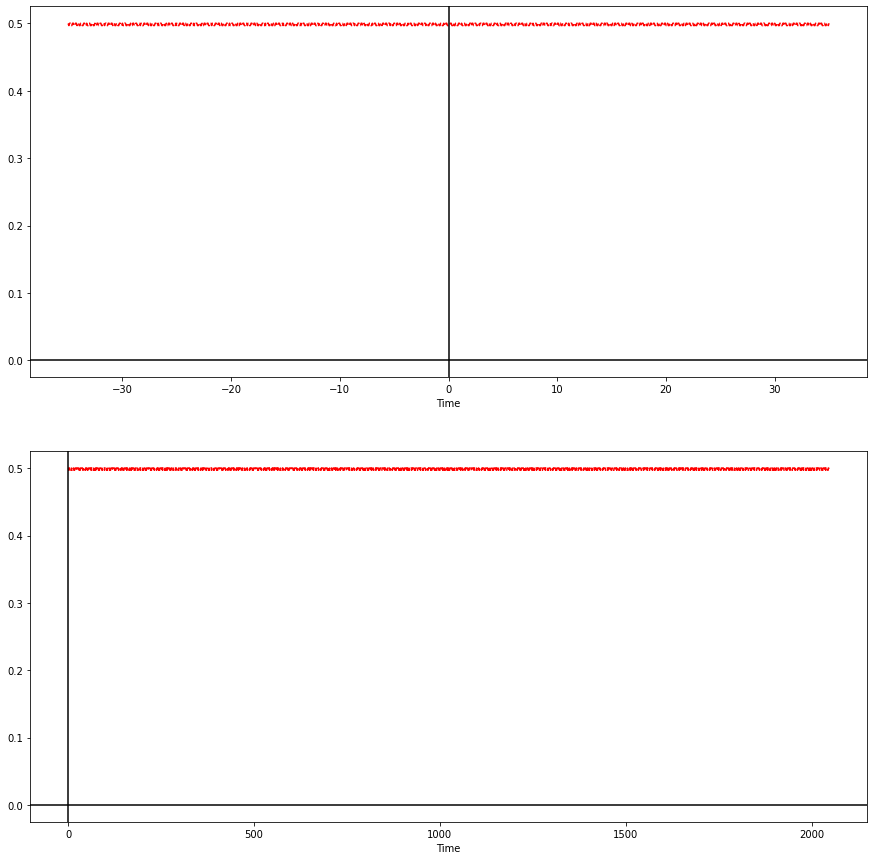

In [ ]:
test_ypred(y_pred, parameters)

In [ ]:
np.sum(y_pred)/(y_pred[0]*len(y_pred))

array([0.9996035], dtype=float32)

In [ ]:
yx = y_pred - y_test
yx

array([[[-0.10590568],
        [ 0.06199363],
        [-0.1139306 ],
        ...,
        [-0.05728353],
        [ 0.10932373],
        [-0.0568421 ]],

       [[ 0.19837884],
        [ 0.00241415],
        [ 0.19892415],
        ...,
        [-0.00849684],
        [-0.19989642],
        [-0.00946032]],

       [[ 0.17814424],
        [-0.14283557],
        [ 0.18787643],
        ...,
        [ 0.13774165],
        [-0.18495184],
        [ 0.13689321]],

       ...,

       [[ 0.01126706],
        [ 0.0335951 ],
        [ 0.00689831],
        ...,
        [-0.03303105],
        [-0.00995413],
        [-0.03312947]],

       [[-0.11877371],
        [ 0.18614033],
        [-0.13511465],
        ...,
        [-0.18119486],
        [ 0.12698067],
        [-0.18071238]],

       [[-0.04777307],
        [ 0.06561572],
        [-0.05514298],
        ...,
        [-0.06299483],
        [ 0.05081449],
        [-0.06282418]]])

## **CNN-1D**

In [ ]:
#-----------------------------------------------------------------------------------------------------#

def my_activation(x):
        """ Computes the activation of a neuron.
            @param x : data.

            Should use Keras function for stability of the tensors.
        """
        dz = parameters.z/parameters.nz
        return x*K.exp(dz*K.abs(x)**2)

#-----------------------------------------------------------------------------------------------------#

def create_CNN1D(only_dense, customActivationFct, lr, loss_fct, nbrOfStackedCNN, nbrFiltersCNN, dropoutDense, dropoutCNN):

  if lr != None :
    K.set_value(model_dense.optimizer.learning_rate, lr)

  # custom activation function
  if customActivationFct :
    get_custom_objects().update({'my_activation': Activation(my_activation)})
  
  # Model
  model_cnn1D= Sequential()

  # Convolution layers


  # 1st CNN layer should include input shape
  model_cnn1D.add(Conv1D(filters=nbrFiltersCNN, kernel_size=1 ,strides=1, input_shape=X_train.shape[1:], kernel_initializer= 'uniform')) 
  model_cnn1D.add(LeakyReLU())
  model_cnn1D.add(Dropout(dropoutCNN))

  # go up to 10 layers of CNN
  for i in range(nbrOfStackedCNN):
    
    model_cnn1D.add(Conv1D(filters=nbrFiltersCNN, kernel_size=1 ,strides=1,  kernel_initializer= 'uniform', activation='relu'))
    model_cnn1D.add(Dropout(dropoutCNN))

    

  # Fully connected layers
  for i in range(nbrOfStackedDense) :
    model_cnn1D.add(Dense(nbrNeuronsDense, kernel_initializer='normal', activation='relu'))
    model_cnn1D.add(Dropout(dropoutDense))
  

  # Output layer
  model_cnn1D.add(Dense(1))
  if customActivationFct :
    model_cnn1D.add(Activation(my_activation, name='SpecialActivation'))
  else :
    model_cnn1D.add(Activation('relu'))

  # Compile the model
  model_cnn1D.compile(loss=loss_fct, 
                      optimizer='adam', 
                      metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity', 'msle'])
  
  print(model_cnn1D.optimizer.get_config())
  print(model_cnn1D.summary())
  print("model_dense.output_shape : ",model_cnn1D.output_shape)

  return model_cnn1D

#-----------------------------------------------------------------------------------------------------#

In [ ]:
X_train.shape[1:]

(1500, 1)

## **LSTM**

In [ ]:
inputs=inputShape

In [ ]:
#-----------------------------------------------------------------------------------------------------#

def create_LSTM(only_dense, customActivationFct, use_batchlr, loss_fct, nbrOfStackedLSTM, nbrOfStackedDense, nbrNeuronsLSTM, dropoutDense, dropoutLSTM):

  if lr != None :
    K.set_value(model_dense.optimizer.learning_rate, lr)

  # custom activation function
  if customActivationFct :
    get_custom_objects().update({'my_activation': Activation(my_activation)})

  # Model
  model_lstm = Sequential()

  # Input Layer
  #model_lstm.add(Input(shape=inputShape))

  # Input layer - 1st  layer should include input shape
  #model_lstm.add(Dense(X_train.shape[1], kernel_initializer='normal', input_shape=X_train.shape[1:]))
  model_lstm.add(Dense(nbrNeuronsDense,   kernel_initializer='normal',input_shape=X_train.shape[1:], activation='sigmoid'))
  #model_lstm.add(LeakyReLU())
  model_lstm.add(Dropout(dropoutDense))
  #model_lstm.add(BatchNormalization())

  # LSTM layers

  # go up to 10 layers of LSTM
  for i in range(nbrOfStackedLSTM):    
    model_lstm.add(LSTM(nbrNeuronsLSTM, return_sequences=True))
    model_lstm.add(LeakyReLU())
    model_lstm.add(Dropout(dropoutLSTM))
    #model_lstm.add(BatchNormalization())

    

  # Fully connected layers
  for i in range(nbrOfStackedDense) :
    model_lstm.add(Dense(nbrNeuronsDense,  kernel_initializer='normal', activation='sigmoid'))
    model_lstm.add(Dropout(dropoutDense))
    #model_lstm.add(BatchNormalization())


  # Output layer
  model_lstm.add(Dense(1))
  if customActivationFct :
    model_lstm.add(Activation(my_activation, name='SpecialActivation'))
  else :
    model_lstm.add(Activation('sigmoid'))

  # Compile the model
  model_lstm.compile(loss=loss_fct, 
                      optimizer='adam', 
                      metrics=['mean_absolute_error'])

  print(model_lstm.optimizer.get_config())
  print(model_lstm.summary())
  print("model_dense.output_shape : ",model_lstm.output_shape)

  return model_lstm

  #-----------------------------------------------------------------------------------------------------#

In [ ]:
with_error_plots = True 

only_dense = False
customActivationFct = False
lr = None

nbrOfStackedDense = 3
nbrOfStackedLSTM = 1
nbrNeuronsDense = 5
nbrNeuronsLSTM = 10

dropoutDense, dropoutLSTM = 0, 0

loss_fct = 'mse'

model_lstm_big_ts = create_LSTM(only_dense, customActivationFct, lr, loss_fct, nbrOfStackedLSTM, nbrOfStackedDense, nbrNeuronsLSTM, dropoutDense, dropoutLSTM)

{'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 2048, 5)           10        
_________________________________________________________________
dropout_21 (Dropout)         (None, 2048, 5)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 2048, 10)          640       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 2048, 10)          0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 2048, 10)          0         
_________________________________________________________________
dense_52 (Dense)             (None, 2048, 5)           55     

In [ ]:
epochs = 10
# Fiting the model
model_lstm_big_ts = train(model_lstm_big_ts, x_tr, x_te, y_tr, y_te, epochs , batch_size)

Epoch 1/10
5/5 [==============================] - 3s 383ms/step - loss: 0.8728 - mean_absolute_error: 0.7254 - val_loss: 0.8791 - val_mean_absolute_error: 0.7222
Epoch 2/10
5/5 [==============================] - 0s 77ms/step - loss: 0.8533 - mean_absolute_error: 0.7163 - val_loss: 0.8722 - val_mean_absolute_error: 0.7168
Epoch 3/10
5/5 [==============================] - 0s 77ms/step - loss: 0.8497 - mean_absolute_error: 0.7117 - val_loss: 0.8654 - val_mean_absolute_error: 0.7115
Epoch 4/10
5/5 [==============================] - 0s 77ms/step - loss: 0.8474 - mean_absolute_error: 0.7075 - val_loss: 0.8587 - val_mean_absolute_error: 0.7062
Epoch 5/10
5/5 [==============================] - 0s 77ms/step - loss: 0.8459 - mean_absolute_error: 0.7026 - val_loss: 0.8521 - val_mean_absolute_error: 0.7008
Epoch 6/10
5/5 [==============================] - 0s 77ms/step - loss: 0.8417 - mean_absolute_error: 0.6999 - val_loss: 0.8456 - val_mean_absolute_error: 0.6955
Epoch 7/10
5/5 [=================

In [ ]:
model_lstm_big_ts.weights

100%|██████████| 1/1 [00:00<00:00, 169.38it/s]

X_test.shape :  (25, 2048, 1)
y_test.shape :  (25, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.42190787]
 [0.42190784]
 [0.42190787]
 ...
 [0.42190784]
 [0.42190787]
 [0.42190784]]
y_pred.shape :  (2048, 1)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)


y_test :  [ 5.18846010e-16 -6.05462643e-16  3.07428210e-02 ... -1.65373252e-02
  6.59089675e-16 -3.70037765e-17]


y_pred :  [0.42190787 0.42190784 0.42190787 ... 0.42190784 0.42190787 0.42190784]


diff :  [[[-0.42190787]
  [-0.42190784]
  [-0.39116505]
  ...
  [-0.43844517]
  [-0.42190787]
  [-0.42190784]]]
mse test :  0.8175849002889581




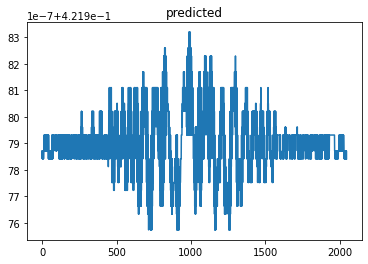

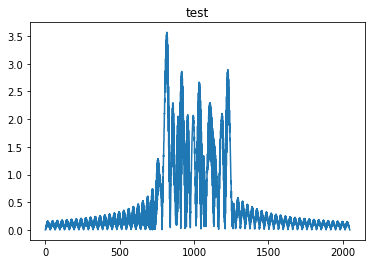

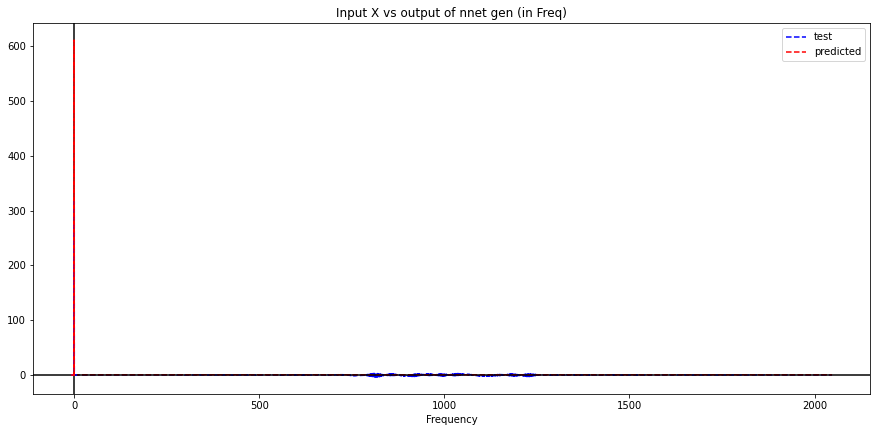

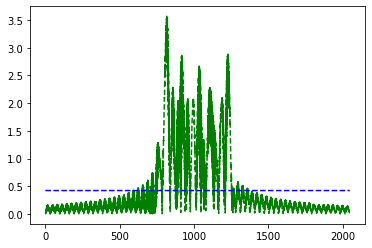

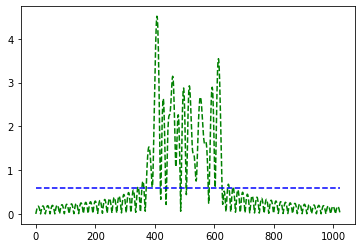

In [ ]:
# testing the model
index_pred = 0
with_error_plots = False
y_pred = test_model(model_lstm_big_ts, x_te, y_te, history, index_pred, with_error_plots)
test_prediction(y_te, y_pred, index_pred, parameters)

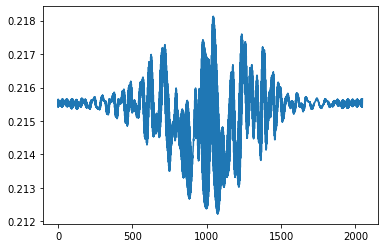

In [ ]:
plt.plot(y_pred)

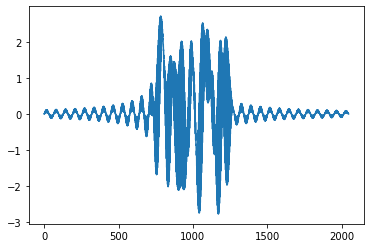

In [ ]:
plt.plot(y_test[index_pred])

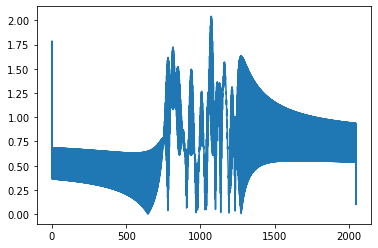

In [ ]:
#std scaler
plt.plot(abs(y_test[654]))

In [ ]:
model_lstm_std = create_LSTM(only_dense, customActivationFct, lr, loss_fct, nbrOfStackedLSTM, nbrOfStackedDense, nbrNeuronsLSTM, dropoutDense, dropoutLSTM)

{'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2048, 64)          128       
_________________________________________________________________
dropout_11 (Dropout)         (None, 2048, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2048, 128)         98816     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2048, 128)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048, 128)         0         
_________________________________________________________________
dense_11 (Dense)             (None, 2048, 64)          8256    

In [ ]:
epochs = 2
# Fiting the model
model_lstm_std = train(model_lstm_std, X_train, X_test, y_train, y_test, epochs , batch_size)

Epoch 1/2
2344/2344 [==============================] - 240s 102ms/step - loss: 1.0016 - mean_absolute_error: 0.8248 - val_loss: 1.0093 - val_mean_absolute_error: 0.8271
Epoch 2/2
2344/2344 [==============================] - 237s 101ms/step - loss: 0.9793 - mean_absolute_error: 0.8147 - val_loss: 0.9310 - val_mean_absolute_error: 0.7841


100%|██████████| 1/1 [00:00<00:00, 160.73it/s]

X_test.shape :  (25000, 2048, 1)
y_test.shape :  (25000, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.00056599]
 [0.00017638]
 [0.00064799]
 ...
 [0.00018028]
 [0.00050972]
 [0.00017869]]
y_pred.shape :  (2048, 1)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)


y_test :  [-0.77881317  0.21963703  0.38183005 ...  1.24387718  0.85024563
  0.98164195]


y_pred :  [0.00056599 0.00017638 0.00064799 ... 0.00018028 0.00050972 0.00017869]


diff :  [[[-0.77937916]
  [ 0.21946066]
  [ 0.38118207]
  ...
  [ 1.2436969 ]
  [ 0.84973591]
  [ 0.98146326]]]
mse test :  0.7561728205291842




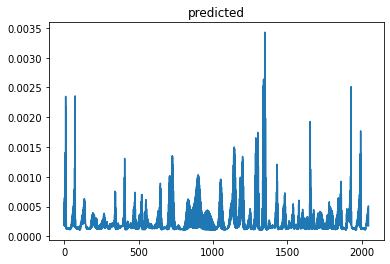

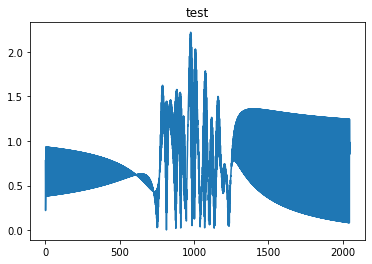

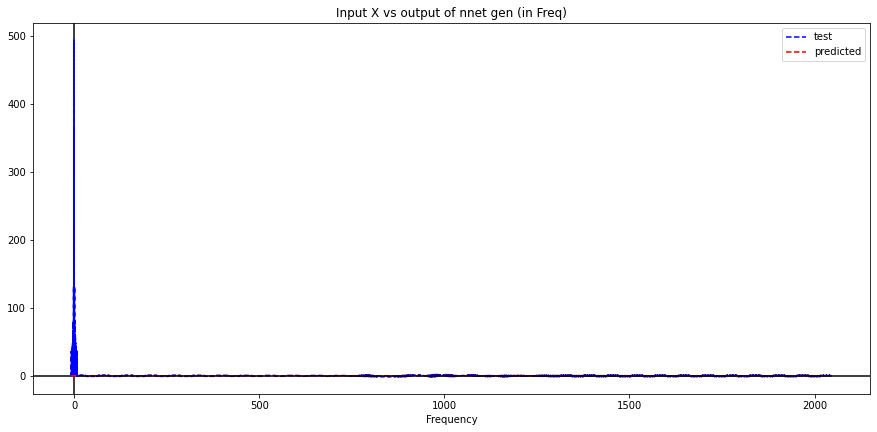

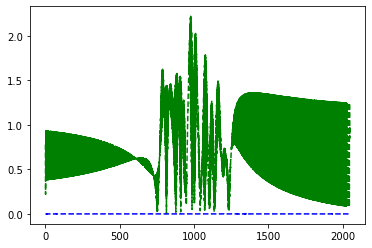

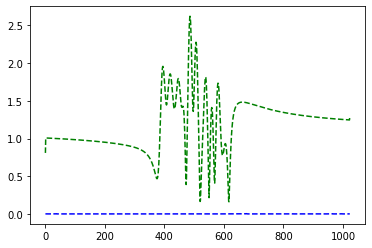

In [ ]:
# testing the model
index_pred = 100
with_error_plots = False
y_pred = test_model(model_lstm_std, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

In [ ]:
tf.profiler.experimental.stop()

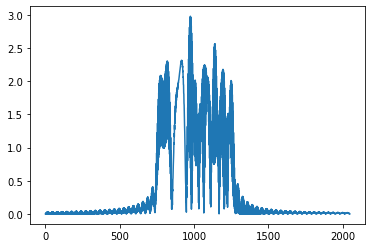

In [ ]:
# no scaling
plt.plot(abs(y_test[654]))

In [ ]:
epochs = 20
# Fiting the model
model_lstm2 = train(model_lstm2, X_train, X_test, y_train, y_test, epochs , batch_size)

Epoch 1/20
586/586 [==============================] - 97s 165ms/step - loss: 0.6226 - mean_absolute_error: 0.4053 - val_loss: 0.6227 - val_mean_absolute_error: 0.4053
Epoch 2/20
586/586 [==============================] - 95s 162ms/step - loss: 0.6225 - mean_absolute_error: 0.4049 - val_loss: 0.6226 - val_mean_absolute_error: 0.4052
Epoch 3/20
586/586 [==============================] - 95s 163ms/step - loss: 0.6225 - mean_absolute_error: 0.4048 - val_loss: 0.6226 - val_mean_absolute_error: 0.4052
Epoch 4/20
586/586 [==============================] - 95s 162ms/step - loss: 0.6225 - mean_absolute_error: 0.4047 - val_loss: 0.6226 - val_mean_absolute_error: 0.4051
Epoch 5/20
586/586 [==============================] - 95s 162ms/step - loss: 0.6225 - mean_absolute_error: 0.4047 - val_loss: 0.6226 - val_mean_absolute_error: 0.4051
Epoch 6/20
586/586 [==============================] - 95s 162ms/step - loss: 0.6225 - mean_absolute_error: 0.4047 - val_loss: 0.6226 - val_mean_absolute_error: 0.405

100%|██████████| 1/1 [00:00<00:00, 163.20it/s]

X_test.shape :  (25000, 2048, 1)
y_test.shape :  (25000, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.61070037]
 [0.6107    ]
 [0.6107003 ]
 ...
 [0.6107    ]
 [0.61070037]
 [0.6107    ]]
y_pred.shape :  (2048, 1)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)


y_ :  [-7.85377934e-16  1.32188663e-17  8.34959971e-04 ... -2.18121608e-02
  6.66600311e-16 -7.76650606e-16]
y_test_im :  [-7.8537795e-16+1.32188665e-17j  8.3495997e-04-2.20497940e-02j
  1.6537216e-03-4.33405936e-02j ... -8.4941806e-03-4.28716876e-02j
 -4.3171979e-03-2.18121614e-02j  6.6660032e-16-7.76650597e-16j]
y_pred :  [0.61070037 0.6107     0.6107003  ... 0.6107     0.61070037 0.6107    ]
y_pred_im :

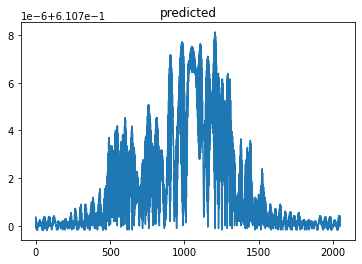

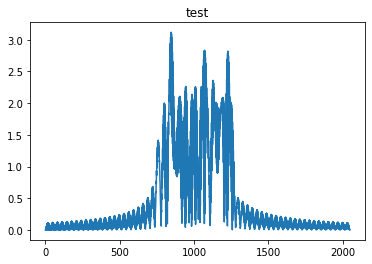

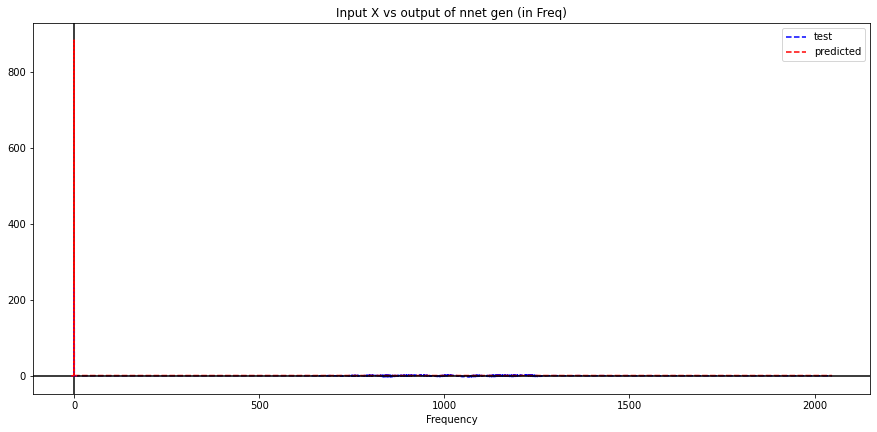

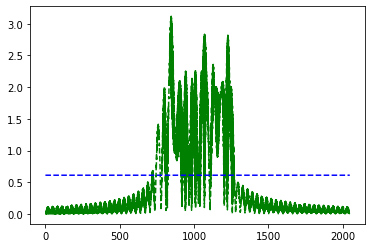

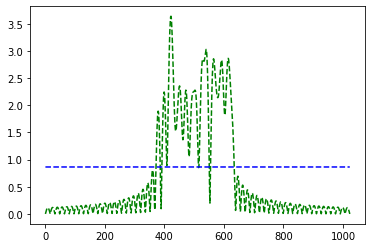

In [ ]:
# testing the model
index_pred = 100
with_error_plots = False
y_pred = test_model(model_lstm, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

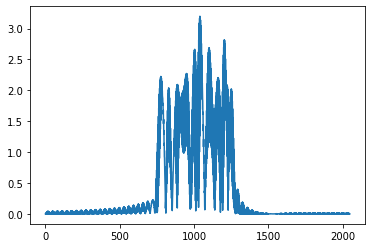

In [ ]:
plt.plot(np.abs(y_test[0]))

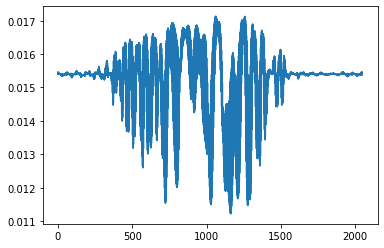

In [ ]:
plt.plot(np.abs(y_pred))
#plt.plot(np.abs(y_test[0]))
plt.show()

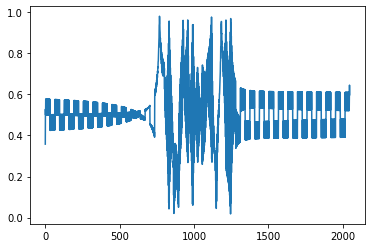

In [ ]:
plt.plot(y_test[index_pred])

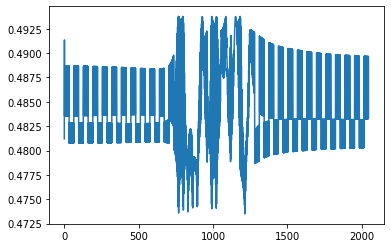

In [ ]:
plt.plot(np.abs(y_pred))

In [ ]:
model_lstm_min_max = create_LSTM(only_dense, customActivationFct, lr, loss_fct, nbrOfStackedLSTM, nbrOfStackedDense, nbrNeuronsLSTM, dropoutDense, dropoutLSTM)

{'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2048, 64)          128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2048, 128)         98816     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2048, 128)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048, 128)         0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048, 64)          8256    

In [ ]:
withReshape = True
ts = 0.25
X_train, X_test, y_train, y_test = prepareTrainAndTestData(df_minmax, withReshape, ts)

[INFO] - {prepareTrainAndTestData} converting from pandas to numpy...
(100000, 2048)
(100000, 2048)
(75000, 2048, 1)
(75000, 2048, 1)
(25000, 2048, 1)
(25000, 2048, 1)


In [ ]:
epochs = 5
# Fiting the model
model_lstm_min_max = train(model_lstm_min_max, X_train, X_test, y_train, y_test, epochs , batch_size)

Epoch 1/5
586/586 [==============================] - 99s 166ms/step - loss: 0.0275 - mean_absolute_error: 0.1315 - val_loss: 0.0272 - val_mean_absolute_error: 0.1305
Epoch 2/5
586/586 [==============================] - 96s 163ms/step - loss: 0.0273 - mean_absolute_error: 0.1309 - val_loss: 0.0271 - val_mean_absolute_error: 0.1301
Epoch 3/5
586/586 [==============================] - 96s 163ms/step - loss: 0.0271 - mean_absolute_error: 0.1303 - val_loss: 0.0269 - val_mean_absolute_error: 0.1290
Epoch 4/5
586/586 [==============================] - 96s 164ms/step - loss: 0.0268 - mean_absolute_error: 0.1284 - val_loss: 0.0267 - val_mean_absolute_error: 0.1282
Epoch 5/5
586/586 [==============================] - 95s 163ms/step - loss: 0.0265 - mean_absolute_error: 0.1273 - val_loss: 0.0266 - val_mean_absolute_error: 0.1279


100%|██████████| 1/1 [00:00<00:00, 148.38it/s]

X_test.shape :  (25000, 2048, 1)
y_test.shape :  (25000, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.50236964]
 [0.49937385]
 [0.5017127 ]
 ...
 [0.5001868 ]
 [0.5025973 ]
 [0.49973395]]
y_pred.shape :  (2048, 1)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)


y_ :  [0.67297092 0.32128086 0.61953691 ... 0.29344876 0.54898982 0.38294471]
y_test_im :  [0.6729709 +0.32128087j 0.61953694+0.34370387j 0.6194724 +0.3437503j  ...
 0.6728265 +0.29339957j 0.6727741 +0.29344875j 0.54898983+0.3829447j ]
y_pred :  [0.50236964 0.49937385 0.5017127  ... 0.5001868  0.5025973  0.49973395]
y_pred_im :  [0.50236964+0.49937385j 0.5017127 +0.49931264j 0.5007145 +0.49976867j ...
 0.5

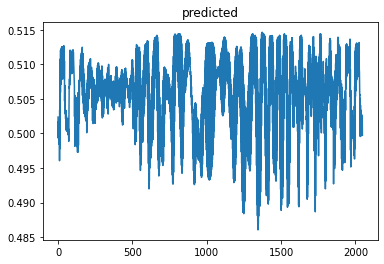

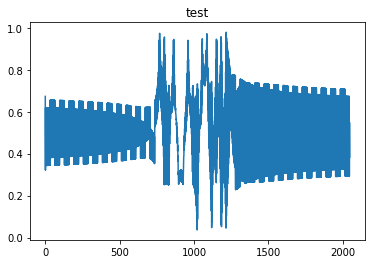

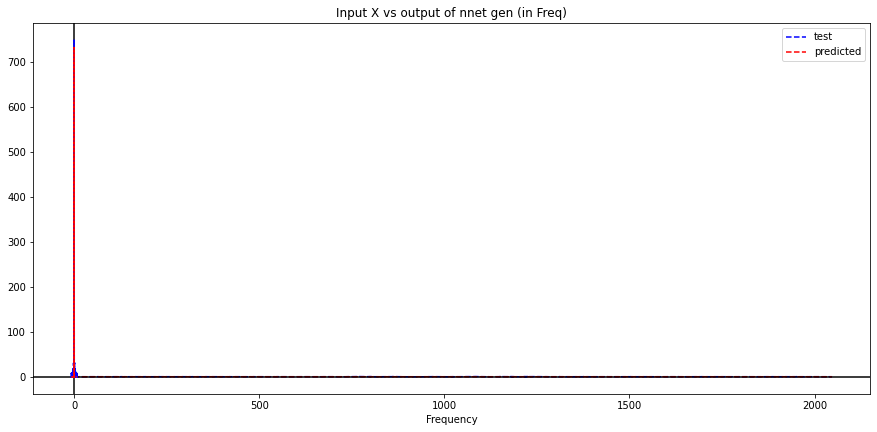

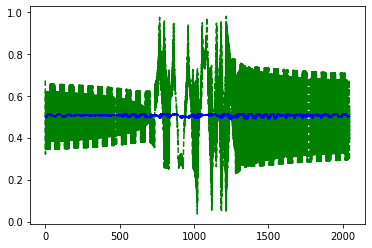

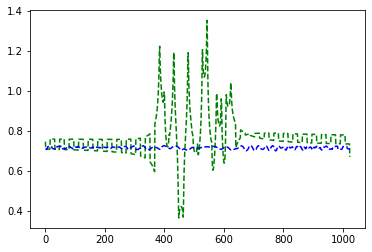

In [ ]:
# testing the model
index_pred = 100
with_error_plots = False
y_pred = test_model(model_lstm_min_max, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

In [ ]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


## **LSTM-CNN**

In [ ]:
#-----------------------------------------------------------------------------------------------------#

def create_LSTM_CNN(customActivationFct, lr, loss_fct, nbrOfStackedLSTM, nbrOfStackedDense, nbrNeuronsLSTM, nbrOfStackedCNN, nbrFiltersCNN, dropoutDense, dropoutLSTM, dropoutCNN):

  if lr != None :
    K.set_value(model_dense.optimizer.learning_rate, lr)

  # custom activation function
  if customActivationFct :
    get_custom_objects().update({'my_activation': Activation(my_activation)})

  # Model
  model_lstm_cnn = Sequential()

  # Input Layer ----------------------------------------------------------------------------------------------------------#
  # 1st Dense layer should include input shape
  #model_lstm_cnn.add(Dense(X_train.shape[1], kernel_initializer='normal', input_shape=X_train.shape[1:]))
  model_lstm_cnn.add(Dense(nbrNeuronsDense, kernel_initializer='normal', input_shape=X_train.shape[1:]))
  model_lstm_cnn.add(LeakyReLU())
  model_lstm_cnn.add(Dropout(dropoutDense))
  model_lstm_cnn.add(BatchNormalization())
  

  # LSTM layers ----------------------------------------------------------------------------------------------------------#

  # go up to 10 layers of LSTM
  for i in range(nbrOfStackedLSTM):

    if i == 0 :
      model_lstm_cnn.add(LSTM(nbrNeuronsLSTM, return_sequences=True))
      model_lstm_cnn.add(LeakyReLU())
      model_lstm_cnn.add(Dropout(dropoutLSTM))
      model_lstm_cnn.add(BatchNormalization())
      continue
    
    model_lstm_cnn.add(BatchNormalization())
    model_lstm_cnn.add(LSTM(nbrNeuronsLSTM, return_sequences=True))
    model_lstm_cnn.add(LeakyReLU())
    model_lstm_cnn.add(Dropout(dropoutLSTM))
    model_lstm_cnn.add(BatchNormalization())

  # Fully connected layers -------------------------------------------------------------------------------------------------#
  
  for i in range(nbrOfStackedDense//2) :
    model_lstm_cnn.add(BatchNormalization())
    model_lstm_cnn.add(Dense(nbrNeuronsDense, kernel_initializer='normal'))
    model_lstm_cnn.add(LeakyReLU())
    model_lstm_cnn.add(Dropout(dropoutDense))

  

  # Convolution layers ----------------------------------------------------------------------------------------------------#

  
  # go up to 10 layers of CNN 
  for i in range(nbrOfStackedCNN-1):

    if i == 0 :
      # 1st CNN layer should include input shape
      model_lstm_cnn.add(Conv1D(filters=nbrFiltersCNN, kernel_size=1 ,strides=1, input_shape=X_train.shape[1:], kernel_initializer= 'uniform')) 
      model_lstm_cnn.add(LeakyReLU())
      model_lstm_cnn.add(Dropout(dropoutCNN))

    model_lstm_cnn.add(Conv1D(filters=nbrFiltersCNN, kernel_size=1 ,strides=1,  kernel_initializer= 'uniform'))
    model_lstm_cnn.add(LeakyReLU())
    model_lstm_cnn.add(Dropout(dropoutCNN))

    

  # Fully connected layers -------------------------------------------------------------------------------------------------#
  for i in range(nbrOfStackedDense//2) :
    model_lstm_cnn.add(BatchNormalization())
    model_lstm_cnn.add(Dense(nbrNeuronsDense, kernel_initializer='normal'))
    model_lstm_cnn.add(LeakyReLU())
    model_lstm_cnn.add(Dropout(dropoutDense))
    


  # Output layer -----------------------------------------------------------------------------------------------------------#
  model_lstm_cnn.add(Dense(1))
  if customActivationFct :
    model_lstm_cnn.add(Activation(my_activation, name='SpecialActivation'))
  else :
    model_lstm_cnn.add(Activation('sigmoid'))

  # Compile the model
  model_lstm_cnn.compile(loss=loss_fct, 
                      optimizer='sgd', 
                      metrics=['mean_absolute_error'])

  print(model_lstm_cnn.optimizer.get_config())
  print(model_lstm_cnn.summary())
  print("model_dense.output_shape : ",model_lstm_cnn.output_shape)

  return model_lstm_cnn

  #-----------------------------------------------------------------------------------------------------#

In [ ]:
with_error_plots = True 

customActivationFct = False
lr = None

nbrOfStackedDense = 4
nbrOfStackedLSTM = 3
nbrOfStackedCNN = 3

nbrNeuronsDense = 256
nbrNeuronsLSTM = 256
nbrFiltersCNN = 512

dropoutDense, dropoutLSTM, dropoutCNN = 0, 0, 0

loss_fct = 'mse'

In [ ]:
customActivationFct, lr, loss_fct, nbrOfStackedLSTM, nbrOfStackedDense, nbrNeuronsLSTM, nbrOfStackedCNN, nbrFiltersCNN, dropoutDense, dropoutLSTM, dropoutCNN

(False, None, 'mse', 3, 4, 256, 3, 512, 0, 0, 0)

In [ ]:
model_lstm_over_param = create_LSTM_CNN(customActivationFct, lr, loss_fct, nbrOfStackedLSTM, nbrOfStackedDense, nbrNeuronsLSTM, nbrOfStackedCNN, nbrFiltersCNN, dropoutDense, dropoutLSTM, dropoutCNN)

{'name': 'SGD', 'learning_rate': 0.01, 'decay': 0.0, 'momentum': 0.0, 'nesterov': False}
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 2048, 256)         512       
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 2048, 256)         0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 2048, 256)         0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 2048, 256)         1024      
_________________________________________________________________
lstm_17 (LSTM)               (None, 2048, 256)         525312    
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 2048, 256)         0         
_______________________________

In [ ]:
epochs = 15
# Fiting the model
model_lstm_over_param = train(model_lstm_over_param, X_train, X_test, y_train, y_test, epochs , batch_size)

Epoch 1/15
2344/2344 [==============================] - 1503s 641ms/step - loss: 0.0271 - mean_absolute_error: 0.1287 - val_loss: 0.0267 - val_mean_absolute_error: 0.1276
Epoch 2/15
2344/2344 [==============================] - 1500s 640ms/step - loss: 0.0266 - mean_absolute_error: 0.1273 - val_loss: 0.0266 - val_mean_absolute_error: 0.1270
Epoch 3/15
2344/2344 [==============================] - 1500s 640ms/step - loss: 0.0265 - mean_absolute_error: 0.1269 - val_loss: 0.0264 - val_mean_absolute_error: 0.1266
Epoch 4/15
2344/2344 [==============================] - 1500s 640ms/step - loss: 0.0264 - mean_absolute_error: 0.1265 - val_loss: 0.0263 - val_mean_absolute_error: 0.1264
Epoch 5/15
2344/2344 [==============================] - 1499s 640ms/step - loss: 0.0263 - mean_absolute_error: 0.1263 - val_loss: 0.0263 - val_mean_absolute_error: 0.1262
Epoch 6/15
2344/2344 [==============================] - 1500s 640ms/step - loss: 0.0262 - mean_absolute_error: 0.1260 - val_loss: 0.0263 - val_me

In [ ]:
# testing the model
index_pred = 695
with_error_plots = False
y_pred = test_model(model_lstm_over_param, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)


In [ ]:
plt.plot(y_pred)

In [ ]:
plt.plot(np.abs(y_pred))

In [ ]:
plt.plot(y_test[index_pred])

In [ ]:
plt.plot(np.abs(y_test[index_pred]))

100%|██████████| 1/1 [00:00<00:00, 191.92it/s]

X_test.shape :  (25000, 2048, 1)
y_test.shape :  (25000, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.03047574]
 [0.03049237]
 [0.03047608]
 ...
 [0.03049412]
 [0.03047561]
 [0.03049352]]
y_pred.shape :  (2048, 1)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)

 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)


y_ :  [-3.12672351e-16 -5.92453897e-16 -2.20484002e-02 ... -1.62655473e-03
 -2.45465031e-16  5.59825803e-16]
y_test_im :  [-3.1267234e-16-5.9245391e-16j -2.2048401e-02-2.6035178e-03j
 -4.3347459e-02-5.1200744e-03j ... -3.7094772e-02-3.1962248e-03j
 -1.8873697e-02-1.6265548e-03j -2.4546504e-16+5.5982578e-16j]
y_pred :  [0.03047574 0.03049237 0.03047608 ... 0.03049412 0.03047561 0.03049352]
y_pred_im :  [0.0

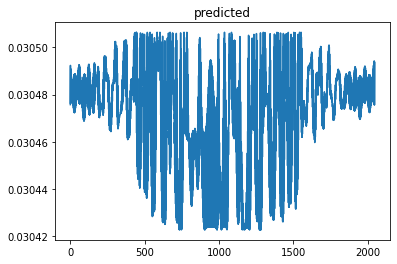

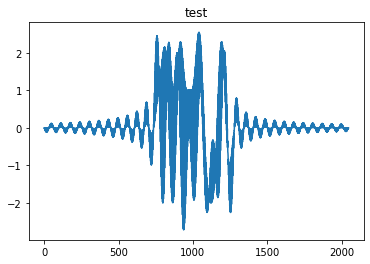

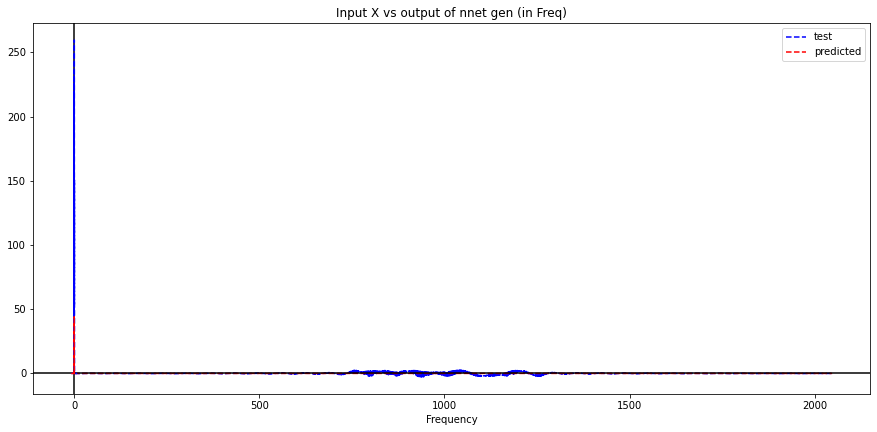

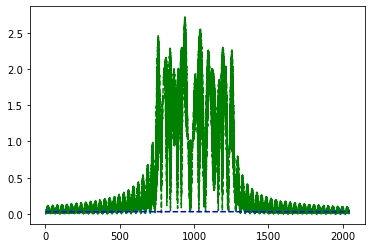

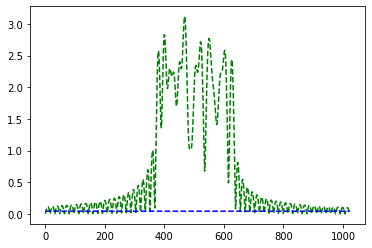

In [ ]:
# testing the model
index_pred = 695
with_error_plots = False
y_pred = test_model(model_lstm2, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)


In [ ]:
epochs = 3
# Fiting the model
model_lstm = train(model_lstm_cnn, X_train, X_test, y_train, y_test, epochs , batch_size)

Epoch 1/3
704/704 [==============================] - 421s 588ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1465 - mean_absolute_percentage_error: 16921.0625 - cosine_proximity: 1.0000 - msle: 0.0176 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1194 - val_mean_absolute_percentage_error: 11350.1230 - val_cosine_proximity: 1.0000 - val_msle: 0.0109
Epoch 2/3
704/704 [==============================] - 410s 583ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - mean_absolute_error: 0.0992 - mean_absolute_percentage_error: 20747.9350 - cosine_proximity: 1.0000 - msle: 0.0091 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.0974 - val_mean_absolute_percentage_error: 10120.2695 - val_cosine_proximity: 1.0000 - val_msle: 0.0089
Epoch 3/3
704/704 [==============================] - 410s 583ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.0919 - mean_absolute_percentage_

X_test.shape :  (7500, 2048, 1)
y_test.shape :  (7500, 2048, 1)
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1, 1)


After reshaping...
X.shape :  (2048, 1)
y_pred.shape :  (2048, 1)
y_pred :  [[0.5054246 ]
 [0.50494856]
 [0.5055274 ]
 ...
 [0.4984662 ]
 [0.50505924]
 [0.5023168 ]]
y_pred.shape :  (2048, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
{fromRealToComplex} vect_im.shape :  (1, 1024, 1)
y_test_im.shape :  (1024,)
y_pred_im.shape :  (1024,)
y_.shape :  (2048,)
y_pred.shape :  (2048,)


y_ :  [0.61992088 0.5865048  0.40711177 ... 0.38916306 0.39951026 0.37524659]
y_test_im :  [0.61992088+0.5865048j  0.40711177+0.34693829j 0.40843977+0.34797182j ...
 0.4377259 +0.39180826j 0.43499756+0.38916306j 0.39951026+0.37524659j]
y_pred :  [0.5054246  0.50494856 0.5055274  ... 0.4984662  0.50505924 0.5023168 ]
y_pred_im :  [0.5054246 +0.50494856j 0.5055274 +0.49840817j 0.50552887+0.4984068j  ...
 0.50506496+0.498466j   0.50506765+0.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


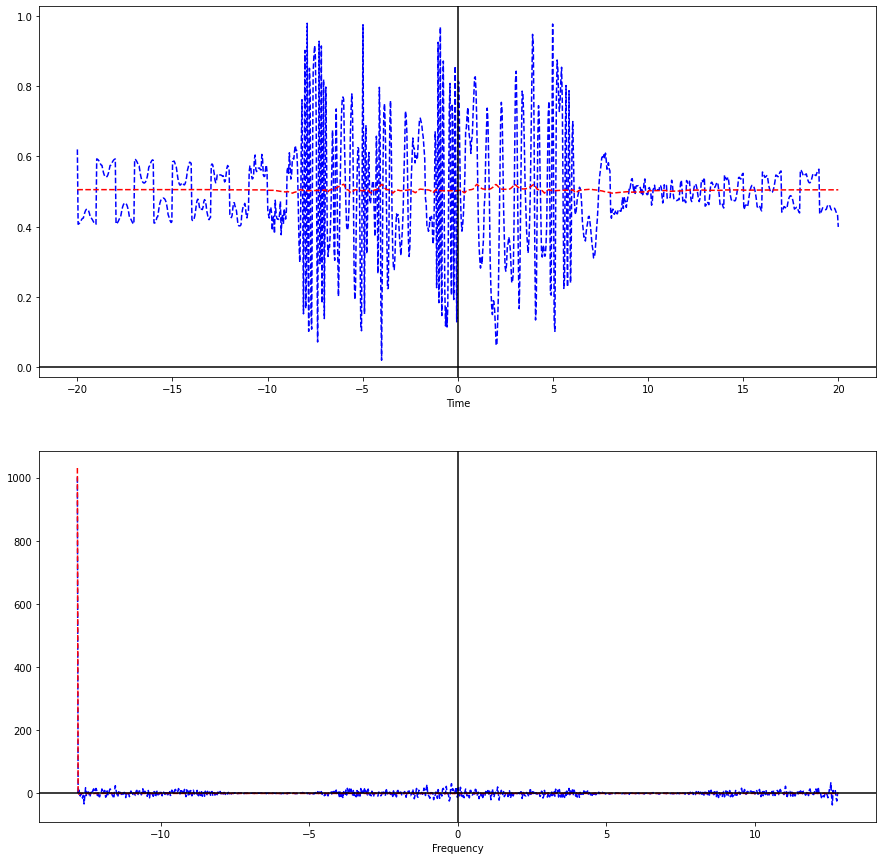

In [ ]:
# testing the model
index_pred = 695
with_error_plots = False
y_pred = test_model(model_lstm_cnn, X_test, y_test, history, index_pred, with_error_plots)
test_prediction(y_test, y_pred, index_pred, parameters)

In [ ]:
epochs = 35
# Fiting the model
model_lstm = train(model_lstm_cnn, X_train, X_test, y_train, y_test, epochs , batch_size)

Epoch 1/35
469/469 [==============================] - 161s 343ms/step - loss: 0.0939 - mean_squared_error: 0.0939 - mean_absolute_error: 0.1841 - mean_absolute_percentage_error: 53119308.0000 - cosine_proximity: 0.6866 - msle: 0.0460 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.0948 - val_mean_absolute_percentage_error: 27757368.0000 - val_cosine_proximity: 0.6881 - val_msle: 0.0147
Epoch 2/35
469/469 [==============================] - 158s 337ms/step - loss: 0.0667 - mean_squared_error: 0.0667 - mean_absolute_error: 0.1294 - mean_absolute_percentage_error: 37883272.0000 - cosine_proximity: 0.6857 - msle: 0.0326 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0595 - val_mean_absolute_percentage_error: 18437834.0000 - val_cosine_proximity: 0.6881 - val_msle: 0.0083
Epoch 3/35
469/469 [==============================] - 158s 338ms/step - loss: 0.0523 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1007 - mean_absol

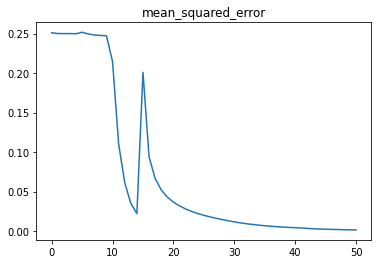

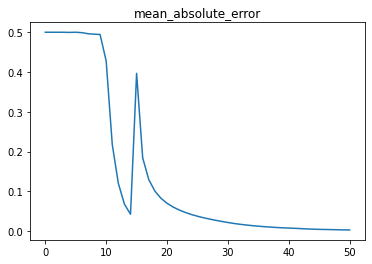

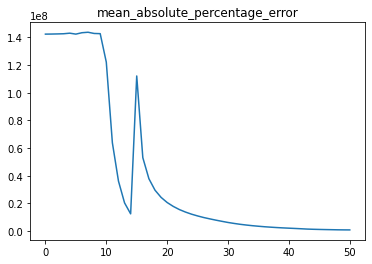

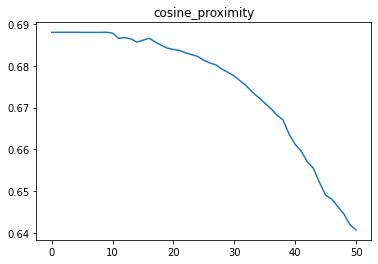

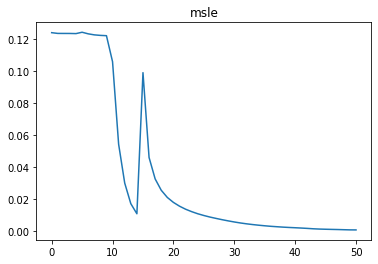

X_test.shape :  (10000, 1500, 1)
y_test.shape :  (10000, 1500, 1)
X.shape :  (1500, 1)
y_pred.shape :  (1500, 1, 1)
After reshaping...
X.shape :  (1500, 1)
y_pred.shape :  (1500, 1)
{fromRealToComplex} vect_im.shape :  (1, 750)
{fromRealToComplex} vect_im.shape :  (1, 750)
[channel] qzt : [[ 5.14537068e-01+2.66219635e-01j -1.06614302e-01+5.61374909e-01j
   4.45955252e-01+6.28453247e-01j  2.62848505e-01+7.03914640e-01j
   5.12281935e-01+9.48706748e-01j -1.26308989e-01-5.14120161e-02j
  -1.28234528e-01+4.53183884e-01j -1.92490823e-01+1.12102747e+00j
  -5.28126035e-01+8.22673958e-01j  3.91619626e-01+8.09660457e-01j
   5.91216187e-01+1.02384213e+00j  4.73906673e-01+2.32851642e-01j
  -9.02074508e-02+6.13133092e-01j  4.55383741e-01+1.39162992e-01j
  -5.08670884e-01+1.04320200e+00j  5.12573390e-01+7.87222636e-01j
   3.52768987e-01+6.21673305e-01j  7.63582921e-01+5.96759549e-01j
   2.24500198e-01+2.50248939e-01j  4.52955271e-01-4.00555058e-01j
   5.98335171e-01+1.68247922e-02j  3.93274571e-02+

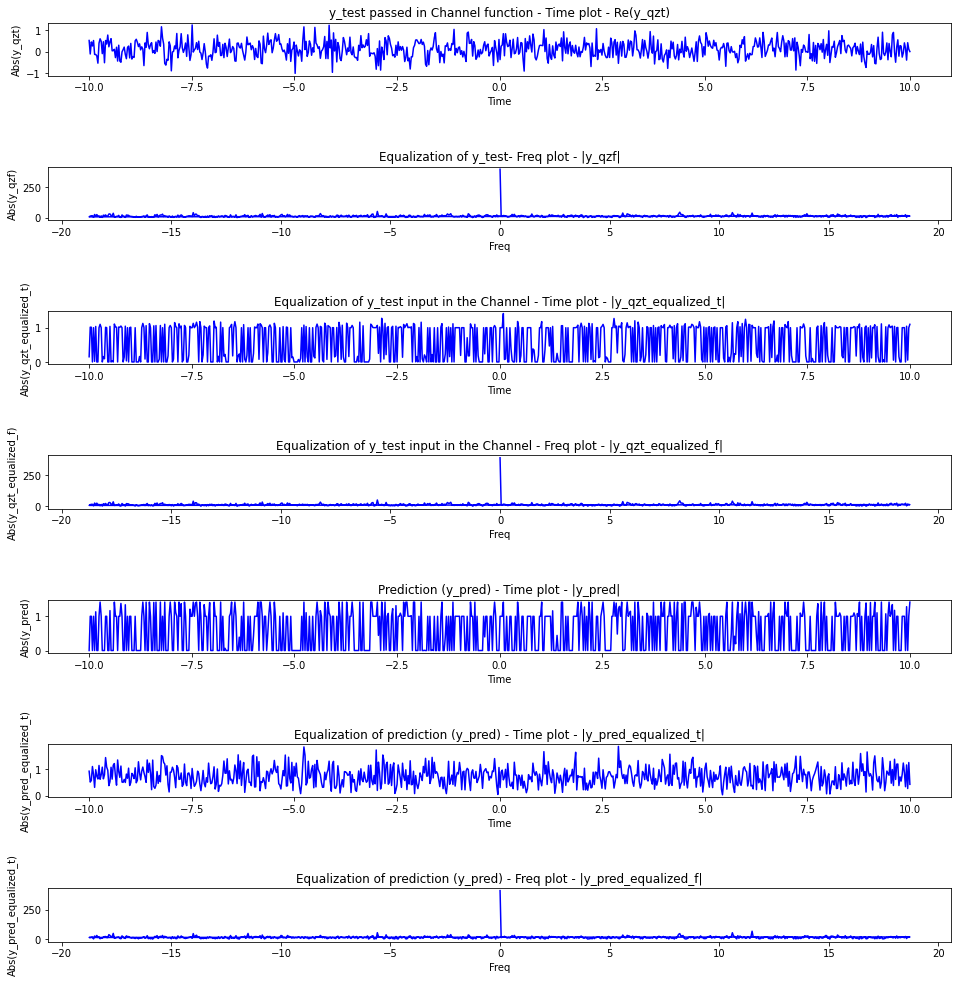

In [ ]:
# testing the model
index_pred = -1
with_error_plots = True
y_pred = test_model(model_lstm, X_test, y_test, history, index_pred, with_error_plots)

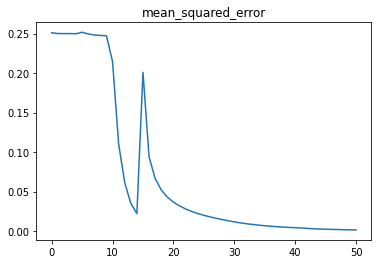

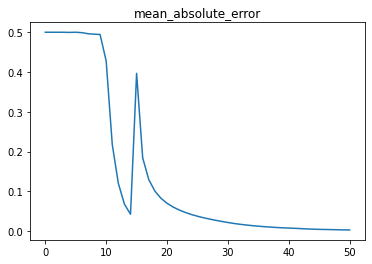

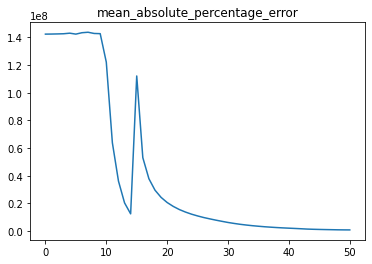

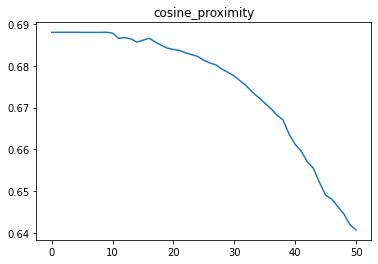

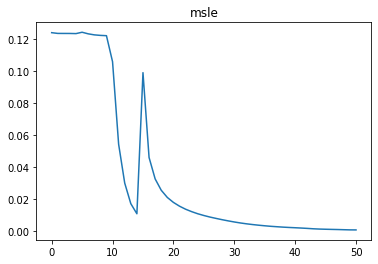

X_test.shape :  (10000, 1500, 1)
y_test.shape :  (10000, 1500, 1)
X.shape :  (1500, 1)
y_pred.shape :  (1500, 1, 1)
After reshaping...
X.shape :  (1500, 1)
y_pred.shape :  (1500, 1)
{fromRealToComplex} vect_im.shape :  (1, 750)
{fromRealToComplex} vect_im.shape :  (1, 750)
[channel] qzt : [[ 5.14537068e-01+2.66219635e-01j -1.06614302e-01+5.61374909e-01j
   4.45955252e-01+6.28453247e-01j  2.62848505e-01+7.03914640e-01j
   5.12281935e-01+9.48706748e-01j -1.26308989e-01-5.14120161e-02j
  -1.28234528e-01+4.53183884e-01j -1.92490823e-01+1.12102747e+00j
  -5.28126035e-01+8.22673958e-01j  3.91619626e-01+8.09660457e-01j
   5.91216187e-01+1.02384213e+00j  4.73906673e-01+2.32851642e-01j
  -9.02074508e-02+6.13133092e-01j  4.55383741e-01+1.39162992e-01j
  -5.08670884e-01+1.04320200e+00j  5.12573390e-01+7.87222636e-01j
   3.52768987e-01+6.21673305e-01j  7.63582921e-01+5.96759549e-01j
   2.24500198e-01+2.50248939e-01j  4.52955271e-01-4.00555058e-01j
   5.98335171e-01+1.68247922e-02j  3.93274571e-02+

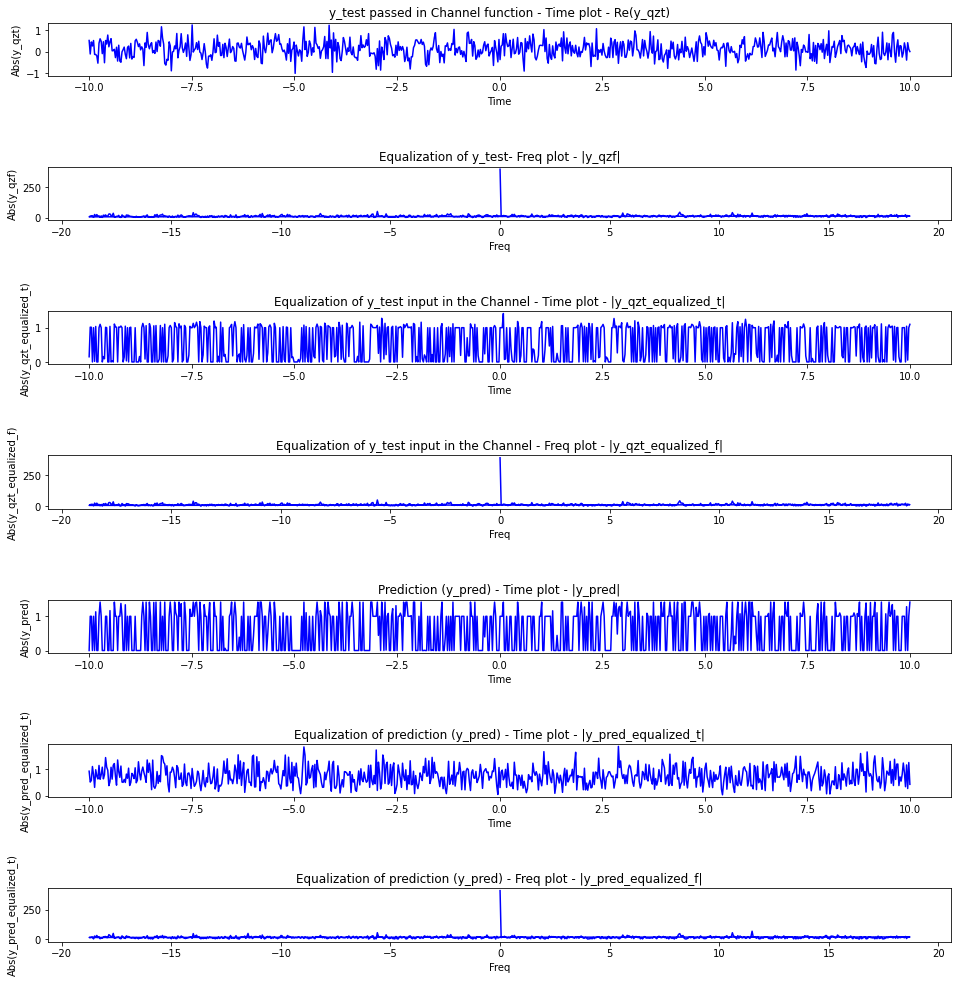

In [ ]:
# testing the model
index_pred = 150
with_error_plots = True
y_pred = test_model(model_lstm, X_test, y_test, history, index_pred, with_error_plots)

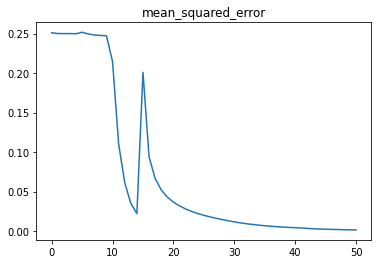

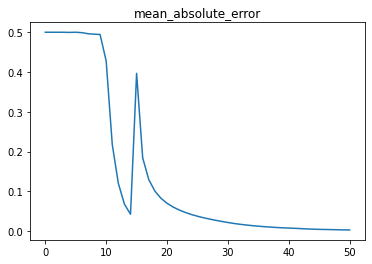

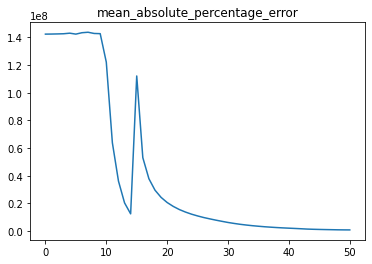

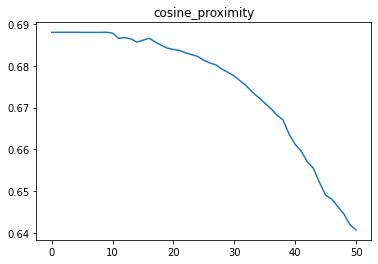

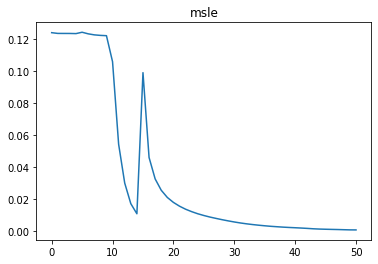

X_test.shape :  (10000, 1500, 1)
y_test.shape :  (10000, 1500, 1)
X.shape :  (1500, 1)
y_pred.shape :  (1500, 1, 1)
After reshaping...
X.shape :  (1500, 1)
y_pred.shape :  (1500, 1)
{fromRealToComplex} vect_im.shape :  (1, 750)
{fromRealToComplex} vect_im.shape :  (1, 750)
[channel] qzt : [[ 5.14537068e-01+2.66219635e-01j -1.06614302e-01+5.61374909e-01j
   4.45955252e-01+6.28453247e-01j  2.62848505e-01+7.03914640e-01j
   5.12281935e-01+9.48706748e-01j -1.26308989e-01-5.14120161e-02j
  -1.28234528e-01+4.53183884e-01j -1.92490823e-01+1.12102747e+00j
  -5.28126035e-01+8.22673958e-01j  3.91619626e-01+8.09660457e-01j
   5.91216187e-01+1.02384213e+00j  4.73906673e-01+2.32851642e-01j
  -9.02074508e-02+6.13133092e-01j  4.55383741e-01+1.39162992e-01j
  -5.08670884e-01+1.04320200e+00j  5.12573390e-01+7.87222636e-01j
   3.52768987e-01+6.21673305e-01j  7.63582921e-01+5.96759549e-01j
   2.24500198e-01+2.50248939e-01j  4.52955271e-01-4.00555058e-01j
   5.98335171e-01+1.68247922e-02j  3.93274571e-02+

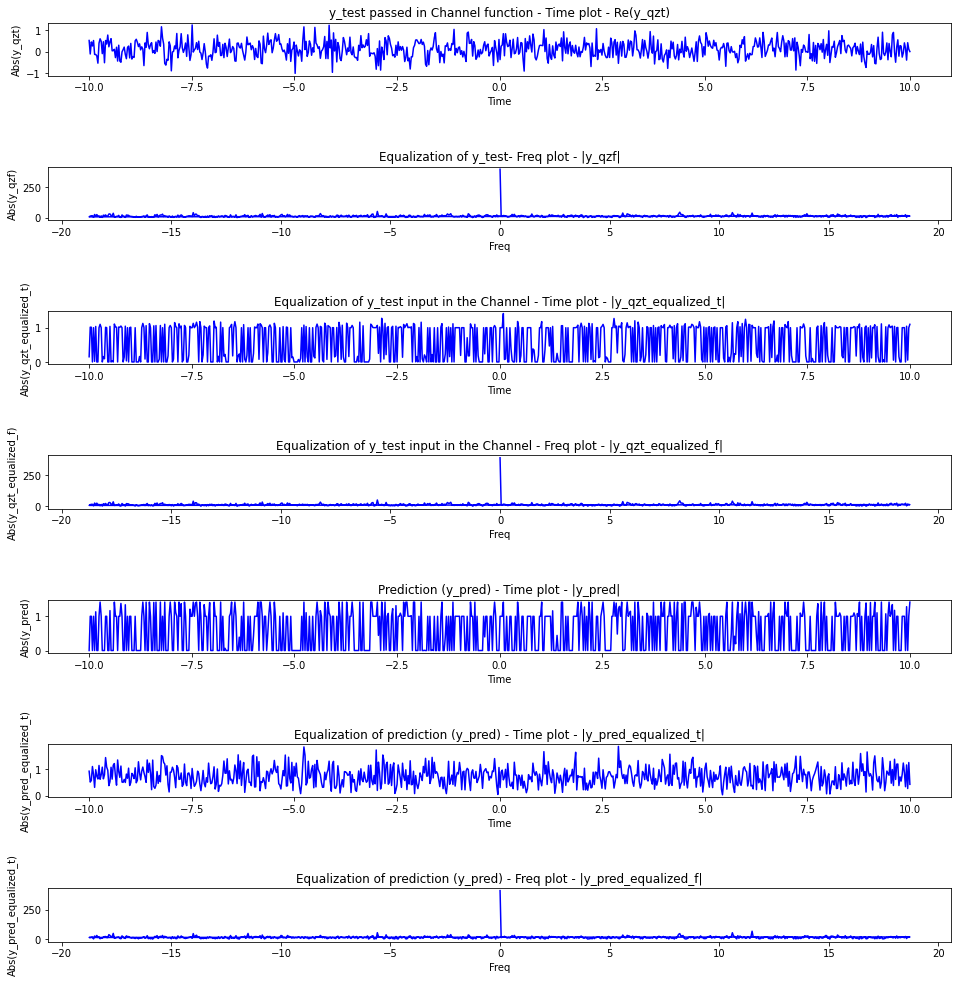

In [ ]:
# testing the model
index_pred = 951
with_error_plots = True
y_pred = test_model(model_lstm, X_test, y_test, history, index_pred, with_error_plots)

In [ ]:
# testing the model
index_pred = 234
with_error_plots = True
y_pred = test_model(model_lstm, X_test, y_test, history, index_pred, with_error_plots)

#**Bits-To-Bit**

### **MLP**

In [ ]:
from keras.optimizers import SGD,RMSprop

In [ ]:
def ber(y_pred, y_tester):
  return np.sum(np.abs(y_pred -y_tester ))/len(y_tester)

In [ ]:
n_input = 2048
n_output = 1

In [ ]:
model = Sequential()

# Define the model ------------------------------------------------------------------------------------------------------#

model.add(Dense(128, use_bias=True,  input_shape=X_train.shape[1:]))
model.add(Activation('sigmoid'))

model.add(Dense(16, use_bias=True))
model.add(Activation('sigmoid'))

model.add(Dense(16, use_bias=True))
model.add(Activation('sigmoid'))

model.add(Dense(16, use_bias=True))
model.add(Activation('sigmoid'))

model.add(Dense(n_output))
model.add(Activation('softmax'))

# Compile the model ------------------------------------------------------------------------------------------------------#
  
sgd = SGD(lr=1, decay=1e-2, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy', 'mae'])

print(model.optimizer.get_config())
print(model.summary())
print("model.output_shape : ",model.output_shape)

{'name': 'SGD', 'learning_rate': 1, 'decay': 0.01, 'momentum': 0.9, 'nesterov': False}
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_128 (Dense)            (None, 64, 128)           256       
_________________________________________________________________
activation_101 (Activation)  (None, 64, 128)           0         
_________________________________________________________________
dense_129 (Dense)            (None, 64, 16)            2064      
_________________________________________________________________
activation_102 (Activation)  (None, 64, 16)            0         
_________________________________________________________________
dense_130 (Dense)            (None, 64, 16)            272       
_________________________________________________________________
activation_103 (Activation)  (None, 64, 16)            0         
________________________________

In [ ]:
tyoe(X_train.shape[1:])

NameError: ignored

In [ ]:
def make_model(n_input=2048,n_output=1):
    model=Sequential()
    model.add(Dense(n_input,activation="sigmoid",input_shape=(n_input,1)))
    
    model.add(Dense(n_input,activation="sigmoid"))
    model.add(Dense(n_input,activation="sigmoid"))
    model.add(Dense(n_input,activation="sigmoid"))
    model.add(Dense(n_input,activation="sigmoid"))
    model.add(Dense(n_output,activation="sigmoid"))
    
    rms = RMSprop()
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    model.compile(loss="binary_crossentropy",optimizer=sgd,metrics=["accuracy"])
    
    print(model.optimizer.get_config())
    print(model.summary())
    print("model.output_shape : ",model.output_shape)
    return model

In [ ]:
model = make_model()

{'name': 'SGD', 'learning_rate': 0.001, 'decay': 1e-06, 'momentum': 0.5, 'nesterov': True}
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_145 (Dense)            (None, 2048, 2048)        4096      
_________________________________________________________________
dense_146 (Dense)            (None, 2048, 2048)        4196352   
_________________________________________________________________
dense_147 (Dense)            (None, 2048, 2048)        4196352   
_________________________________________________________________
dense_148 (Dense)            (None, 2048, 2048)        4196352   
_________________________________________________________________
dense_149 (Dense)            (None, 2048, 2048)        4196352   
_________________________________________________________________
dense_150 (Dense)            (None, 2048, 1)           2049      
Total params: 16,791,553
Tra

In [ ]:
epochs = 40
batch_size = 32
# Fiting the model
model = train(model, X_train, X_test, y_train, y_test, epochs , batch_size, earlystopping_patience=500)

Epoch 1/40
407/407 [==============================] - 18s 42ms/step - loss: 0.6999 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 2/40
407/407 [==============================] - 16s 41ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.4991
Epoch 3/40
407/407 [==============================] - 16s 40ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4991
Epoch 4/40
407/407 [==============================] - 16s 40ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 5/40
407/407 [==============================] - 16s 40ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 6/40
407/407 [==============================] - 16s 40ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.5009
Epoch 7/40
407/407 [==============================] - 16s 40ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
index_pred = 0
y_pred = model.predict(y_test[index_pred])
y_tester = np.squeeze(y_test[index_pred])
y_pred = np.squeeze(y_pred)

print("BER : ",ber(y_pred, y_tester))

BER :  0.48674010392278433


In [ ]:
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [ ]:
y_tester

array([1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)